In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [3]:

def load_dataset():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    # Download and load the training data
    train_dataset = datasets.MNIST(root='./data', 
                             train=True, 
                             download=True, 
                             transform=transform
                             )
    return train_dataset

def generate_random_image(train_dataset):
    images = []
    labels = []
    for _ in range(4):
        idx = torch.randint(len(train_dataset), size=(1,)).item()
        img, label = train_dataset[idx]
        images.append(img.squeeze().numpy())
        labels.append(label)

# Concatenate images into a 2x2 grid
    top_row = np.concatenate([images[0], images[1]], axis=1)
    bottom_row = np.concatenate([images[2], images[3]], axis=1)
    final_image = np.concatenate([top_row, bottom_row], axis=0)
    return final_image, labels

def split_image_to_patches(image):
    blocks = []  # Initialize empty list to store blocks

    for i in range(4):
        for j in range(4):
            # Extract 14x14 block
            block = image[i*14:(i+1)*14, j*14:(j+1)*14]
            blocks.append(block)  # Add block to our list
    return blocks

def create_dataset(num_images, train_dataset):
    dataset = []
    
    for _ in range(num_images):
        image, labels = generate_random_image(train_dataset)
        dataset.append((image, labels))
    
    return dataset



TypeError: create_dataset() missing 1 required positional argument: 'train_dataset'

In [69]:
train_dataset = load_dataset()
dataset = create_dataset(10000, train_dataset)
print(dataset[0]) #numpy array followed by array of the 4 labels

(array([[-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       ...,
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296]], shape=(56, 56), dtype=float32), [8, 7, 3, 6])


In [7]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_label_pairs):
        self.image_label_pairs = image_label_pairs
    
    def __len__(self):
        return len(self.image_label_pairs)
    
    def __getitem__(self, idx):
        image, label = self.image_label_pairs[idx]

        patches_array = self.split_image_to_patches(image)
        patches_tensor = [torch.tensor(patch.flatten(), dtype=torch.float32) for patch in patches_array] #array of 16 with each tensor[196]
        image_tensor = torch.stack(patches_tensor) # tensor [16,196]
        #turn label array of integers into tensor:
        label_tensor = torch.tensor(label, dtype=torch.long)
        
        
        return {
            'image': image_tensor,
            'label': label_tensor,
        }
    
    def split_image_to_patches(self, image):
        blocks = []  # Initialize empty list to store blocks

        for i in range(4):
            for j in range(4):
                # Extract 14x14 block
                block = image[i*14:(i+1)*14, j*14:(j+1)*14]
                blocks.append(block)  # Add block to our list
        return blocks


In [ ]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [80]:
class Embedding_Layer(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super(Embedding_Layer, self).__init__()
        self.embedding = nn.Linear(input_dim, embedding_dim)
        #input dimension is the dimension of each patch
        #embedding_dim is the dimensionality that each patch is embedded onto
    def forward(self, x):
        return self.embedding(x)

class Attention_Layer(nn.Module):
    def __init__(self, d_model, num_heads):
        super(Attention_Layer, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads

        self.W_q = torch.nn.Linear(d_model, d_model)
        self.W_k = torch.nn.Linear(d_model, d_model)
        self.W_v = torch.nn.Linear(d_model, d_model)
    
    def forward(self, query_input, key_input, value_input, mask=None):
        dim_k = self.d_model // self.num_heads
        query = self.W_q(query_input)
        key = self.W_k(key_input)
        value = self.W_v(value_input)
        
        query_key = torch.matmul(query, key.transpose(-1, -2)) / math.sqrt(dim_k)
        prob = query_key.softmax(dim=-1)
        weighted_attention = torch.matmul(prob, value)
        return weighted_attention, prob
    

class PositionalEncoding(nn.Module):
    # Just add a randomised matrix to 
    def __init__(self, first_dim, embedding_dimension):
        super(PositionalEncoding, self).__init__()
        self.first_dim = first_dim
        self.embedding_dimension = embedding_dimension
        self.positional_encoding = torch.nn.Parameter(torch.rand(first_dim, embedding_dimension))

    def forward(self, x):
        return x + self.positional_encoding(self.first_dim, self.embedding_dimension)
    

class FeedForwardLayer(nn.Module):
    def __init__(self, embedding_dim, hidden_layer_dim):
        super(FeedForwardLayer, self).__init__()
        self.ff1 = torch.nn.Linear(embedding_dim, hidden_layer_dim)
        self.ff2 = torch.nn.Linear(hidden_layer_dim, embedding_dim)
        self.relu = torch.nn.ReLU()
    
    def forward(self, x):
        return self.ff2(self.relu(self.ff1(x)))
    

class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."

    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2



class Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, n_loops, feed_forward, num_heads):
        super(Encoder, self).__init__()
        self.embedding_layer = Embedding_Layer(input_dim, embedding_dim)
        self.attn_layer = Attention_Layer(embedding_dim, num_heads)
        self.FF_layer = feed_forward
        self.embedding_dim = embedding_dim
        self.input_dim = input_dim
        self.n_loops = n_loops


        #remove below when doing full model
        self.intermediate = torch.nn.Linear(64*16, 10)
        self.relu = torch.nn.ReLU()
        self.flatten = torch.nn.Flatten()
        self.final = torch.nn.Linear(10, 10)
    
    def get_qkv(self, q_input, k_input, v_input, embedding_dim):
        query = torch.nn.Linear(q_input.size(-1), embedding_dim)
        key = torch.nn.Linear(k_input.size(-1), embedding_dim)
        value = torch.nn.Linear(v_input.size(-1), embedding_dim)
        return query, key, value
    
    def LayerNorm(self, x, eps=1e-6):
        features = x.size(-1)
        a_2 = torch.nn.Parameter(torch.ones(features)) #shape (64,)
        b_2 = torch.nn.Parameter(torch.zeros(features)) #shape (64,)

        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)

        return a_2 * (x - mean) / (std + eps) + b_2

    
    def forward(self, x):
        embedding = self.embedding_layer(x)

        # for i in range(self.n_loops): #To do, to add loops, we must clone Encoder layers which consist of ff + attn
        # query, key, value = self.get_qkv(x, x, x, self.embedding_dim)
        attn, prob = self.attn_layer.forward(embedding, embedding, embedding, None)
        x = attn + self.LayerNorm(attn)
        x = self.FF_layer(x)
        x = x + self.LayerNorm(x)

        return x
    
    def predict_single_integer(self, x):
        if len(x.shape) == 2:  # Single instance case [16, 64]
            x = x.unsqueeze(0)  # Add batch dimension [1, 16, 64]
        
        # Now x is [batch, 16, 64] in both cases
        x = x.reshape(x.size(0), -1)  # Flatten to [batch, 1024]
        print(x.shape, 'x.shape')
        flatten = self.flatten(x)
        print(flatten.shape, "flatten.shape")
        x = self.intermediate(flatten)
        x = self.relu(x)
        return self.final(x)




In [85]:
device = torch.device("cpu")
embedding_dim = 64
hidden_layer_dimension = 32
input_dimension = 196
epochs = 50
fflayer = FeedForwardLayer(embedding_dim, hidden_layer_dimension)
model = Encoder(input_dimension, embedding_dim, 1, fflayer, num_heads=1)
criterion = torch.nn.CrossEntropyLoss()  # Cross-Entropy Loss for classification
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), learning_rate)


dataset_ready = ImageDataset(dataset)
batch_size = 20
dataloader = torch.utils.data.DataLoader(
    dataset_ready,
    batch_size=batch_size,
    shuffle=True,
)



def train():
    model.train()
    total_loss = 0
    for epoch in range(epochs):
        epoch_loss = 0
        progress_bar = tqdm.tqdm(
            dataloader, desc=f"Epoch {epoch + 1}/{epochs}"
        )

        for batch_idx, batch in enumerate(progress_bar):
            
            batch_loss = 0
            image, label = batch['image'].to(device), batch['label'].to(device)

            first_labels = label[:, 0]
            optimizer.zero_grad()

            output = model.forward(image)
            single_number = model.predict_single_integer(output)

            predictions = torch.argmax(single_number, dim=1)
            if batch_idx == 0:  # Print only first batch of each epoch
                print(f"Predictions: {predictions[0:5]}")
                print(f"Actual labels: {first_labels[0:5]}")
            batch_loss = criterion(single_number, first_labels)

            progress_bar.set_postfix({"batch_loss": batch_loss.item() /  batch_size})

            epoch_loss += batch_loss.item()
            total_loss += batch_loss.item()
            batch_loss.backward()
            optimizer.step()
        
        epoch_loss = epoch_loss / len(dataloader.dataset)
        # total_loss += epoch_loss
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}")
        print(f"Total {epoch + 1}/{epochs}, Loss: {total_loss / (epoch + 1):.4f}")

        
train()



Epoch 1/50:   3%|▎         | 16/500 [00:00<00:03, 155.01it/s, batch_loss=0.114]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Predictions: tensor([8, 1, 8, 8, 8])
Actual labels: tensor([6, 4, 4, 9, 1])
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Siz

Epoch 1/50:  12%|█▏        | 60/500 [00:00<00:02, 199.21it/s, batch_loss=0.118]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 1/50:  21%|██        | 104/500 [00:00<00:02, 194.25it/s, batch_loss=0.116]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 1/50:  29%|██▉       | 147/500 [00:00<00:01, 202.75it/s, batch_loss=0.113]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 1/50:  38%|███▊      | 191/500 [00:01<00:01, 210.44it/s, batch_loss=0.111]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 1/50:  47%|████▋     | 235/500 [00:01<00:01, 210.95it/s, batch_loss=0.11] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 1/50:  56%|█████▌    | 279/500 [00:01<00:01, 205.92it/s, batch_loss=0.114]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 1/50:  60%|██████    | 300/500 [00:01<00:01, 162.70it/s, batch_loss=0.114]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 1/50:  69%|██████▉   | 344/500 [00:01<00:00, 185.26it/s, batch_loss=0.115]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 1/50:  77%|███████▋  | 387/500 [00:02<00:00, 198.41it/s, batch_loss=0.114]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 1/50:  86%|████████▌ | 431/500 [00:02<00:00, 206.92it/s, batch_loss=0.116]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 1/50:  95%|█████████▌| 475/500 [00:02<00:00, 208.86it/s, batch_loss=0.118]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 1/50: 100%|██████████| 500/500 [00:02<00:00, 200.06it/s, batch_loss=0.106]


torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Epoch 1/50, Loss: 0.1138
Total 1/50, Loss: 1138.3718


Epoch 2/50:   4%|▍         | 21/500 [00:00<00:02, 201.89it/s, batch_loss=0.106]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Predictions: tensor([1, 1, 9, 8, 8])
Actual labels: tensor([4, 4, 3, 8, 1])
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Siz

Epoch 2/50:   8%|▊         | 42/500 [00:00<00:02, 206.54it/s, batch_loss=0.115]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 2/50:  13%|█▎        | 63/500 [00:00<00:02, 208.06it/s, batch_loss=0.108] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 2/50:  17%|█▋        | 84/500 [00:00<00:02, 207.95it/s, batch_loss=0.111]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 2/50:  21%|██        | 106/500 [00:00<00:01, 210.24it/s, batch_loss=0.119]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 2/50:  26%|██▌       | 128/500 [00:00<00:01, 212.96it/s, batch_loss=0.116]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 2/50:  30%|███       | 150/500 [00:00<00:01, 208.24it/s, batch_loss=0.111]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 2/50:  30%|███       | 150/500 [00:00<00:01, 208.24it/s, batch_loss=0.113]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 2/50:  34%|███▍      | 171/500 [00:00<00:02, 159.73it/s, batch_loss=0.107]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 2/50:  38%|███▊      | 190/500 [00:01<00:01, 165.22it/s, batch_loss=0.106]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 2/50:  42%|████▏     | 210/500 [00:01<00:01, 172.95it/s, batch_loss=0.114]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 2/50:  46%|████▋     | 232/500 [00:01<00:01, 184.51it/s, batch_loss=0.115]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 2/50:  50%|█████     | 252/500 [00:01<00:01, 185.46it/s, batch_loss=0.116]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 2/50:  54%|█████▍    | 272/500 [00:01<00:01, 183.67it/s, batch_loss=0.109]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 2/50:  59%|█████▉    | 294/500 [00:01<00:01, 191.76it/s, batch_loss=0.112]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 2/50:  63%|██████▎   | 316/500 [00:01<00:00, 197.58it/s, batch_loss=0.109]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 2/50:  67%|██████▋   | 337/500 [00:01<00:00, 199.25it/s, batch_loss=0.117] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 2/50:  72%|███████▏  | 358/500 [00:01<00:00, 201.74it/s, batch_loss=0.111] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 2/50:  76%|███████▌  | 380/500 [00:01<00:00, 204.38it/s, batch_loss=0.109] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 2/50:  80%|████████  | 402/500 [00:02<00:00, 206.80it/s, batch_loss=0.113]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 2/50:  85%|████████▍ | 423/500 [00:02<00:00, 207.05it/s, batch_loss=0.102]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 2/50:  85%|████████▍ | 423/500 [00:02<00:00, 207.05it/s, batch_loss=0.109]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 2/50:  89%|████████▉ | 444/500 [00:02<00:00, 204.42it/s, batch_loss=0.106] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 2/50:  93%|█████████▎| 465/500 [00:02<00:00, 163.83it/s, batch_loss=0.115] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 2/50:  97%|█████████▋| 484/500 [00:02<00:00, 170.17it/s, batch_loss=0.109]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 2/50: 100%|██████████| 500/500 [00:02<00:00, 189.37it/s, batch_loss=0.114] 


torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Epoch 2/50, Loss: 0.1111
Total 2/50, Loss: 1124.7018


Epoch 3/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.112]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Predictions: tensor([1, 7, 9, 1, 7])
Actual labels: tensor([3, 4, 2, 6, 5])
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 3/50:   4%|▎         | 18/500 [00:00<00:02, 176.85it/s, batch_loss=0.109]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 3/50:   8%|▊         | 39/500 [00:00<00:02, 195.68it/s, batch_loss=0.114]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 3/50:   8%|▊         | 39/500 [00:00<00:02, 195.68it/s, batch_loss=0.108]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 3/50:  12%|█▏        | 59/500 [00:00<00:02, 194.92it/s, batch_loss=0.103] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 3/50:  12%|█▏        | 59/500 [00:00<00:02, 194.92it/s, batch_loss=0.117]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 3/50:  16%|█▌        | 79/500 [00:00<00:02, 183.41it/s, batch_loss=0.104]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 3/50:  20%|██        | 100/500 [00:00<00:02, 192.35it/s, batch_loss=0.113]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 3/50:  20%|██        | 100/500 [00:00<00:02, 192.35it/s, batch_loss=0.11] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 3/50:  24%|██▍       | 121/500 [00:00<00:01, 195.66it/s, batch_loss=0.108]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 3/50:  28%|██▊       | 142/500 [00:00<00:01, 197.17it/s, batch_loss=0.106]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 3/50:  28%|██▊       | 142/500 [00:00<00:01, 197.17it/s, batch_loss=0.113]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 3/50:  32%|███▏      | 162/500 [00:00<00:02, 155.24it/s, batch_loss=0.107]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 3/50:  36%|███▌      | 181/500 [00:01<00:01, 163.78it/s, batch_loss=0.11]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 3/50:  40%|████      | 202/500 [00:01<00:01, 174.17it/s, batch_loss=0.111] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 3/50:  44%|████▍     | 222/500 [00:01<00:01, 179.42it/s, batch_loss=0.112] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 3/50:  49%|████▊     | 243/500 [00:01<00:01, 187.07it/s, batch_loss=0.11]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 3/50:  53%|█████▎    | 263/500 [00:01<00:01, 189.26it/s, batch_loss=0.116] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 3/50:  57%|█████▋    | 283/500 [00:01<00:01, 186.77it/s, batch_loss=0.115] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 3/50:  61%|██████    | 305/500 [00:01<00:01, 194.69it/s, batch_loss=0.112]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 3/50:  65%|██████▌   | 326/500 [00:01<00:00, 197.96it/s, batch_loss=0.103] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 3/50:  69%|██████▉   | 347/500 [00:01<00:00, 200.71it/s, batch_loss=0.106] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 3/50:  74%|███████▍  | 369/500 [00:01<00:00, 204.61it/s, batch_loss=0.109] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 3/50:  78%|███████▊  | 390/500 [00:02<00:00, 205.25it/s, batch_loss=0.117]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 3/50:  82%|████████▏ | 411/500 [00:02<00:00, 203.38it/s, batch_loss=0.115] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 3/50:  87%|████████▋ | 433/500 [00:02<00:00, 206.67it/s, batch_loss=0.113]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 3/50:  87%|████████▋ | 433/500 [00:02<00:00, 206.67it/s, batch_loss=0.106]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 3/50:  91%|█████████ | 454/500 [00:02<00:00, 162.46it/s, batch_loss=0.106] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 3/50:  95%|█████████▌| 476/500 [00:02<00:00, 175.16it/s, batch_loss=0.106] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 3/50:  99%|█████████▉| 496/500 [00:02<00:00, 181.14it/s, batch_loss=0.102]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 3/50: 100%|██████████| 500/500 [00:02<00:00, 186.22it/s, batch_loss=0.111]


torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Epoch 3/50, Loss: 0.1092
Total 3/50, Loss: 1113.7623


Epoch 4/50:   4%|▎         | 18/500 [00:00<00:02, 174.09it/s, batch_loss=0.113]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Predictions: tensor([1, 8, 7, 7, 7])
Actual labels: tensor([3, 2, 1, 0, 0])
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Siz

Epoch 4/50:   4%|▎         | 18/500 [00:00<00:02, 174.09it/s, batch_loss=0.107] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 4/50:   4%|▎         | 18/500 [00:00<00:02, 174.09it/s, batch_loss=0.108]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 4/50:  12%|█▏        | 60/500 [00:00<00:02, 198.76it/s, batch_loss=0.107]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 4/50:  12%|█▏        | 60/500 [00:00<00:02, 198.76it/s, batch_loss=0.108] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 4/50:  16%|█▋        | 82/500 [00:00<00:02, 205.96it/s, batch_loss=0.105]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 4/50:  21%|██        | 103/500 [00:00<00:01, 205.23it/s, batch_loss=0.112]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 4/50:  21%|██        | 103/500 [00:00<00:01, 205.23it/s, batch_loss=0.121] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 4/50:  21%|██        | 103/500 [00:00<00:01, 205.23it/s, batch_loss=0.101] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 4/50:  25%|██▍       | 124/500 [00:00<00:01, 201.25it/s, batch_loss=0.114] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 4/50:  29%|██▉       | 145/500 [00:00<00:01, 194.03it/s, batch_loss=0.104] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 4/50:  29%|██▉       | 145/500 [00:00<00:01, 194.03it/s, batch_loss=0.109]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 4/50:  29%|██▉       | 145/500 [00:00<00:01, 194.03it/s, batch_loss=0.102]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 4/50:  33%|███▎      | 165/500 [00:01<00:02, 148.42it/s, batch_loss=0.107]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 4/50:  33%|███▎      | 165/500 [00:01<00:02, 148.42it/s, batch_loss=0.107]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 4/50:  37%|███▋      | 186/500 [00:01<00:01, 162.58it/s, batch_loss=0.112] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 4/50:  41%|████▏     | 207/500 [00:01<00:01, 173.95it/s, batch_loss=0.108] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 4/50:  41%|████▏     | 207/500 [00:01<00:01, 173.95it/s, batch_loss=0.105]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 4/50:  46%|████▌     | 228/500 [00:01<00:01, 182.98it/s, batch_loss=0.105] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 4/50:  50%|████▉     | 248/500 [00:01<00:01, 183.49it/s, batch_loss=0.0941]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 4/50:  50%|████▉     | 248/500 [00:01<00:01, 183.49it/s, batch_loss=0.114] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 4/50:  54%|█████▎    | 268/500 [00:01<00:01, 188.01it/s, batch_loss=0.107] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 4/50:  58%|█████▊    | 290/500 [00:01<00:01, 196.04it/s, batch_loss=0.1]   

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 4/50:  58%|█████▊    | 290/500 [00:01<00:01, 196.04it/s, batch_loss=0.101]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 4/50:  62%|██████▏   | 311/500 [00:01<00:00, 199.49it/s, batch_loss=0.113] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 4/50:  66%|██████▋   | 332/500 [00:01<00:00, 198.47it/s, batch_loss=0.108] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 4/50:  66%|██████▋   | 332/500 [00:01<00:00, 198.47it/s, batch_loss=0.106]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 4/50:  71%|███████   | 353/500 [00:01<00:00, 196.94it/s, batch_loss=0.106] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 4/50:  75%|███████▌  | 375/500 [00:02<00:00, 201.68it/s, batch_loss=0.106] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 4/50:  75%|███████▌  | 375/500 [00:02<00:00, 201.68it/s, batch_loss=0.0984]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 4/50:  75%|███████▌  | 375/500 [00:02<00:00, 201.68it/s, batch_loss=0.107] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 4/50:  79%|███████▉  | 396/500 [00:02<00:00, 158.88it/s, batch_loss=0.0971]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 4/50:  79%|███████▉  | 396/500 [00:02<00:00, 158.88it/s, batch_loss=0.107] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 4/50:  83%|████████▎ | 417/500 [00:02<00:00, 170.97it/s, batch_loss=0.105] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 4/50:  88%|████████▊ | 438/500 [00:02<00:00, 179.99it/s, batch_loss=0.118] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 4/50:  88%|████████▊ | 438/500 [00:02<00:00, 179.99it/s, batch_loss=0.1]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 4/50:  92%|█████████▏| 458/500 [00:02<00:00, 178.57it/s, batch_loss=0.107] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 4/50:  96%|█████████▌| 479/500 [00:02<00:00, 186.85it/s, batch_loss=0.105] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 4/50:  96%|█████████▌| 479/500 [00:02<00:00, 186.85it/s, batch_loss=0.101]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 4/50: 100%|██████████| 500/500 [00:02<00:00, 185.10it/s, batch_loss=0.106] 


torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Epoch 4/50, Loss: 0.1059
Total 4/50, Loss: 1100.0181


Epoch 5/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.095] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Predictions: tensor([1, 7, 1, 5, 9])
Actual labels: tensor([1, 4, 5, 4, 4])
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 5/50:   4%|▍         | 21/500 [00:00<00:02, 205.78it/s, batch_loss=0.102] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 5/50:   4%|▍         | 21/500 [00:00<00:02, 205.78it/s, batch_loss=0.0989]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 5/50:   4%|▍         | 21/500 [00:00<00:02, 205.78it/s, batch_loss=0.11]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 5/50:   8%|▊         | 42/500 [00:00<00:02, 202.88it/s, batch_loss=0.104] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 5/50:   8%|▊         | 42/500 [00:00<00:02, 202.88it/s, batch_loss=0.0939]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 5/50:   8%|▊         | 42/500 [00:00<00:02, 202.88it/s, batch_loss=0.105] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 5/50:  13%|█▎        | 63/500 [00:00<00:02, 165.42it/s, batch_loss=0.107] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 5/50:  13%|█▎        | 63/500 [00:00<00:02, 165.42it/s, batch_loss=0.0947]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 5/50:  13%|█▎        | 63/500 [00:00<00:02, 165.42it/s, batch_loss=0.0993]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 5/50:  16%|█▌        | 81/500 [00:00<00:03, 130.72it/s, batch_loss=0.0993]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 5/50:  16%|█▌        | 81/500 [00:00<00:03, 130.72it/s, batch_loss=0.11]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 5/50:  20%|█▉        | 99/500 [00:00<00:02, 143.31it/s, batch_loss=0.0954]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 5/50:  20%|█▉        | 99/500 [00:00<00:02, 143.31it/s, batch_loss=0.104] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 5/50:  24%|██▍       | 120/500 [00:00<00:02, 160.67it/s, batch_loss=0.101]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 5/50:  24%|██▍       | 120/500 [00:00<00:02, 160.67it/s, batch_loss=0.115] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 5/50:  28%|██▊       | 141/500 [00:00<00:02, 172.72it/s, batch_loss=0.0987]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 5/50:  28%|██▊       | 141/500 [00:00<00:02, 172.72it/s, batch_loss=0.0966]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 5/50:  32%|███▏      | 162/500 [00:00<00:01, 180.94it/s, batch_loss=0.0935]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 5/50:  32%|███▏      | 162/500 [00:01<00:01, 180.94it/s, batch_loss=0.105] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 5/50:  36%|███▌      | 181/500 [00:01<00:01, 183.52it/s, batch_loss=0.101] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 5/50:  36%|███▌      | 181/500 [00:01<00:01, 183.52it/s, batch_loss=0.091] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 5/50:  40%|████      | 200/500 [00:01<00:01, 185.15it/s, batch_loss=0.105] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 5/50:  40%|████      | 200/500 [00:01<00:01, 185.15it/s, batch_loss=0.0963]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 5/50:  44%|████▍     | 219/500 [00:01<00:01, 147.65it/s, batch_loss=0.106] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 5/50:  44%|████▍     | 219/500 [00:01<00:01, 147.65it/s, batch_loss=0.0934]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 5/50:  48%|████▊     | 239/500 [00:01<00:01, 160.11it/s, batch_loss=0.103] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 5/50:  52%|█████▏    | 261/500 [00:01<00:01, 174.11it/s, batch_loss=0.0894]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 5/50:  56%|█████▋    | 282/500 [00:01<00:01, 181.70it/s, batch_loss=0.0995]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 5/50:  60%|██████    | 301/500 [00:01<00:01, 180.63it/s, batch_loss=0.0872]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 5/50:  64%|██████▍   | 322/500 [00:01<00:00, 188.34it/s, batch_loss=0.0951]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 5/50:  68%|██████▊   | 342/500 [00:01<00:00, 187.15it/s, batch_loss=0.0913]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 5/50:  73%|███████▎  | 363/500 [00:02<00:00, 192.39it/s, batch_loss=0.0897]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 5/50:  77%|███████▋  | 384/500 [00:02<00:00, 196.21it/s, batch_loss=0.1]   

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 5/50:  81%|████████  | 405/500 [00:02<00:00, 198.63it/s, batch_loss=0.0911]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 5/50:  85%|████████▌ | 425/500 [00:02<00:00, 198.00it/s, batch_loss=0.0839]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 5/50:  89%|████████▉ | 446/500 [00:02<00:00, 200.70it/s, batch_loss=0.0899]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 5/50:  93%|█████████▎| 467/500 [00:02<00:00, 202.17it/s, batch_loss=0.0822]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 5/50:  93%|█████████▎| 467/500 [00:02<00:00, 202.17it/s, batch_loss=0.11]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 5/50:  93%|█████████▎| 467/500 [00:02<00:00, 202.17it/s, batch_loss=0.0965]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 5/50: 100%|██████████| 500/500 [00:02<00:00, 174.27it/s, batch_loss=0.0881]


torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Epoch 5/50, Loss: 0.0975
Total 5/50, Loss: 1074.

Epoch 6/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.088] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Predictions: tensor([0, 9, 8, 5, 1])
Actual labels: tensor([3, 7, 8, 9, 8])
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 6/50:   4%|▍         | 21/500 [00:00<00:02, 203.56it/s, batch_loss=0.0855]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 6/50:   4%|▍         | 21/500 [00:00<00:02, 203.56it/s, batch_loss=0.0955]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 6/50:   8%|▊         | 42/500 [00:00<00:02, 198.71it/s, batch_loss=0.0907]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 6/50:  13%|█▎        | 63/500 [00:00<00:02, 199.97it/s, batch_loss=0.0994]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 6/50:  13%|█▎        | 63/500 [00:00<00:02, 199.97it/s, batch_loss=0.0795]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 6/50:  17%|█▋        | 84/500 [00:00<00:02, 197.82it/s, batch_loss=0.0806]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 6/50:  17%|█▋        | 84/500 [00:00<00:02, 197.82it/s, batch_loss=0.0916]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 6/50:  21%|██        | 104/500 [00:00<00:02, 180.71it/s, batch_loss=0.0767]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 6/50:  25%|██▍       | 124/500 [00:00<00:02, 186.39it/s, batch_loss=0.0889]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 6/50:  25%|██▍       | 124/500 [00:00<00:02, 186.39it/s, batch_loss=0.0856]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 6/50:  29%|██▉       | 144/500 [00:00<00:01, 189.74it/s, batch_loss=0.0763]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 6/50:  29%|██▉       | 144/500 [00:00<00:01, 189.74it/s, batch_loss=0.0881]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 6/50:  33%|███▎      | 164/500 [00:00<00:02, 151.38it/s, batch_loss=0.086] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 6/50:  37%|███▋      | 185/500 [00:01<00:01, 164.67it/s, batch_loss=0.0851]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 6/50:  37%|███▋      | 185/500 [00:01<00:01, 164.67it/s, batch_loss=0.077] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 6/50:  41%|████      | 205/500 [00:01<00:01, 173.16it/s, batch_loss=0.0934]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 6/50:  45%|████▌     | 226/500 [00:01<00:01, 180.92it/s, batch_loss=0.0938]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 6/50:  45%|████▌     | 226/500 [00:01<00:01, 180.92it/s, batch_loss=0.0704]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 6/50:  49%|████▉     | 247/500 [00:01<00:01, 187.22it/s, batch_loss=0.0757]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 6/50:  54%|█████▎    | 268/500 [00:01<00:01, 192.11it/s, batch_loss=0.0848]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 6/50:  54%|█████▎    | 268/500 [00:01<00:01, 192.11it/s, batch_loss=0.0909]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 6/50:  54%|█████▎    | 268/500 [00:01<00:01, 192.11it/s, batch_loss=0.0689]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 6/50:  58%|█████▊    | 288/500 [00:01<00:01, 181.14it/s, batch_loss=0.0828]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 6/50:  62%|██████▏   | 310/500 [00:01<00:01, 189.79it/s, batch_loss=0.0881]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 6/50:  62%|██████▏   | 310/500 [00:01<00:01, 189.79it/s, batch_loss=0.0793]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 6/50:  62%|██████▏   | 310/500 [00:01<00:01, 189.79it/s, batch_loss=0.0804]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 6/50:  62%|██████▏   | 310/500 [00:01<00:01, 189.79it/s, batch_loss=0.0837]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 6/50:  66%|██████▌   | 330/500 [00:01<00:01, 146.83it/s, batch_loss=0.0786]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 6/50:  70%|███████   | 350/500 [00:02<00:00, 157.90it/s, batch_loss=0.0817]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 6/50:  70%|███████   | 350/500 [00:02<00:00, 157.90it/s, batch_loss=0.0876]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 6/50:  74%|███████▎  | 368/500 [00:02<00:00, 162.86it/s, batch_loss=0.0855]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 6/50:  77%|███████▋  | 387/500 [00:02<00:00, 169.94it/s, batch_loss=0.0782]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 6/50:  77%|███████▋  | 387/500 [00:02<00:00, 169.94it/s, batch_loss=0.0787]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 6/50:  82%|████████▏ | 408/500 [00:02<00:00, 179.18it/s, batch_loss=0.0841]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 6/50:  86%|████████▌ | 428/500 [00:02<00:00, 184.88it/s, batch_loss=0.0673]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 6/50:  86%|████████▌ | 428/500 [00:02<00:00, 184.88it/s, batch_loss=0.0783]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 6/50:  90%|████████▉ | 449/500 [00:02<00:00, 189.85it/s, batch_loss=0.0732]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 6/50:  94%|█████████▍| 469/500 [00:02<00:00, 189.12it/s, batch_loss=0.0791]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 6/50:  94%|█████████▍| 469/500 [00:02<00:00, 189.12it/s, batch_loss=0.0803]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 6/50: 100%|██████████| 500/500 [00:02<00:00, 180.08it/s, batch_loss=0.0819]


torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Epoch 6/50, Loss: 0.0853
Total 6/50, Loss: 1037.9685


Epoch 7/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.086]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Predictions: tensor([0, 7, 6, 7, 1])
Actual labels: tensor([6, 3, 6, 7, 8])


Epoch 7/50:   1%|          | 4/500 [00:00<00:13, 38.08it/s, batch_loss=0.0784]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 7/50:   1%|          | 4/500 [00:00<00:13, 38.08it/s, batch_loss=0.075] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 7/50:   1%|          | 4/500 [00:00<00:13, 38.08it/s, batch_loss=0.0794]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 7/50:   4%|▍         | 22/500 [00:00<00:04, 116.79it/s, batch_loss=0.0694]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 7/50:   9%|▊         | 43/500 [00:00<00:02, 156.89it/s, batch_loss=0.0797]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 7/50:   9%|▊         | 43/500 [00:00<00:02, 156.89it/s, batch_loss=0.0753]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 7/50:   9%|▊         | 43/500 [00:00<00:02, 156.89it/s, batch_loss=0.0761]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 7/50:   9%|▊         | 43/500 [00:00<00:02, 156.89it/s, batch_loss=0.0618]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 7/50:  16%|█▌        | 81/500 [00:00<00:02, 171.60it/s, batch_loss=0.077] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 7/50:  16%|█▌        | 81/500 [00:00<00:02, 171.60it/s, batch_loss=0.0575]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 7/50:  16%|█▌        | 81/500 [00:00<00:02, 171.60it/s, batch_loss=0.0903]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 7/50:  16%|█▌        | 81/500 [00:00<00:02, 171.60it/s, batch_loss=0.0802]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 7/50:  20%|██        | 102/500 [00:00<00:02, 181.24it/s, batch_loss=0.0827]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 7/50:  25%|██▍       | 123/500 [00:00<00:02, 187.74it/s, batch_loss=0.0872]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 7/50:  25%|██▍       | 123/500 [00:00<00:02, 187.74it/s, batch_loss=0.0669]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 7/50:  25%|██▍       | 123/500 [00:00<00:02, 187.74it/s, batch_loss=0.071] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 7/50:  29%|██▉       | 144/500 [00:00<00:01, 193.00it/s, batch_loss=0.077] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 7/50:  29%|██▉       | 144/500 [00:00<00:01, 193.00it/s, batch_loss=0.0701]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 7/50:  29%|██▉       | 144/500 [00:01<00:01, 193.00it/s, batch_loss=0.0724]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 7/50:  29%|██▉       | 144/500 [00:01<00:01, 193.00it/s, batch_loss=0.0717]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 7/50:  37%|███▋      | 185/500 [00:01<00:01, 165.66it/s, batch_loss=0.0643]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 7/50:  37%|███▋      | 185/500 [00:01<00:01, 165.66it/s, batch_loss=0.0673]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 7/50:  37%|███▋      | 185/500 [00:01<00:01, 165.66it/s, batch_loss=0.0853]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 7/50:  37%|███▋      | 185/500 [00:01<00:01, 165.66it/s, batch_loss=0.0728]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 7/50:  45%|████▌     | 225/500 [00:01<00:01, 178.79it/s, batch_loss=0.0898]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 7/50:  45%|████▌     | 225/500 [00:01<00:01, 178.79it/s, batch_loss=0.0685]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 7/50:  45%|████▌     | 225/500 [00:01<00:01, 178.79it/s, batch_loss=0.0736]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 7/50:  45%|████▌     | 225/500 [00:01<00:01, 178.79it/s, batch_loss=0.0657]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 7/50:  53%|█████▎    | 266/500 [00:01<00:01, 187.69it/s, batch_loss=0.088] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 7/50:  53%|█████▎    | 266/500 [00:01<00:01, 187.69it/s, batch_loss=0.0719]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 7/50:  53%|█████▎    | 266/500 [00:01<00:01, 187.69it/s, batch_loss=0.0753]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 7/50:  53%|█████▎    | 266/500 [00:01<00:01, 187.69it/s, batch_loss=0.0673]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 7/50:  61%|██████▏   | 307/500 [00:01<00:00, 193.55it/s, batch_loss=0.0704]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 7/50:  61%|██████▏   | 307/500 [00:01<00:00, 193.55it/s, batch_loss=0.0692]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 7/50:  61%|██████▏   | 307/500 [00:01<00:00, 193.55it/s, batch_loss=0.0921]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 7/50:  61%|██████▏   | 307/500 [00:01<00:00, 193.55it/s, batch_loss=0.0719]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 7/50:  65%|██████▌   | 327/500 [00:01<00:01, 146.60it/s, batch_loss=0.0596]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 7/50:  70%|██████▉   | 348/500 [00:02<00:00, 160.58it/s, batch_loss=0.0636]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 7/50:  70%|██████▉   | 348/500 [00:02<00:00, 160.58it/s, batch_loss=0.0616]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 7/50:  74%|███████▎  | 368/500 [00:02<00:00, 169.23it/s, batch_loss=0.0691]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 7/50:  78%|███████▊  | 388/500 [00:02<00:00, 176.69it/s, batch_loss=0.0708]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 7/50:  78%|███████▊  | 388/500 [00:02<00:00, 176.69it/s, batch_loss=0.058] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 7/50:  82%|████████▏ | 408/500 [00:02<00:00, 182.63it/s, batch_loss=0.0528]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 7/50:  86%|████████▌ | 429/500 [00:02<00:00, 187.86it/s, batch_loss=0.0648]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 7/50:  86%|████████▌ | 429/500 [00:02<00:00, 187.86it/s, batch_loss=0.0716]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 7/50:  90%|█████████ | 450/500 [00:02<00:00, 191.77it/s, batch_loss=0.061] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 7/50:  90%|█████████ | 450/500 [00:02<00:00, 191.77it/s, batch_loss=0.0741]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 7/50:  94%|█████████▍| 470/500 [00:02<00:00, 193.47it/s, batch_loss=0.0672]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 7/50:  94%|█████████▍| 470/500 [00:02<00:00, 193.47it/s, batch_loss=0.0794]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 7/50:  98%|█████████▊| 491/500 [00:02<00:00, 194.48it/s, batch_loss=0.0516]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 7/50: 100%|██████████| 500/500 [00:02<00:00, 170.14it/s, batch_loss=0.0724]


torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Epoch 7/50, Loss: 0.0742
Total 7/50, Loss: 995.7246


Epoch 8/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0623]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Predictions: tensor([3, 8, 5, 6, 1])
Actual labels: tensor([3, 1, 5, 3, 1])
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 8/50:   2%|▏         | 12/500 [00:00<00:04, 117.72it/s, batch_loss=0.0692]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 8/50:   2%|▏         | 12/500 [00:00<00:04, 117.72it/s, batch_loss=0.0617]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 8/50:   6%|▌         | 30/500 [00:00<00:03, 153.34it/s, batch_loss=0.0641]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 8/50:   6%|▌         | 30/500 [00:00<00:03, 153.34it/s, batch_loss=0.0686]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 8/50:  10%|█         | 50/500 [00:00<00:02, 172.61it/s, batch_loss=0.0885]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 8/50:  10%|█         | 50/500 [00:00<00:02, 172.61it/s, batch_loss=0.0898]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 8/50:  14%|█▍        | 69/500 [00:00<00:02, 178.71it/s, batch_loss=0.0727]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 8/50:  14%|█▍        | 69/500 [00:00<00:02, 178.71it/s, batch_loss=0.0668]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 8/50:  18%|█▊        | 90/500 [00:00<00:02, 188.55it/s, batch_loss=0.0781]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 8/50:  18%|█▊        | 90/500 [00:00<00:02, 188.55it/s, batch_loss=0.0659]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 8/50:  18%|█▊        | 90/500 [00:00<00:02, 188.55it/s, batch_loss=0.0674]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 8/50:  23%|██▎       | 113/500 [00:00<00:01, 199.43it/s, batch_loss=0.0618]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 8/50:  27%|██▋       | 135/500 [00:00<00:01, 203.30it/s, batch_loss=0.0923]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 8/50:  27%|██▋       | 135/500 [00:00<00:01, 203.30it/s, batch_loss=0.048] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 8/50:  27%|██▋       | 135/500 [00:00<00:01, 203.30it/s, batch_loss=0.0787]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 8/50:  31%|███       | 156/500 [00:00<00:01, 204.33it/s, batch_loss=0.0579]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 8/50:  36%|███▌      | 178/500 [00:00<00:01, 207.37it/s, batch_loss=0.069] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 8/50:  36%|███▌      | 178/500 [00:00<00:01, 207.37it/s, batch_loss=0.0663]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 8/50:  36%|███▌      | 178/500 [00:01<00:01, 207.37it/s, batch_loss=0.0605]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 8/50:  40%|████      | 200/500 [00:01<00:01, 210.14it/s, batch_loss=0.059] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 8/50:  40%|████      | 200/500 [00:01<00:01, 210.14it/s, batch_loss=0.0835]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 8/50:  40%|████      | 200/500 [00:01<00:01, 210.14it/s, batch_loss=0.0692]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 8/50:  44%|████▍     | 222/500 [00:01<00:01, 167.14it/s, batch_loss=0.0662]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 8/50:  44%|████▍     | 222/500 [00:01<00:01, 167.14it/s, batch_loss=0.0581]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 8/50:  49%|████▉     | 244/500 [00:01<00:01, 179.40it/s, batch_loss=0.0569]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 8/50:  49%|████▉     | 244/500 [00:01<00:01, 179.40it/s, batch_loss=0.0812]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 8/50:  53%|█████▎    | 265/500 [00:01<00:01, 186.91it/s, batch_loss=0.0554]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 8/50:  53%|█████▎    | 265/500 [00:01<00:01, 186.91it/s, batch_loss=0.074] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 8/50:  57%|█████▋    | 285/500 [00:01<00:01, 188.74it/s, batch_loss=0.0536]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 8/50:  57%|█████▋    | 285/500 [00:01<00:01, 188.74it/s, batch_loss=0.0973]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 8/50:  57%|█████▋    | 285/500 [00:01<00:01, 188.74it/s, batch_loss=0.0617]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 8/50:  61%|██████▏   | 307/500 [00:01<00:00, 195.05it/s, batch_loss=0.0572]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 8/50:  66%|██████▌   | 328/500 [00:01<00:00, 197.36it/s, batch_loss=0.0716]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 8/50:  66%|██████▌   | 328/500 [00:01<00:00, 197.36it/s, batch_loss=0.0731]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 8/50:  66%|██████▌   | 328/500 [00:01<00:00, 197.36it/s, batch_loss=0.0606]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 8/50:  70%|██████▉   | 349/500 [00:01<00:00, 200.30it/s, batch_loss=0.0727]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 8/50:  74%|███████▍  | 370/500 [00:01<00:00, 200.54it/s, batch_loss=0.0697]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 8/50:  74%|███████▍  | 370/500 [00:01<00:00, 200.54it/s, batch_loss=0.0858]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 8/50:  74%|███████▍  | 370/500 [00:02<00:00, 200.54it/s, batch_loss=0.0495]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 8/50:  78%|███████▊  | 392/500 [00:02<00:00, 204.16it/s, batch_loss=0.0597]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 8/50:  83%|████████▎ | 415/500 [00:02<00:00, 208.73it/s, batch_loss=0.0598]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 8/50:  83%|████████▎ | 415/500 [00:02<00:00, 208.73it/s, batch_loss=0.0602]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 8/50:  83%|████████▎ | 415/500 [00:02<00:00, 208.73it/s, batch_loss=0.0592]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 8/50:  87%|████████▋ | 436/500 [00:02<00:00, 208.33it/s, batch_loss=0.0639]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 8/50:  87%|████████▋ | 436/500 [00:02<00:00, 208.33it/s, batch_loss=0.0745]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 8/50:  91%|█████████▏| 457/500 [00:02<00:00, 165.66it/s, batch_loss=0.0569]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 8/50:  91%|█████████▏| 457/500 [00:02<00:00, 165.66it/s, batch_loss=0.056] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 8/50:  96%|█████████▌| 478/500 [00:02<00:00, 175.52it/s, batch_loss=0.0798]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 8/50:  96%|█████████▌| 478/500 [00:02<00:00, 175.52it/s, batch_loss=0.0709]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 8/50:  96%|█████████▌| 478/500 [00:02<00:00, 175.52it/s, batch_loss=0.0635]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 8/50: 100%|██████████| 500/500 [00:02<00:00, 189.36it/s, batch_loss=0.0704]


Epoch 8/50, Loss: 0.0675
Total 8/50, Loss: 955.5850


Epoch 9/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0571]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Predictions: tensor([6, 7, 7, 4, 5])
Actual labels: tensor([3, 7, 5, 4, 5])
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Siz

Epoch 9/50:   4%|▍         | 21/500 [00:00<00:02, 202.69it/s, batch_loss=0.0696]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 9/50:   4%|▍         | 21/500 [00:00<00:02, 202.69it/s, batch_loss=0.0788]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 9/50:   4%|▍         | 21/500 [00:00<00:02, 202.69it/s, batch_loss=0.0806]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 9/50:   4%|▍         | 21/500 [00:00<00:02, 202.69it/s, batch_loss=0.0429]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 9/50:   9%|▊         | 43/500 [00:00<00:02, 207.39it/s, batch_loss=0.059] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 9/50:  13%|█▎        | 65/500 [00:00<00:02, 212.71it/s, batch_loss=0.0497]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 9/50:  13%|█▎        | 65/500 [00:00<00:02, 212.71it/s, batch_loss=0.0655]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 9/50:  13%|█▎        | 65/500 [00:00<00:02, 212.71it/s, batch_loss=0.0729]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 9/50:  13%|█▎        | 65/500 [00:00<00:02, 212.71it/s, batch_loss=0.0606]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 9/50:  18%|█▊        | 88/500 [00:00<00:01, 216.37it/s, batch_loss=0.0661]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 9/50:  22%|██▏       | 110/500 [00:00<00:01, 216.81it/s, batch_loss=0.0663]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 9/50:  22%|██▏       | 110/500 [00:00<00:01, 216.81it/s, batch_loss=0.0595]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 9/50:  22%|██▏       | 110/500 [00:00<00:01, 216.81it/s, batch_loss=0.0472]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 9/50:  22%|██▏       | 110/500 [00:00<00:01, 216.81it/s, batch_loss=0.0597]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 9/50:  26%|██▋       | 132/500 [00:00<00:01, 199.92it/s, batch_loss=0.0814]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 9/50:  31%|███       | 154/500 [00:00<00:01, 205.05it/s, batch_loss=0.0535]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 9/50:  31%|███       | 154/500 [00:00<00:01, 205.05it/s, batch_loss=0.0579]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 9/50:  31%|███       | 154/500 [00:00<00:01, 205.05it/s, batch_loss=0.0508]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 9/50:  35%|███▌      | 175/500 [00:00<00:01, 188.08it/s, batch_loss=0.0696]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 9/50:  39%|███▉      | 197/500 [00:00<00:01, 196.69it/s, batch_loss=0.0518]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 9/50:  39%|███▉      | 197/500 [00:01<00:01, 196.69it/s, batch_loss=0.0689]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 9/50:  39%|███▉      | 197/500 [00:01<00:01, 196.69it/s, batch_loss=0.07]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 9/50:  39%|███▉      | 197/500 [00:01<00:01, 196.69it/s, batch_loss=0.0546]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 9/50:  43%|████▎     | 217/500 [00:01<00:01, 162.24it/s, batch_loss=0.0829]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 9/50:  43%|████▎     | 217/500 [00:01<00:01, 162.24it/s, batch_loss=0.0691]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 9/50:  43%|████▎     | 217/500 [00:01<00:01, 162.24it/s, batch_loss=0.0612]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 9/50:  48%|████▊     | 239/500 [00:01<00:01, 176.19it/s, batch_loss=0.0599]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 9/50:  52%|█████▏    | 262/500 [00:01<00:01, 188.49it/s, batch_loss=0.0696]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 9/50:  52%|█████▏    | 262/500 [00:01<00:01, 188.49it/s, batch_loss=0.0646]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 9/50:  52%|█████▏    | 262/500 [00:01<00:01, 188.49it/s, batch_loss=0.0717]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 9/50:  57%|█████▋    | 284/500 [00:01<00:01, 196.15it/s, batch_loss=0.0543]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 9/50:  61%|██████    | 306/500 [00:01<00:00, 202.35it/s, batch_loss=0.0618]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 9/50:  61%|██████    | 306/500 [00:01<00:00, 202.35it/s, batch_loss=0.0718]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 9/50:  61%|██████    | 306/500 [00:01<00:00, 202.35it/s, batch_loss=0.0605]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 9/50:  65%|██████▌   | 327/500 [00:01<00:00, 196.55it/s, batch_loss=0.0608]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 9/50:  70%|██████▉   | 348/500 [00:01<00:00, 200.26it/s, batch_loss=0.0696]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 9/50:  70%|██████▉   | 348/500 [00:01<00:00, 200.26it/s, batch_loss=0.0583]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 9/50:  70%|██████▉   | 348/500 [00:01<00:00, 200.26it/s, batch_loss=0.0576]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 9/50:  74%|███████▍  | 369/500 [00:01<00:00, 202.10it/s, batch_loss=0.0609]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 9/50:  78%|███████▊  | 391/500 [00:02<00:00, 206.23it/s, batch_loss=0.0525]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 9/50:  78%|███████▊  | 391/500 [00:02<00:00, 206.23it/s, batch_loss=0.0511]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 9/50:  78%|███████▊  | 391/500 [00:02<00:00, 206.23it/s, batch_loss=0.0554]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 9/50:  82%|████████▏ | 412/500 [00:02<00:00, 206.36it/s, batch_loss=0.0784]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 9/50:  87%|████████▋ | 435/500 [00:02<00:00, 210.62it/s, batch_loss=0.0725]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 9/50:  87%|████████▋ | 435/500 [00:02<00:00, 210.62it/s, batch_loss=0.0747]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 9/50:  87%|████████▋ | 435/500 [00:02<00:00, 210.62it/s, batch_loss=0.0538]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 9/50:  91%|█████████▏| 457/500 [00:02<00:00, 212.70it/s, batch_loss=0.0548]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 9/50:  96%|█████████▌| 480/500 [00:02<00:00, 215.14it/s, batch_loss=0.0576]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 9/50:  96%|█████████▌| 480/500 [00:02<00:00, 215.14it/s, batch_loss=0.0504]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 9/50:  96%|█████████▌| 480/500 [00:02<00:00, 215.14it/s, batch_loss=0.0433]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 9/50:  96%|█████████▌| 480/500 [00:02<00:00, 215.14it/s, batch_loss=0.0575]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 9/50: 100%|██████████| 500/500 [00:02<00:00, 194.66it/s, batch_loss=0.0513]


torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Epoch 9/50, Loss: 0.0630
Total 9/50, Loss: 919.3971


Epoch 10/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0721]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Predictions: tensor([6, 2, 8, 6, 9])
Actual labels: tensor([0, 3, 8, 6, 3])
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 10/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0727]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 10/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0518]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 10/50:   4%|▍         | 19/500 [00:00<00:02, 187.14it/s, batch_loss=0.0632]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 10/50:   4%|▍         | 19/500 [00:00<00:02, 187.14it/s, batch_loss=0.0516]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 10/50:   8%|▊         | 38/500 [00:00<00:02, 178.79it/s, batch_loss=0.0763]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 10/50:   8%|▊         | 38/500 [00:00<00:02, 178.79it/s, batch_loss=0.0595]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 10/50:   8%|▊         | 38/500 [00:00<00:02, 178.79it/s, batch_loss=0.0636]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 10/50:  11%|█         | 56/500 [00:00<00:02, 176.32it/s, batch_loss=0.039] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 10/50:  11%|█         | 56/500 [00:00<00:02, 176.32it/s, batch_loss=0.0702]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 10/50:  16%|█▌        | 78/500 [00:00<00:02, 192.20it/s, batch_loss=0.0556]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 10/50:  16%|█▌        | 78/500 [00:00<00:02, 192.20it/s, batch_loss=0.0417]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 10/50:  16%|█▌        | 78/500 [00:00<00:02, 192.20it/s, batch_loss=0.0718]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 10/50:  20%|█▉        | 99/500 [00:00<00:02, 196.89it/s, batch_loss=0.0626]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 10/50:  24%|██▍       | 120/500 [00:00<00:01, 201.02it/s, batch_loss=0.0668]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 10/50:  24%|██▍       | 120/500 [00:00<00:01, 201.02it/s, batch_loss=0.0655]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 10/50:  24%|██▍       | 120/500 [00:00<00:01, 201.02it/s, batch_loss=0.0508]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 10/50:  28%|██▊       | 142/500 [00:00<00:01, 204.84it/s, batch_loss=0.0752]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 10/50:  28%|██▊       | 142/500 [00:00<00:01, 204.84it/s, batch_loss=0.0571]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 10/50:  33%|███▎      | 164/500 [00:00<00:01, 209.21it/s, batch_loss=0.0643]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 10/50:  33%|███▎      | 164/500 [00:00<00:01, 209.21it/s, batch_loss=0.063] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 10/50:  33%|███▎      | 164/500 [00:00<00:01, 209.21it/s, batch_loss=0.0818]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 10/50:  37%|███▋      | 187/500 [00:00<00:01, 212.72it/s, batch_loss=0.065] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 10/50:  37%|███▋      | 187/500 [00:01<00:01, 212.72it/s, batch_loss=0.056] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 10/50:  42%|████▏     | 210/500 [00:01<00:01, 216.50it/s, batch_loss=0.0518]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 10/50:  42%|████▏     | 210/500 [00:01<00:01, 216.50it/s, batch_loss=0.0532]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 10/50:  42%|████▏     | 210/500 [00:01<00:01, 216.50it/s, batch_loss=0.0603]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 10/50:  42%|████▏     | 210/500 [00:01<00:01, 216.50it/s, batch_loss=0.0567]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 10/50:  46%|████▋     | 232/500 [00:01<00:01, 169.10it/s, batch_loss=0.0435]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 10/50:  46%|████▋     | 232/500 [00:01<00:01, 169.10it/s, batch_loss=0.0732]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 10/50:  46%|████▋     | 232/500 [00:01<00:01, 169.10it/s, batch_loss=0.0402]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 10/50:  46%|████▋     | 232/500 [00:01<00:01, 169.10it/s, batch_loss=0.0599]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 10/50:  51%|█████     | 254/500 [00:01<00:01, 180.35it/s, batch_loss=0.0676]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 10/50:  51%|█████     | 254/500 [00:01<00:01, 180.35it/s, batch_loss=0.0587]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 10/50:  55%|█████▌    | 276/500 [00:01<00:01, 189.99it/s, batch_loss=0.0564]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 10/50:  55%|█████▌    | 276/500 [00:01<00:01, 189.99it/s, batch_loss=0.053] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 10/50:  55%|█████▌    | 276/500 [00:01<00:01, 189.99it/s, batch_loss=0.0598]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 10/50:  59%|█████▉    | 297/500 [00:01<00:01, 192.90it/s, batch_loss=0.0504]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 10/50:  59%|█████▉    | 297/500 [00:01<00:01, 192.90it/s, batch_loss=0.068] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 10/50:  64%|██████▎   | 318/500 [00:01<00:00, 196.80it/s, batch_loss=0.046] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 10/50:  64%|██████▎   | 318/500 [00:01<00:00, 196.80it/s, batch_loss=0.087] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 10/50:  64%|██████▎   | 318/500 [00:01<00:00, 196.80it/s, batch_loss=0.0724]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 10/50:  68%|██████▊   | 339/500 [00:01<00:00, 197.01it/s, batch_loss=0.0383]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 10/50:  68%|██████▊   | 339/500 [00:01<00:00, 197.01it/s, batch_loss=0.0556]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 10/50:  72%|███████▏  | 362/500 [00:01<00:00, 203.96it/s, batch_loss=0.0548]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 10/50:  72%|███████▏  | 362/500 [00:01<00:00, 203.96it/s, batch_loss=0.0725]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 10/50:  72%|███████▏  | 362/500 [00:01<00:00, 203.96it/s, batch_loss=0.0655]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 10/50:  77%|███████▋  | 383/500 [00:02<00:00, 204.37it/s, batch_loss=0.0715]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 10/50:  77%|███████▋  | 383/500 [00:02<00:00, 204.37it/s, batch_loss=0.0909]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 10/50:  81%|████████  | 406/500 [00:02<00:00, 209.58it/s, batch_loss=0.0531]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 10/50:  81%|████████  | 406/500 [00:02<00:00, 209.58it/s, batch_loss=0.0552]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 10/50:  81%|████████  | 406/500 [00:02<00:00, 209.58it/s, batch_loss=0.0687]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 10/50:  81%|████████  | 406/500 [00:02<00:00, 209.58it/s, batch_loss=0.0682]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 10/50:  81%|████████  | 406/500 [00:02<00:00, 209.58it/s, batch_loss=0.0798]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 10/50:  86%|████████▌ | 428/500 [00:02<00:00, 168.01it/s, batch_loss=0.0748]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 10/50:  86%|████████▌ | 428/500 [00:02<00:00, 168.01it/s, batch_loss=0.0536]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 10/50:  86%|████████▌ | 428/500 [00:02<00:00, 168.01it/s, batch_loss=0.0324]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 10/50:  90%|████████▉ | 449/500 [00:02<00:00, 177.22it/s, batch_loss=0.0623]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 10/50:  90%|████████▉ | 449/500 [00:02<00:00, 177.22it/s, batch_loss=0.0617]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 10/50:  94%|█████████▍| 471/500 [00:02<00:00, 187.65it/s, batch_loss=0.0648]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 10/50:  94%|█████████▍| 471/500 [00:02<00:00, 187.65it/s, batch_loss=0.0577]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 10/50:  94%|█████████▍| 471/500 [00:02<00:00, 187.65it/s, batch_loss=0.0504]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 10/50: 100%|██████████| 500/500 [00:02<00:00, 192.79it/s, batch_loss=0.0842]


torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Epoch 10/50, Loss: 0.0593
Total 10/50, Loss: 886.7529


Epoch 11/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0704]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Predictions: tensor([7, 6, 3, 9, 2])
Actual labels: tensor([2, 6, 3, 4, 0])
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 11/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0474]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 11/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0738]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 11/50:   4%|▍         | 21/500 [00:00<00:02, 205.25it/s, batch_loss=0.0584]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 11/50:   4%|▍         | 21/500 [00:00<00:02, 205.25it/s, batch_loss=0.0421]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 11/50:   4%|▍         | 21/500 [00:00<00:02, 205.25it/s, batch_loss=0.0355]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 11/50:   8%|▊         | 42/500 [00:00<00:02, 204.81it/s, batch_loss=0.0422]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 11/50:   8%|▊         | 42/500 [00:00<00:02, 204.81it/s, batch_loss=0.0628]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 11/50:   8%|▊         | 42/500 [00:00<00:02, 204.81it/s, batch_loss=0.0886]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 11/50:  13%|█▎        | 64/500 [00:00<00:02, 210.65it/s, batch_loss=0.0907]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 11/50:  13%|█▎        | 64/500 [00:00<00:02, 210.65it/s, batch_loss=0.0515]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 11/50:  13%|█▎        | 64/500 [00:00<00:02, 210.65it/s, batch_loss=0.04]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 11/50:  17%|█▋        | 86/500 [00:00<00:01, 209.76it/s, batch_loss=0.0428]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 11/50:  17%|█▋        | 86/500 [00:00<00:01, 209.76it/s, batch_loss=0.0526]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 11/50:  17%|█▋        | 86/500 [00:00<00:01, 209.76it/s, batch_loss=0.0605]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 11/50:  17%|█▋        | 86/500 [00:00<00:01, 209.76it/s, batch_loss=0.0785]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 11/50:  21%|██▏       | 107/500 [00:00<00:02, 184.14it/s, batch_loss=0.0628]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 11/50:  21%|██▏       | 107/500 [00:00<00:02, 184.14it/s, batch_loss=0.0491]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 11/50:  21%|██▏       | 107/500 [00:00<00:02, 184.14it/s, batch_loss=0.0531]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 11/50:  25%|██▌       | 126/500 [00:00<00:02, 163.92it/s, batch_loss=0.0716]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 11/50:  25%|██▌       | 126/500 [00:00<00:02, 163.92it/s, batch_loss=0.0555]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 11/50:  29%|██▉       | 147/500 [00:00<00:02, 176.46it/s, batch_loss=0.0696]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 11/50:  29%|██▉       | 147/500 [00:00<00:02, 176.46it/s, batch_loss=0.0695]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 11/50:  29%|██▉       | 147/500 [00:00<00:02, 176.46it/s, batch_loss=0.0749]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 11/50:  34%|███▍      | 170/500 [00:00<00:01, 189.75it/s, batch_loss=0.0443]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 11/50:  34%|███▍      | 170/500 [00:00<00:01, 189.75it/s, batch_loss=0.0378]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 11/50:  38%|███▊      | 192/500 [00:01<00:01, 197.24it/s, batch_loss=0.0416]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 11/50:  38%|███▊      | 192/500 [00:01<00:01, 197.24it/s, batch_loss=0.0422]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 11/50:  38%|███▊      | 192/500 [00:01<00:01, 197.24it/s, batch_loss=0.0619]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 11/50:  43%|████▎     | 213/500 [00:01<00:01, 198.56it/s, batch_loss=0.0488]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 11/50:  43%|████▎     | 213/500 [00:01<00:01, 198.56it/s, batch_loss=0.0571]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 11/50:  47%|████▋     | 235/500 [00:01<00:01, 202.45it/s, batch_loss=0.0521]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 11/50:  47%|████▋     | 235/500 [00:01<00:01, 202.45it/s, batch_loss=0.0479]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 11/50:  47%|████▋     | 235/500 [00:01<00:01, 202.45it/s, batch_loss=0.0524]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 11/50:  47%|████▋     | 235/500 [00:01<00:01, 202.45it/s, batch_loss=0.0757]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 11/50:  51%|█████▏    | 257/500 [00:01<00:01, 204.70it/s, batch_loss=0.0661]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 11/50:  56%|█████▌    | 279/500 [00:01<00:01, 208.89it/s, batch_loss=0.0587]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 11/50:  56%|█████▌    | 279/500 [00:01<00:01, 208.89it/s, batch_loss=0.0728]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 11/50:  56%|█████▌    | 279/500 [00:01<00:01, 208.89it/s, batch_loss=0.0528]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 11/50:  56%|█████▌    | 279/500 [00:01<00:01, 208.89it/s, batch_loss=0.0683]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 11/50:  56%|█████▌    | 279/500 [00:01<00:01, 208.89it/s, batch_loss=0.0559]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 11/50:  60%|██████    | 301/500 [00:01<00:01, 167.54it/s, batch_loss=0.0549]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 11/50:  60%|██████    | 301/500 [00:01<00:01, 167.54it/s, batch_loss=0.0458]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 11/50:  60%|██████    | 301/500 [00:01<00:01, 167.54it/s, batch_loss=0.0565]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 11/50:  65%|██████▍   | 323/500 [00:01<00:00, 179.15it/s, batch_loss=0.0693]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 11/50:  65%|██████▍   | 323/500 [00:01<00:00, 179.15it/s, batch_loss=0.0602]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 11/50:  69%|██████▉   | 345/500 [00:01<00:00, 189.42it/s, batch_loss=0.0485]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 11/50:  69%|██████▉   | 345/500 [00:01<00:00, 189.42it/s, batch_loss=0.0507]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 11/50:  69%|██████▉   | 345/500 [00:01<00:00, 189.42it/s, batch_loss=0.0445]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 11/50:  74%|███████▎  | 368/500 [00:01<00:00, 198.34it/s, batch_loss=0.0604]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 11/50:  74%|███████▎  | 368/500 [00:02<00:00, 198.34it/s, batch_loss=0.0618]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 11/50:  78%|███████▊  | 390/500 [00:02<00:00, 204.01it/s, batch_loss=0.0598]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 11/50:  78%|███████▊  | 390/500 [00:02<00:00, 204.01it/s, batch_loss=0.0679]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 11/50:  78%|███████▊  | 390/500 [00:02<00:00, 204.01it/s, batch_loss=0.065] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 11/50:  82%|████████▏ | 411/500 [00:02<00:00, 205.21it/s, batch_loss=0.0603]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 11/50:  82%|████████▏ | 411/500 [00:02<00:00, 205.21it/s, batch_loss=0.068] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 11/50:  87%|████████▋ | 433/500 [00:02<00:00, 207.49it/s, batch_loss=0.0518]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 11/50:  87%|████████▋ | 433/500 [00:02<00:00, 207.49it/s, batch_loss=0.0443]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 11/50:  87%|████████▋ | 433/500 [00:02<00:00, 207.49it/s, batch_loss=0.0506]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 11/50:  91%|█████████ | 455/500 [00:02<00:00, 208.14it/s, batch_loss=0.0556]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 11/50:  91%|█████████ | 455/500 [00:02<00:00, 208.14it/s, batch_loss=0.043] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 11/50:  91%|█████████ | 455/500 [00:02<00:00, 208.14it/s, batch_loss=0.0489]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 11/50:  95%|█████████▌| 477/500 [00:02<00:00, 199.68it/s, batch_loss=0.0599]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 11/50:  95%|█████████▌| 477/500 [00:02<00:00, 199.68it/s, batch_loss=0.054] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 11/50: 100%|██████████| 500/500 [00:02<00:00, 195.97it/s, batch_loss=0.0695]


torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Epoch 11/50, Loss: 0.0560
Total 11/50, Loss: 857.0576


Epoch 12/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0593]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Predictions: tensor([0, 9, 9, 4, 1])
Actual labels: tensor([7, 2, 9, 4, 1])
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 12/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0469]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 12/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0642]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 12/50:   4%|▍         | 21/500 [00:00<00:02, 201.64it/s, batch_loss=0.0905]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 12/50:   4%|▍         | 21/500 [00:00<00:02, 201.64it/s, batch_loss=0.0548]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 12/50:   4%|▍         | 21/500 [00:00<00:02, 201.64it/s, batch_loss=0.0516]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 12/50:   4%|▍         | 21/500 [00:00<00:02, 201.64it/s, batch_loss=0.0576]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 12/50:   4%|▍         | 21/500 [00:00<00:02, 201.64it/s, batch_loss=0.044] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 12/50:   4%|▍         | 21/500 [00:00<00:02, 201.64it/s, batch_loss=0.0475]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 12/50:   8%|▊         | 42/500 [00:00<00:03, 134.08it/s, batch_loss=0.0849]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 12/50:   8%|▊         | 42/500 [00:00<00:03, 134.08it/s, batch_loss=0.0601]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 12/50:  12%|█▏        | 60/500 [00:00<00:02, 147.39it/s, batch_loss=0.0371]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 12/50:  12%|█▏        | 60/500 [00:00<00:02, 147.39it/s, batch_loss=0.0531]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 12/50:  12%|█▏        | 60/500 [00:00<00:02, 147.39it/s, batch_loss=0.0763]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 12/50:  12%|█▏        | 60/500 [00:00<00:02, 147.39it/s, batch_loss=0.0492]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 12/50:  16%|█▌        | 80/500 [00:00<00:02, 164.16it/s, batch_loss=0.0496]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 12/50:  16%|█▌        | 80/500 [00:00<00:02, 164.16it/s, batch_loss=0.0421]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 12/50:  20%|██        | 102/500 [00:00<00:02, 179.49it/s, batch_loss=0.0672]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 12/50:  20%|██        | 102/500 [00:00<00:02, 179.49it/s, batch_loss=0.061] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 12/50:  20%|██        | 102/500 [00:00<00:02, 179.49it/s, batch_loss=0.0525]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 12/50:  20%|██        | 102/500 [00:00<00:02, 179.49it/s, batch_loss=0.0376]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 12/50:  25%|██▍       | 123/500 [00:00<00:02, 187.82it/s, batch_loss=0.0516]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 12/50:  25%|██▍       | 123/500 [00:00<00:02, 187.82it/s, batch_loss=0.0454]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 12/50:  29%|██▉       | 144/500 [00:00<00:01, 193.03it/s, batch_loss=0.0407]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 12/50:  29%|██▉       | 144/500 [00:00<00:01, 193.03it/s, batch_loss=0.052] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 12/50:  29%|██▉       | 144/500 [00:00<00:01, 193.03it/s, batch_loss=0.0634]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 12/50:  29%|██▉       | 144/500 [00:00<00:01, 193.03it/s, batch_loss=0.0518]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 12/50:  33%|███▎      | 164/500 [00:01<00:02, 157.15it/s, batch_loss=0.0496]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 12/50:  33%|███▎      | 164/500 [00:01<00:02, 157.15it/s, batch_loss=0.0356]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 12/50:  37%|███▋      | 185/500 [00:01<00:01, 169.42it/s, batch_loss=0.0472]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 12/50:  37%|███▋      | 185/500 [00:01<00:01, 169.42it/s, batch_loss=0.0398]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 12/50:  41%|████      | 206/500 [00:01<00:01, 179.91it/s, batch_loss=0.0543]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 12/50:  41%|████      | 206/500 [00:01<00:01, 179.91it/s, batch_loss=0.0582]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 12/50:  46%|████▌     | 228/500 [00:01<00:01, 189.33it/s, batch_loss=0.0402]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 12/50:  46%|████▌     | 228/500 [00:01<00:01, 189.33it/s, batch_loss=0.0495]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 12/50:  50%|████▉     | 249/500 [00:01<00:01, 194.41it/s, batch_loss=0.0545]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 12/50:  50%|████▉     | 249/500 [00:01<00:01, 194.41it/s, batch_loss=0.0381]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 12/50:  54%|█████▍    | 270/500 [00:01<00:01, 197.21it/s, batch_loss=0.0493]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 12/50:  54%|█████▍    | 270/500 [00:01<00:01, 197.21it/s, batch_loss=0.0547]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 12/50:  59%|█████▊    | 293/500 [00:01<00:01, 203.93it/s, batch_loss=0.0382]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 12/50:  59%|█████▊    | 293/500 [00:01<00:01, 203.93it/s, batch_loss=0.0577]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 12/50:  63%|██████▎   | 314/500 [00:01<00:00, 205.46it/s, batch_loss=0.0722]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 12/50:  63%|██████▎   | 314/500 [00:01<00:00, 205.46it/s, batch_loss=0.0322]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 12/50:  67%|██████▋   | 337/500 [00:01<00:00, 209.93it/s, batch_loss=0.054] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 12/50:  67%|██████▋   | 337/500 [00:01<00:00, 209.93it/s, batch_loss=0.0391]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 12/50:  72%|███████▏  | 359/500 [00:01<00:00, 211.97it/s, batch_loss=0.0657]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 12/50:  72%|███████▏  | 359/500 [00:01<00:00, 211.97it/s, batch_loss=0.0274]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 12/50:  76%|███████▌  | 381/500 [00:02<00:00, 212.02it/s, batch_loss=0.057] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 12/50:  76%|███████▌  | 381/500 [00:02<00:00, 212.02it/s, batch_loss=0.0478]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 12/50:  76%|███████▌  | 381/500 [00:02<00:00, 212.02it/s, batch_loss=0.0405]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 12/50:  81%|████████  | 403/500 [00:02<00:00, 169.70it/s, batch_loss=0.0686]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 12/50:  85%|████████▌ | 425/500 [00:02<00:00, 181.03it/s, batch_loss=0.0506]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 12/50:  85%|████████▌ | 425/500 [00:02<00:00, 181.03it/s, batch_loss=0.0499]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 12/50:  89%|████████▉ | 446/500 [00:02<00:00, 187.56it/s, batch_loss=0.0497]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 12/50:  94%|█████████▎| 468/500 [00:02<00:00, 195.64it/s, batch_loss=0.0658]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 12/50:  94%|█████████▎| 468/500 [00:02<00:00, 195.64it/s, batch_loss=0.0539]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 12/50: 100%|██████████| 500/500 [00:02<00:00, 187.23it/s, batch_loss=0.0473]


torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Epoch 12/50, Loss: 0.0524
Total 12/50, Loss: 829

Epoch 13/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0377]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Predictions: tensor([4, 0, 8, 6, 1])
Actual labels: tensor([4, 5, 8, 6, 2])
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 13/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0547]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 13/50:   5%|▍         | 23/500 [00:00<00:02, 223.25it/s, batch_loss=0.0552]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 13/50:   5%|▍         | 23/500 [00:00<00:02, 223.25it/s, batch_loss=0.0509]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 13/50:   9%|▉         | 46/500 [00:00<00:02, 206.23it/s, batch_loss=0.0504]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 13/50:   9%|▉         | 46/500 [00:00<00:02, 206.23it/s, batch_loss=0.0573]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 13/50:  13%|█▎        | 67/500 [00:00<00:02, 207.30it/s, batch_loss=0.0351]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 13/50:  13%|█▎        | 67/500 [00:00<00:02, 207.30it/s, batch_loss=0.0541]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 13/50:  18%|█▊        | 88/500 [00:00<00:01, 208.07it/s, batch_loss=0.0409]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 13/50:  18%|█▊        | 88/500 [00:00<00:01, 208.07it/s, batch_loss=0.0709]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 13/50:  22%|██▏       | 110/500 [00:00<00:01, 211.53it/s, batch_loss=0.0379]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 13/50:  22%|██▏       | 110/500 [00:00<00:01, 211.53it/s, batch_loss=0.0326]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 13/50:  22%|██▏       | 110/500 [00:00<00:01, 211.53it/s, batch_loss=0.0567]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 13/50:  26%|██▋       | 132/500 [00:00<00:02, 168.77it/s, batch_loss=0.0723]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 13/50:  26%|██▋       | 132/500 [00:00<00:02, 168.77it/s, batch_loss=0.0635]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 13/50:  26%|██▋       | 132/500 [00:00<00:02, 168.77it/s, batch_loss=0.0383]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 13/50:  30%|███       | 151/500 [00:00<00:02, 169.95it/s, batch_loss=0.0552]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 13/50:  30%|███       | 151/500 [00:00<00:02, 169.95it/s, batch_loss=0.0519]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 13/50:  35%|███▍      | 173/500 [00:00<00:01, 182.85it/s, batch_loss=0.0552]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 13/50:  35%|███▍      | 173/500 [00:01<00:01, 182.85it/s, batch_loss=0.0544]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 13/50:  39%|███▉      | 194/500 [00:01<00:01, 188.77it/s, batch_loss=0.0675]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 13/50:  39%|███▉      | 194/500 [00:01<00:01, 188.77it/s, batch_loss=0.0398]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 13/50:  43%|████▎     | 216/500 [00:01<00:01, 195.61it/s, batch_loss=0.0396]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 13/50:  43%|████▎     | 216/500 [00:01<00:01, 195.61it/s, batch_loss=0.0446]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 13/50:  48%|████▊     | 238/500 [00:01<00:01, 200.14it/s, batch_loss=0.0537]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 13/50:  48%|████▊     | 238/500 [00:01<00:01, 200.14it/s, batch_loss=0.0406]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 13/50:  52%|█████▏    | 260/500 [00:01<00:01, 205.34it/s, batch_loss=0.0579]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 13/50:  52%|█████▏    | 260/500 [00:01<00:01, 205.34it/s, batch_loss=0.0548]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 13/50:  56%|█████▌    | 281/500 [00:01<00:01, 203.20it/s, batch_loss=0.0385]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 13/50:  56%|█████▌    | 281/500 [00:01<00:01, 203.20it/s, batch_loss=0.0516]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 13/50:  61%|██████    | 304/500 [00:01<00:00, 209.76it/s, batch_loss=0.058] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 13/50:  61%|██████    | 304/500 [00:01<00:00, 209.76it/s, batch_loss=0.041] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 13/50:  65%|██████▌   | 326/500 [00:01<00:00, 194.97it/s, batch_loss=0.0366]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 13/50:  65%|██████▌   | 326/500 [00:01<00:00, 194.97it/s, batch_loss=0.04]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 13/50:  65%|██████▌   | 326/500 [00:01<00:00, 194.97it/s, batch_loss=0.0499]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 13/50:  69%|██████▉   | 346/500 [00:01<00:00, 169.49it/s, batch_loss=0.0486]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 13/50:  69%|██████▉   | 346/500 [00:01<00:00, 169.49it/s, batch_loss=0.0562]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 13/50:  74%|███████▎  | 368/500 [00:01<00:00, 181.99it/s, batch_loss=0.0547]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 13/50:  74%|███████▎  | 368/500 [00:01<00:00, 181.99it/s, batch_loss=0.0433]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 13/50:  78%|███████▊  | 389/500 [00:02<00:00, 188.69it/s, batch_loss=0.0702]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 13/50:  78%|███████▊  | 389/500 [00:02<00:00, 188.69it/s, batch_loss=0.0431]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 13/50:  82%|████████▏ | 411/500 [00:02<00:00, 196.25it/s, batch_loss=0.0562]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 13/50:  82%|████████▏ | 411/500 [00:02<00:00, 196.25it/s, batch_loss=0.0457]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 13/50:  87%|████████▋ | 433/500 [00:02<00:00, 200.23it/s, batch_loss=0.0408]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 13/50:  87%|████████▋ | 433/500 [00:02<00:00, 200.23it/s, batch_loss=0.038] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 13/50:  91%|█████████ | 455/500 [00:02<00:00, 204.58it/s, batch_loss=0.0348]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 13/50:  91%|█████████ | 455/500 [00:02<00:00, 204.58it/s, batch_loss=0.0611]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 13/50:  91%|█████████ | 455/500 [00:02<00:00, 204.58it/s, batch_loss=0.0571]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 13/50:  95%|█████████▌| 476/500 [00:02<00:00, 203.71it/s, batch_loss=0.0538]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 13/50: 100%|█████████▉| 498/500 [00:02<00:00, 207.41it/s, batch_loss=0.0427]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 13/50: 100%|██████████| 500/500 [00:02<00:00, 195.93it/s, batch_loss=0.0535]


torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Epoch 13/50, Loss: 0.0487
Total 13/50, Loss: 803.0136


Epoch 14/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0554]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Predictions: tensor([3, 2, 7, 0, 0])
Actual labels: tensor([3, 2, 7, 0, 0])
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 14/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0326]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 14/50:   4%|▍         | 20/500 [00:00<00:02, 199.00it/s, batch_loss=0.0537]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 14/50:   4%|▍         | 20/500 [00:00<00:02, 199.00it/s, batch_loss=0.04]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 14/50:   8%|▊         | 41/500 [00:00<00:02, 202.36it/s, batch_loss=0.0544]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 14/50:   8%|▊         | 41/500 [00:00<00:02, 202.36it/s, batch_loss=0.0691]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 14/50:   8%|▊         | 41/500 [00:00<00:02, 202.36it/s, batch_loss=0.0424]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 14/50:  12%|█▏        | 62/500 [00:00<00:02, 146.38it/s, batch_loss=0.0593]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 14/50:  12%|█▏        | 62/500 [00:00<00:02, 146.38it/s, batch_loss=0.0492]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 14/50:  16%|█▋        | 82/500 [00:00<00:02, 161.81it/s, batch_loss=0.0421]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 14/50:  16%|█▋        | 82/500 [00:00<00:02, 161.81it/s, batch_loss=0.0516]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 14/50:  20%|██        | 102/500 [00:00<00:02, 172.47it/s, batch_loss=0.0368]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 14/50:  20%|██        | 102/500 [00:00<00:02, 172.47it/s, batch_loss=0.0468]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 14/50:  25%|██▍       | 123/500 [00:00<00:02, 183.04it/s, batch_loss=0.0389]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 14/50:  25%|██▍       | 123/500 [00:00<00:02, 183.04it/s, batch_loss=0.0378]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 14/50:  29%|██▉       | 145/500 [00:00<00:01, 192.88it/s, batch_loss=0.058] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 14/50:  29%|██▉       | 145/500 [00:00<00:01, 192.88it/s, batch_loss=0.0651]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 14/50:  33%|███▎      | 165/500 [00:00<00:01, 194.70it/s, batch_loss=0.0567]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 14/50:  33%|███▎      | 165/500 [00:00<00:01, 194.70it/s, batch_loss=0.031] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 14/50:  37%|███▋      | 186/500 [00:01<00:01, 198.97it/s, batch_loss=0.0614]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 14/50:  37%|███▋      | 186/500 [00:01<00:01, 198.97it/s, batch_loss=0.0583]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 14/50:  42%|████▏     | 208/500 [00:01<00:01, 204.79it/s, batch_loss=0.0241]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 14/50:  42%|████▏     | 208/500 [00:01<00:01, 204.79it/s, batch_loss=0.0644]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 14/50:  46%|████▌     | 229/500 [00:01<00:01, 205.52it/s, batch_loss=0.0506]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 14/50:  46%|████▌     | 229/500 [00:01<00:01, 205.52it/s, batch_loss=0.0385]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 14/50:  50%|█████     | 250/500 [00:01<00:01, 206.37it/s, batch_loss=0.0438]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 14/50:  50%|█████     | 250/500 [00:01<00:01, 206.37it/s, batch_loss=0.0418]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 14/50:  54%|█████▍    | 271/500 [00:01<00:01, 164.31it/s, batch_loss=0.0384]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 14/50:  58%|█████▊    | 292/500 [00:01<00:01, 175.69it/s, batch_loss=0.0538]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 14/50:  63%|██████▎   | 315/500 [00:01<00:00, 188.28it/s, batch_loss=0.0505]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 14/50:  68%|██████▊   | 338/500 [00:01<00:00, 198.15it/s, batch_loss=0.0464]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 14/50:  72%|███████▏  | 359/500 [00:01<00:00, 198.70it/s, batch_loss=0.0248]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 14/50:  76%|███████▌  | 381/500 [00:02<00:00, 204.17it/s, batch_loss=0.0427]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 14/50:  81%|████████  | 404/500 [00:02<00:00, 210.21it/s, batch_loss=0.0353]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 14/50:  85%|████████▌ | 426/500 [00:02<00:00, 209.70it/s, batch_loss=0.0218]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 14/50:  90%|████████▉ | 448/500 [00:02<00:00, 212.47it/s, batch_loss=0.0483]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 14/50:  94%|█████████▍| 471/500 [00:02<00:00, 215.48it/s, batch_loss=0.0703]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 14/50:  99%|█████████▉| 494/500 [00:02<00:00, 217.60it/s, batch_loss=0.0304]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 14/50: 100%|██████████| 500/500 [00:02<00:00, 195.93it/s, batch_loss=0.0562]


torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Epoch 14/50, Loss: 0.0456
Total 14/50, Loss: 778.2478


Epoch 15/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0478]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Predictions: tensor([0, 1, 6, 9, 7])
Actual labels: tensor([0, 2, 6, 9, 5])
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Siz

Epoch 15/50:   4%|▍         | 22/500 [00:00<00:02, 218.27it/s, batch_loss=0.0373]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 15/50:   4%|▍         | 22/500 [00:00<00:02, 218.27it/s, batch_loss=0.0453]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 15/50:   9%|▉         | 44/500 [00:00<00:02, 207.43it/s, batch_loss=0.0461]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 15/50:  13%|█▎        | 65/500 [00:00<00:02, 206.69it/s, batch_loss=0.0327]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 15/50:  13%|█▎        | 65/500 [00:00<00:02, 206.69it/s, batch_loss=0.0228]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 15/50:  17%|█▋        | 86/500 [00:00<00:02, 164.16it/s, batch_loss=0.043] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 15/50:  21%|██        | 105/500 [00:00<00:02, 170.87it/s, batch_loss=0.0561]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 15/50:  21%|██        | 105/500 [00:00<00:02, 170.87it/s, batch_loss=0.0318]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 15/50:  25%|██▌       | 127/500 [00:00<00:02, 185.08it/s, batch_loss=0.0709]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 15/50:  30%|██▉       | 148/500 [00:00<00:01, 191.74it/s, batch_loss=0.0408]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 15/50:  30%|██▉       | 148/500 [00:00<00:01, 191.74it/s, batch_loss=0.0531]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 15/50:  34%|███▍      | 170/500 [00:00<00:01, 199.40it/s, batch_loss=0.046] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 15/50:  38%|███▊      | 192/500 [00:00<00:01, 203.38it/s, batch_loss=0.0477]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 15/50:  38%|███▊      | 192/500 [00:01<00:01, 203.38it/s, batch_loss=0.0391]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 15/50:  43%|████▎     | 213/500 [00:01<00:01, 203.60it/s, batch_loss=0.0403]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 15/50:  47%|████▋     | 235/500 [00:01<00:01, 207.45it/s, batch_loss=0.0428]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 15/50:  47%|████▋     | 235/500 [00:01<00:01, 207.45it/s, batch_loss=0.0231]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 15/50:  51%|█████▏    | 257/500 [00:01<00:01, 208.52it/s, batch_loss=0.0518]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 15/50:  56%|█████▌    | 278/500 [00:01<00:01, 208.05it/s, batch_loss=0.0354]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 15/50:  56%|█████▌    | 278/500 [00:01<00:01, 208.05it/s, batch_loss=0.0487]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 15/50:  60%|██████    | 300/500 [00:01<00:00, 209.97it/s, batch_loss=0.0473]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 15/50:  60%|██████    | 300/500 [00:01<00:00, 209.97it/s, batch_loss=0.0455]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 15/50:  60%|██████    | 300/500 [00:01<00:00, 209.97it/s, batch_loss=0.0486]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 15/50:  64%|██████▍   | 322/500 [00:01<00:01, 165.29it/s, batch_loss=0.0344]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 15/50:  69%|██████▉   | 344/500 [00:01<00:00, 177.18it/s, batch_loss=0.0443]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 15/50:  69%|██████▉   | 344/500 [00:01<00:00, 177.18it/s, batch_loss=0.0457]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 15/50:  73%|███████▎  | 366/500 [00:01<00:00, 187.60it/s, batch_loss=0.0395]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 15/50:  77%|███████▋  | 387/500 [00:02<00:00, 192.97it/s, batch_loss=0.0565]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 15/50:  77%|███████▋  | 387/500 [00:02<00:00, 192.97it/s, batch_loss=0.0302]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 15/50:  82%|████████▏ | 410/500 [00:02<00:00, 200.47it/s, batch_loss=0.0454]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 15/50:  86%|████████▋ | 432/500 [00:02<00:00, 205.02it/s, batch_loss=0.051] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 15/50:  86%|████████▋ | 432/500 [00:02<00:00, 205.02it/s, batch_loss=0.035] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 15/50:  91%|█████████ | 454/500 [00:02<00:00, 206.64it/s, batch_loss=0.0464]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 15/50:  95%|█████████▌| 477/500 [00:02<00:00, 211.77it/s, batch_loss=0.0442]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 15/50:  95%|█████████▌| 477/500 [00:02<00:00, 211.77it/s, batch_loss=0.0362]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 15/50: 100%|██████████| 500/500 [00:02<00:00, 197.84it/s, batch_loss=0.0512]


torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Epoch 15/50, Loss: 0.0430
Total 15/50, Loss: 755.0587


Epoch 16/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0201]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Predictions: tensor([0, 9, 8, 8, 3])
Actual labels: tensor([0, 4, 8, 8, 3])
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Siz

Epoch 16/50:   4%|▍         | 21/500 [00:00<00:02, 206.77it/s, batch_loss=0.0408]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 16/50:   4%|▍         | 21/500 [00:00<00:02, 206.77it/s, batch_loss=0.0364]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 16/50:   9%|▉         | 44/500 [00:00<00:02, 215.49it/s, batch_loss=0.028] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 16/50:  13%|█▎        | 66/500 [00:00<00:02, 210.34it/s, batch_loss=0.0478]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 16/50:  13%|█▎        | 66/500 [00:00<00:02, 210.34it/s, batch_loss=0.0299]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 16/50:  13%|█▎        | 66/500 [00:00<00:02, 210.34it/s, batch_loss=0.037] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 16/50:  18%|█▊        | 88/500 [00:00<00:02, 158.49it/s, batch_loss=0.0311]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 16/50:  22%|██▏       | 110/500 [00:00<00:02, 174.80it/s, batch_loss=0.0182]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 16/50:  22%|██▏       | 110/500 [00:00<00:02, 174.80it/s, batch_loss=0.054] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 16/50:  26%|██▌       | 131/500 [00:00<00:02, 183.17it/s, batch_loss=0.0544]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 16/50:  30%|███       | 151/500 [00:00<00:01, 180.36it/s, batch_loss=0.0286]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 16/50:  30%|███       | 151/500 [00:00<00:01, 180.36it/s, batch_loss=0.0299]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 16/50:  34%|███▍      | 171/500 [00:00<00:01, 184.74it/s, batch_loss=0.0315]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 16/50:  38%|███▊      | 190/500 [00:01<00:01, 164.52it/s, batch_loss=0.0372]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 16/50:  38%|███▊      | 190/500 [00:01<00:01, 164.52it/s, batch_loss=0.068] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 16/50:  42%|████▏     | 209/500 [00:01<00:01, 170.84it/s, batch_loss=0.0569]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 16/50:  46%|████▌     | 231/500 [00:01<00:01, 183.90it/s, batch_loss=0.029] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 16/50:  46%|████▌     | 231/500 [00:01<00:01, 183.90it/s, batch_loss=0.0368]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 16/50:  51%|█████     | 253/500 [00:01<00:01, 192.71it/s, batch_loss=0.0448]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 16/50:  55%|█████▌    | 276/500 [00:01<00:01, 202.03it/s, batch_loss=0.0257]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 16/50:  55%|█████▌    | 276/500 [00:01<00:01, 202.03it/s, batch_loss=0.0424]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 16/50:  59%|█████▉    | 297/500 [00:01<00:01, 201.95it/s, batch_loss=0.06]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 16/50:  59%|█████▉    | 297/500 [00:01<00:01, 201.95it/s, batch_loss=0.0647]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 16/50:  59%|█████▉    | 297/500 [00:01<00:01, 201.95it/s, batch_loss=0.0439]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 16/50:  64%|██████▎   | 318/500 [00:01<00:01, 161.56it/s, batch_loss=0.0391]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 16/50:  68%|██████▊   | 340/500 [00:01<00:00, 174.24it/s, batch_loss=0.0585]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 16/50:  68%|██████▊   | 340/500 [00:01<00:00, 174.24it/s, batch_loss=0.033] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 16/50:  72%|███████▏  | 362/500 [00:02<00:00, 185.88it/s, batch_loss=0.0506]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 16/50:  77%|███████▋  | 384/500 [00:02<00:00, 194.24it/s, batch_loss=0.0453]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 16/50:  77%|███████▋  | 384/500 [00:02<00:00, 194.24it/s, batch_loss=0.0319]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 16/50:  81%|████████  | 406/500 [00:02<00:00, 199.19it/s, batch_loss=0.0204]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 16/50:  86%|████████▌ | 429/500 [00:02<00:00, 206.45it/s, batch_loss=0.0256]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 16/50:  86%|████████▌ | 429/500 [00:02<00:00, 206.45it/s, batch_loss=0.0404]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 16/50:  90%|█████████ | 451/500 [00:02<00:00, 209.56it/s, batch_loss=0.0437]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 16/50:  95%|█████████▍| 473/500 [00:02<00:00, 211.04it/s, batch_loss=0.0259]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 16/50:  95%|█████████▍| 473/500 [00:02<00:00, 211.04it/s, batch_loss=0.0488]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 16/50:  99%|█████████▉| 496/500 [00:02<00:00, 215.22it/s, batch_loss=0.0242]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 16/50: 100%|██████████| 500/500 [00:02<00:00, 191.35it/s, batch_loss=0.0242]


Epoch 16/50, Loss: 0.0407
Total 16/50, Loss: 733.3207


Epoch 17/50:   4%|▎         | 18/500 [00:00<00:02, 176.49it/s, batch_loss=0.0391]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Predictions: tensor([5, 2, 1, 0, 6])
Actual labels: tensor([9, 2, 1, 6, 6])
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Siz

Epoch 17/50:   4%|▎         | 18/500 [00:00<00:02, 176.49it/s, batch_loss=0.0484]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 17/50:   4%|▎         | 18/500 [00:00<00:02, 176.49it/s, batch_loss=0.0289]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 17/50:   8%|▊         | 39/500 [00:00<00:02, 195.15it/s, batch_loss=0.0356]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 17/50:  12%|█▏        | 61/500 [00:00<00:02, 205.66it/s, batch_loss=0.0305]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 17/50:  12%|█▏        | 61/500 [00:00<00:02, 205.66it/s, batch_loss=0.0425]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 17/50:  16%|█▋        | 82/500 [00:00<00:02, 149.57it/s, batch_loss=0.0672]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 17/50:  21%|██        | 104/500 [00:00<00:02, 168.36it/s, batch_loss=0.0463]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 17/50:  25%|██▌       | 127/500 [00:00<00:02, 184.40it/s, batch_loss=0.042] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 17/50:  30%|██▉       | 149/500 [00:00<00:01, 192.53it/s, batch_loss=0.0386]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 17/50:  34%|███▍      | 172/500 [00:00<00:01, 201.60it/s, batch_loss=0.0177]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 17/50:  39%|███▊      | 193/500 [00:01<00:01, 202.91it/s, batch_loss=0.0676]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 17/50:  43%|████▎     | 214/500 [00:01<00:01, 201.45it/s, batch_loss=0.0635]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 17/50:  47%|████▋     | 236/500 [00:01<00:01, 205.31it/s, batch_loss=0.0357]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 17/50:  52%|█████▏    | 259/500 [00:01<00:01, 210.11it/s, batch_loss=0.0397]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 17/50:  52%|█████▏    | 259/500 [00:01<00:01, 210.11it/s, batch_loss=0.0352]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 17/50:  61%|██████    | 303/500 [00:01<00:00, 213.49it/s, batch_loss=0.0241]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 17/50:  61%|██████    | 303/500 [00:01<00:00, 213.49it/s, batch_loss=0.0331]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 17/50:  69%|██████▉   | 347/500 [00:01<00:00, 215.99it/s, batch_loss=0.0273]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 17/50:  69%|██████▉   | 347/500 [00:01<00:00, 215.99it/s, batch_loss=0.0317]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 17/50:  74%|███████▍  | 370/500 [00:01<00:00, 219.32it/s, batch_loss=0.0414]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 17/50:  78%|███████▊  | 392/500 [00:02<00:00, 174.17it/s, batch_loss=0.0376]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 17/50:  83%|████████▎ | 415/500 [00:02<00:00, 187.11it/s, batch_loss=0.0207]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 17/50:  87%|████████▋ | 437/500 [00:02<00:00, 194.08it/s, batch_loss=0.047] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 17/50:  92%|█████████▏| 460/500 [00:02<00:00, 203.30it/s, batch_loss=0.0296]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 17/50:  96%|█████████▋| 482/500 [00:02<00:00, 206.69it/s, batch_loss=0.0283]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 17/50: 100%|██████████| 500/500 [00:02<00:00, 198.38it/s, batch_loss=0.0447]


torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 18/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0394]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Predictions: tensor([9, 9, 3, 1, 0])
Actual labels: tensor([7, 9, 3, 1, 0])
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 18/50:   4%|▎         | 18/500 [00:00<00:02, 177.84it/s, batch_loss=0.0353]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 18/50:   8%|▊         | 39/500 [00:00<00:02, 195.33it/s, batch_loss=0.0285]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 18/50:   8%|▊         | 39/500 [00:00<00:02, 195.33it/s, batch_loss=0.038] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 18/50:  12%|█▏        | 60/500 [00:00<00:02, 201.85it/s, batch_loss=0.0171]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 18/50:  17%|█▋        | 83/500 [00:00<00:01, 210.36it/s, batch_loss=0.0355]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 18/50:  17%|█▋        | 83/500 [00:00<00:01, 210.36it/s, batch_loss=0.0424]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 18/50:  21%|██        | 105/500 [00:00<00:01, 211.74it/s, batch_loss=0.0411]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 18/50:  21%|██        | 105/500 [00:00<00:01, 211.74it/s, batch_loss=0.029] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 18/50:  25%|██▌       | 127/500 [00:00<00:01, 206.38it/s, batch_loss=0.0527]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 18/50:  25%|██▌       | 127/500 [00:00<00:01, 206.38it/s, batch_loss=0.0428]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 18/50:  30%|██▉       | 148/500 [00:00<00:02, 159.64it/s, batch_loss=0.0546]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 18/50:  30%|██▉       | 148/500 [00:00<00:02, 159.64it/s, batch_loss=0.029] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 18/50:  34%|███▍      | 169/500 [00:00<00:01, 166.28it/s, batch_loss=0.0369]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 18/50:  34%|███▍      | 169/500 [00:01<00:01, 166.28it/s, batch_loss=0.0422]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 18/50:  37%|███▋      | 187/500 [00:01<00:01, 169.74it/s, batch_loss=0.0519]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 18/50:  42%|████▏     | 210/500 [00:01<00:01, 184.41it/s, batch_loss=0.0269]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 18/50:  42%|████▏     | 210/500 [00:01<00:01, 184.41it/s, batch_loss=0.0317]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 18/50:  46%|████▌     | 231/500 [00:01<00:01, 190.61it/s, batch_loss=0.031] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 18/50:  51%|█████     | 253/500 [00:01<00:01, 197.76it/s, batch_loss=0.0344]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 18/50:  51%|█████     | 253/500 [00:01<00:01, 197.76it/s, batch_loss=0.0295]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 18/50:  55%|█████▌    | 275/500 [00:01<00:01, 202.30it/s, batch_loss=0.0295]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 18/50:  59%|█████▉    | 297/500 [00:01<00:00, 206.15it/s, batch_loss=0.0516]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 18/50:  59%|█████▉    | 297/500 [00:01<00:00, 206.15it/s, batch_loss=0.059] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 18/50:  64%|██████▎   | 318/500 [00:01<00:00, 206.82it/s, batch_loss=0.0445]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 18/50:  68%|██████▊   | 340/500 [00:01<00:00, 209.58it/s, batch_loss=0.0345]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 18/50:  68%|██████▊   | 340/500 [00:01<00:00, 209.58it/s, batch_loss=0.0429]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 18/50:  72%|███████▏  | 362/500 [00:01<00:00, 210.01it/s, batch_loss=0.0178]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 18/50:  77%|███████▋  | 385/500 [00:01<00:00, 214.23it/s, batch_loss=0.0362]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 18/50:  77%|███████▋  | 385/500 [00:01<00:00, 214.23it/s, batch_loss=0.0403]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 18/50:  77%|███████▋  | 385/500 [00:02<00:00, 214.23it/s, batch_loss=0.0242]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 18/50:  81%|████████▏ | 407/500 [00:02<00:00, 168.13it/s, batch_loss=0.0338]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 18/50:  81%|████████▏ | 407/500 [00:02<00:00, 168.13it/s, batch_loss=0.0187]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 18/50:  86%|████████▌ | 429/500 [00:02<00:00, 179.15it/s, batch_loss=0.0374]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 18/50:  90%|█████████ | 451/500 [00:02<00:00, 189.45it/s, batch_loss=0.0492]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 18/50:  90%|█████████ | 451/500 [00:02<00:00, 189.45it/s, batch_loss=0.0266]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 18/50:  95%|█████████▍| 473/500 [00:02<00:00, 196.97it/s, batch_loss=0.0264]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 18/50:  99%|█████████▉| 495/500 [00:02<00:00, 201.84it/s, batch_loss=0.0415]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 18/50: 100%|██████████| 500/500 [00:02<00:00, 193.69it/s, batch_loss=0.0298]


torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Epoch 18/50, Loss: 0.0369
Total 18/50, Loss: 693.8822


Epoch 19/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0277]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Predictions: tensor([3, 3, 7, 1, 0])
Actual labels: tensor([3, 3, 7, 1, 0])
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Siz

Epoch 19/50:   4%|▍         | 21/500 [00:00<00:02, 204.96it/s, batch_loss=0.0354]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 19/50:   4%|▍         | 21/500 [00:00<00:02, 204.96it/s, batch_loss=0.052] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 19/50:   4%|▍         | 21/500 [00:00<00:02, 204.96it/s, batch_loss=0.0249]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 19/50:   8%|▊         | 42/500 [00:00<00:02, 201.77it/s, batch_loss=0.023] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 19/50:  13%|█▎        | 64/500 [00:00<00:02, 206.02it/s, batch_loss=0.0368]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 19/50:  13%|█▎        | 64/500 [00:00<00:02, 206.02it/s, batch_loss=0.0238]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 19/50:  13%|█▎        | 64/500 [00:00<00:02, 206.02it/s, batch_loss=0.0364]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 19/50:  17%|█▋        | 86/500 [00:00<00:01, 209.44it/s, batch_loss=0.0262]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 19/50:  22%|██▏       | 108/500 [00:00<00:01, 210.80it/s, batch_loss=0.0309]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 19/50:  22%|██▏       | 108/500 [00:00<00:01, 210.80it/s, batch_loss=0.035] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 19/50:  22%|██▏       | 108/500 [00:00<00:01, 210.80it/s, batch_loss=0.0193]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 19/50:  26%|██▌       | 130/500 [00:00<00:01, 212.09it/s, batch_loss=0.0415]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 19/50:  26%|██▌       | 130/500 [00:00<00:01, 212.09it/s, batch_loss=0.0269]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 19/50:  26%|██▌       | 130/500 [00:00<00:01, 212.09it/s, batch_loss=0.0289]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 19/50:  30%|███       | 152/500 [00:00<00:02, 165.67it/s, batch_loss=0.0666]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 19/50:  30%|███       | 152/500 [00:00<00:02, 165.67it/s, batch_loss=0.025] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 19/50:  35%|███▍      | 174/500 [00:00<00:01, 178.59it/s, batch_loss=0.038] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 19/50:  35%|███▍      | 174/500 [00:01<00:01, 178.59it/s, batch_loss=0.0487]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 19/50:  35%|███▍      | 174/500 [00:01<00:01, 178.59it/s, batch_loss=0.0416]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 19/50:  39%|███▉      | 196/500 [00:01<00:01, 187.68it/s, batch_loss=0.0307]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 19/50:  43%|████▎     | 216/500 [00:01<00:01, 183.97it/s, batch_loss=0.0327]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 19/50:  43%|████▎     | 216/500 [00:01<00:01, 183.97it/s, batch_loss=0.0334]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 19/50:  43%|████▎     | 216/500 [00:01<00:01, 183.97it/s, batch_loss=0.0557]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 19/50:  47%|████▋     | 237/500 [00:01<00:01, 190.99it/s, batch_loss=0.0203]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 19/50:  52%|█████▏    | 259/500 [00:01<00:01, 197.70it/s, batch_loss=0.0307]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 19/50:  52%|█████▏    | 259/500 [00:01<00:01, 197.70it/s, batch_loss=0.0456]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 19/50:  52%|█████▏    | 259/500 [00:01<00:01, 197.70it/s, batch_loss=0.0471]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 19/50:  56%|█████▌    | 281/500 [00:01<00:01, 202.31it/s, batch_loss=0.0412]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 19/50:  56%|█████▌    | 281/500 [00:01<00:01, 202.31it/s, batch_loss=0.0341]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 19/50:  56%|█████▌    | 281/500 [00:01<00:01, 202.31it/s, batch_loss=0.0499]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 19/50:  56%|█████▌    | 281/500 [00:01<00:01, 202.31it/s, batch_loss=0.0481]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 19/50:  60%|██████    | 302/500 [00:01<00:01, 163.64it/s, batch_loss=0.0341]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 19/50:  65%|██████▍   | 323/500 [00:01<00:01, 174.34it/s, batch_loss=0.0218]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 19/50:  65%|██████▍   | 323/500 [00:01<00:01, 174.34it/s, batch_loss=0.0339]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 19/50:  65%|██████▍   | 323/500 [00:01<00:01, 174.34it/s, batch_loss=0.0147]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 19/50:  69%|██████▉   | 344/500 [00:01<00:00, 182.05it/s, batch_loss=0.0252]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 19/50:  73%|███████▎  | 366/500 [00:01<00:00, 190.39it/s, batch_loss=0.0204]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 19/50:  73%|███████▎  | 366/500 [00:02<00:00, 190.39it/s, batch_loss=0.0613]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 19/50:  77%|███████▋  | 386/500 [00:02<00:00, 177.79it/s, batch_loss=0.0307]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 19/50:  81%|████████▏ | 407/500 [00:02<00:00, 186.23it/s, batch_loss=0.0627]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 19/50:  81%|████████▏ | 407/500 [00:02<00:00, 186.23it/s, batch_loss=0.0234]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 19/50:  86%|████████▌ | 428/500 [00:02<00:00, 191.30it/s, batch_loss=0.0525]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 19/50:  90%|████████▉ | 449/500 [00:02<00:00, 192.45it/s, batch_loss=0.0387]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 19/50:  90%|████████▉ | 449/500 [00:02<00:00, 192.45it/s, batch_loss=0.0392]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 19/50:  94%|█████████▍| 471/500 [00:02<00:00, 198.42it/s, batch_loss=0.0304]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 19/50:  99%|█████████▊| 493/500 [00:02<00:00, 203.50it/s, batch_loss=0.0348]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 19/50: 100%|██████████| 500/500 [00:02<00:00, 191.06it/s, batch_loss=0.0318]


torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Epoch 19/50, Loss: 0.0353
Total 19/50, Loss: 675.9489


Epoch 20/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0261]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Predictions: tensor([7, 4, 7, 3, 1])
Actual labels: tensor([5, 8, 7, 3, 1])
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 20/50:   1%|          | 6/500 [00:00<00:08, 56.30it/s, batch_loss=0.0295]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 20/50:   1%|          | 6/500 [00:00<00:08, 56.30it/s, batch_loss=0.0392]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 20/50:   1%|          | 6/500 [00:00<00:08, 56.30it/s, batch_loss=0.0366]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 20/50:   5%|▍         | 24/500 [00:00<00:03, 124.15it/s, batch_loss=0.0253]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 20/50:   9%|▉         | 46/500 [00:00<00:02, 164.41it/s, batch_loss=0.0457]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 20/50:   9%|▉         | 46/500 [00:00<00:02, 164.41it/s, batch_loss=0.016] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 20/50:   9%|▉         | 46/500 [00:00<00:02, 164.41it/s, batch_loss=0.0369]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 20/50:  14%|█▎        | 68/500 [00:00<00:02, 183.12it/s, batch_loss=0.0336]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 20/50:  17%|█▋        | 87/500 [00:00<00:02, 179.33it/s, batch_loss=0.0425]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 20/50:  17%|█▋        | 87/500 [00:00<00:02, 179.33it/s, batch_loss=0.0364]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 20/50:  17%|█▋        | 87/500 [00:00<00:02, 179.33it/s, batch_loss=0.0329]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 20/50:  22%|██▏       | 108/500 [00:00<00:02, 189.26it/s, batch_loss=0.0414]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 20/50:  26%|██▌       | 131/500 [00:00<00:01, 199.37it/s, batch_loss=0.0293]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 20/50:  26%|██▌       | 131/500 [00:00<00:01, 199.37it/s, batch_loss=0.0183]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 20/50:  26%|██▌       | 131/500 [00:00<00:01, 199.37it/s, batch_loss=0.0263]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 20/50:  26%|██▌       | 131/500 [00:00<00:01, 199.37it/s, batch_loss=0.0356]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 20/50:  30%|███       | 151/500 [00:00<00:02, 158.89it/s, batch_loss=0.0185]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 20/50:  30%|███       | 151/500 [00:00<00:02, 158.89it/s, batch_loss=0.0324]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 20/50:  30%|███       | 151/500 [00:01<00:02, 158.89it/s, batch_loss=0.0238]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 20/50:  34%|███▍      | 169/500 [00:01<00:02, 160.22it/s, batch_loss=0.0309]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 20/50:  37%|███▋      | 186/500 [00:01<00:02, 156.51it/s, batch_loss=0.0431]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 20/50:  37%|███▋      | 186/500 [00:01<00:02, 156.51it/s, batch_loss=0.0216]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 20/50:  37%|███▋      | 186/500 [00:01<00:02, 156.51it/s, batch_loss=0.0343]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 20/50:  41%|████      | 203/500 [00:01<00:01, 154.27it/s, batch_loss=0.0533]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 20/50:  41%|████      | 203/500 [00:01<00:01, 154.27it/s, batch_loss=0.0419]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 20/50:  44%|████▍     | 222/500 [00:01<00:01, 163.78it/s, batch_loss=0.0332]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 20/50:  44%|████▍     | 222/500 [00:01<00:01, 163.78it/s, batch_loss=0.0248]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 20/50:  48%|████▊     | 239/500 [00:01<00:01, 160.01it/s, batch_loss=0.0222]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 20/50:  48%|████▊     | 239/500 [00:01<00:01, 160.01it/s, batch_loss=0.0198]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 20/50:  52%|█████▏    | 261/500 [00:01<00:01, 176.24it/s, batch_loss=0.0384]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 20/50:  52%|█████▏    | 261/500 [00:01<00:01, 176.24it/s, batch_loss=0.0248]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 20/50:  57%|█████▋    | 283/500 [00:01<00:01, 186.96it/s, batch_loss=0.0406]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 20/50:  57%|█████▋    | 283/500 [00:01<00:01, 186.96it/s, batch_loss=0.029] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 20/50:  61%|██████    | 305/500 [00:01<00:01, 194.76it/s, batch_loss=0.021] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 20/50:  61%|██████    | 305/500 [00:01<00:01, 194.76it/s, batch_loss=0.0244]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 20/50:  61%|██████    | 305/500 [00:01<00:01, 194.76it/s, batch_loss=0.0572]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 20/50:  65%|██████▌   | 325/500 [00:01<00:01, 156.95it/s, batch_loss=0.0336]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 20/50:  65%|██████▌   | 325/500 [00:02<00:01, 156.95it/s, batch_loss=0.025] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 20/50:  69%|██████▉   | 346/500 [00:02<00:00, 169.21it/s, batch_loss=0.0333]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 20/50:  69%|██████▉   | 346/500 [00:02<00:00, 169.21it/s, batch_loss=0.0419]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 20/50:  73%|███████▎  | 367/500 [00:02<00:00, 179.61it/s, batch_loss=0.0323]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 20/50:  73%|███████▎  | 367/500 [00:02<00:00, 179.61it/s, batch_loss=0.0278]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 20/50:  78%|███████▊  | 388/500 [00:02<00:00, 187.09it/s, batch_loss=0.0344]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 20/50:  78%|███████▊  | 388/500 [00:02<00:00, 187.09it/s, batch_loss=0.0877]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 20/50:  78%|███████▊  | 388/500 [00:02<00:00, 187.09it/s, batch_loss=0.03]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 20/50:  82%|████████▏ | 411/500 [00:02<00:00, 196.98it/s, batch_loss=0.0217]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 20/50:  86%|████████▋ | 432/500 [00:02<00:00, 198.27it/s, batch_loss=0.0365]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 20/50:  86%|████████▋ | 432/500 [00:02<00:00, 198.27it/s, batch_loss=0.019] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 20/50:  86%|████████▋ | 432/500 [00:02<00:00, 198.27it/s, batch_loss=0.0367]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 20/50:  91%|█████████ | 453/500 [00:02<00:00, 201.38it/s, batch_loss=0.0244]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 20/50:  95%|█████████▍| 474/500 [00:02<00:00, 203.31it/s, batch_loss=0.0242]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 20/50:  95%|█████████▍| 474/500 [00:02<00:00, 203.31it/s, batch_loss=0.0297]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 20/50:  95%|█████████▍| 474/500 [00:02<00:00, 203.31it/s, batch_loss=0.0286]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 20/50: 100%|██████████| 500/500 [00:02<00:00, 178.85it/s, batch_loss=0.0405]


torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Epoch 20/50, Loss: 0.0338
Total 20/50, Loss: 659.0578


Epoch 21/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.047] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Predictions: tensor([4, 1, 0, 9, 8])
Actual labels: tensor([9, 1, 0, 9, 8])
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 21/50:   1%|          | 5/500 [00:00<00:10, 48.31it/s, batch_loss=0.0313]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 21/50:   1%|          | 5/500 [00:00<00:10, 48.31it/s, batch_loss=0.0323]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 21/50:   1%|          | 5/500 [00:00<00:10, 48.31it/s, batch_loss=0.0354]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 21/50:   5%|▍         | 24/500 [00:00<00:03, 128.24it/s, batch_loss=0.0309]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 21/50:   9%|▉         | 46/500 [00:00<00:02, 167.97it/s, batch_loss=0.0289]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 21/50:   9%|▉         | 46/500 [00:00<00:02, 167.97it/s, batch_loss=0.018] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 21/50:   9%|▉         | 46/500 [00:00<00:02, 167.97it/s, batch_loss=0.0411]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 21/50:  14%|█▎        | 68/500 [00:00<00:02, 185.38it/s, batch_loss=0.0301]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 21/50:  18%|█▊        | 89/500 [00:00<00:02, 185.12it/s, batch_loss=0.0732]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 21/50:  18%|█▊        | 89/500 [00:00<00:02, 185.12it/s, batch_loss=0.0258]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 21/50:  18%|█▊        | 89/500 [00:00<00:02, 185.12it/s, batch_loss=0.0173]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 21/50:  22%|██▏       | 110/500 [00:00<00:02, 191.22it/s, batch_loss=0.0291]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 21/50:  26%|██▌       | 131/500 [00:00<00:01, 195.63it/s, batch_loss=0.0387]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 21/50:  26%|██▌       | 131/500 [00:00<00:01, 195.63it/s, batch_loss=0.0283]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 21/50:  26%|██▌       | 131/500 [00:00<00:01, 195.63it/s, batch_loss=0.0396]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 21/50:  31%|███       | 153/500 [00:00<00:01, 200.85it/s, batch_loss=0.0305]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 21/50:  31%|███       | 153/500 [00:00<00:01, 200.85it/s, batch_loss=0.0155]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 21/50:  31%|███       | 153/500 [00:00<00:01, 200.85it/s, batch_loss=0.0174]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 21/50:  35%|███▍      | 174/500 [00:01<00:02, 161.95it/s, batch_loss=0.0222]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 21/50:  35%|███▍      | 174/500 [00:01<00:02, 161.95it/s, batch_loss=0.0337]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 21/50:  39%|███▉      | 196/500 [00:01<00:01, 175.49it/s, batch_loss=0.03]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 21/50:  39%|███▉      | 196/500 [00:01<00:01, 175.49it/s, batch_loss=0.0243]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 21/50:  39%|███▉      | 196/500 [00:01<00:01, 175.49it/s, batch_loss=0.0215]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 21/50:  44%|████▎     | 218/500 [00:01<00:01, 186.83it/s, batch_loss=0.0289]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 21/50:  48%|████▊     | 239/500 [00:01<00:01, 191.15it/s, batch_loss=0.0241]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 21/50:  48%|████▊     | 239/500 [00:01<00:01, 191.15it/s, batch_loss=0.0448]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 21/50:  48%|████▊     | 239/500 [00:01<00:01, 191.15it/s, batch_loss=0.0417]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 21/50:  52%|█████▏    | 261/500 [00:01<00:01, 196.96it/s, batch_loss=0.0348]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 21/50:  56%|█████▋    | 282/500 [00:01<00:01, 196.60it/s, batch_loss=0.0227]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 21/50:  56%|█████▋    | 282/500 [00:01<00:01, 196.60it/s, batch_loss=0.0492]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 21/50:  56%|█████▋    | 282/500 [00:01<00:01, 196.60it/s, batch_loss=0.0264]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 21/50:  60%|██████    | 302/500 [00:01<00:01, 193.32it/s, batch_loss=0.0255]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 21/50:  65%|██████▌   | 325/500 [00:01<00:00, 200.98it/s, batch_loss=0.0313]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 21/50:  65%|██████▌   | 325/500 [00:01<00:00, 200.98it/s, batch_loss=0.035] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 21/50:  65%|██████▌   | 325/500 [00:01<00:00, 200.98it/s, batch_loss=0.0197]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 21/50:  65%|██████▌   | 325/500 [00:01<00:00, 200.98it/s, batch_loss=0.0357]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 21/50:  69%|██████▉   | 346/500 [00:02<00:00, 159.72it/s, batch_loss=0.0628]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 21/50:  69%|██████▉   | 346/500 [00:02<00:00, 159.72it/s, batch_loss=0.0833]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 21/50:  69%|██████▉   | 346/500 [00:02<00:00, 159.72it/s, batch_loss=0.0292]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 21/50:  73%|███████▎  | 367/500 [00:02<00:00, 170.35it/s, batch_loss=0.0435]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 21/50:  78%|███████▊  | 389/500 [00:02<00:00, 182.80it/s, batch_loss=0.0231]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 21/50:  78%|███████▊  | 389/500 [00:02<00:00, 182.80it/s, batch_loss=0.0403]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 21/50:  78%|███████▊  | 389/500 [00:02<00:00, 182.80it/s, batch_loss=0.0157]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 21/50:  82%|████████▏ | 410/500 [00:02<00:00, 188.68it/s, batch_loss=0.0371]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 21/50:  86%|████████▋ | 432/500 [00:02<00:00, 196.21it/s, batch_loss=0.0418]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 21/50:  86%|████████▋ | 432/500 [00:02<00:00, 196.21it/s, batch_loss=0.0239]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 21/50:  86%|████████▋ | 432/500 [00:02<00:00, 196.21it/s, batch_loss=0.0252]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 21/50:  91%|█████████ | 453/500 [00:02<00:00, 199.44it/s, batch_loss=0.0293]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 21/50:  95%|█████████▍| 474/500 [00:02<00:00, 195.89it/s, batch_loss=0.029] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 21/50:  95%|█████████▍| 474/500 [00:02<00:00, 195.89it/s, batch_loss=0.0215]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 21/50:  95%|█████████▍| 474/500 [00:02<00:00, 195.89it/s, batch_loss=0.0399]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 21/50: 100%|██████████| 500/500 [00:02<00:00, 185.16it/s, batch_loss=0.0294]


torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Epoch 21/50, Loss: 0.0325
Total 21/50, Loss: 643.1642


Epoch 22/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0294]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Predictions: tensor([7, 0, 1, 3, 0])
Actual labels: tensor([7, 0, 1, 3, 0])
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 22/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.00948]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 22/50:   3%|▎         | 15/500 [00:00<00:04, 105.16it/s, batch_loss=0.0295]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 22/50:   3%|▎         | 15/500 [00:00<00:04, 105.16it/s, batch_loss=0.0561]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 22/50:   7%|▋         | 33/500 [00:00<00:03, 141.20it/s, batch_loss=0.0247]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 22/50:   7%|▋         | 33/500 [00:00<00:03, 141.20it/s, batch_loss=0.0301]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 22/50:  11%|█         | 55/500 [00:00<00:02, 171.17it/s, batch_loss=0.0419]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 22/50:  11%|█         | 55/500 [00:00<00:02, 171.17it/s, batch_loss=0.0201]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 22/50:  15%|█▌        | 76/500 [00:00<00:02, 183.11it/s, batch_loss=0.0291]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 22/50:  15%|█▌        | 76/500 [00:00<00:02, 183.11it/s, batch_loss=0.0226]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 22/50:  20%|█▉        | 98/500 [00:00<00:02, 195.65it/s, batch_loss=0.04]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 22/50:  20%|█▉        | 98/500 [00:00<00:02, 195.65it/s, batch_loss=0.083] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 22/50:  20%|█▉        | 98/500 [00:00<00:02, 195.65it/s, batch_loss=0.0307]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 22/50:  24%|██▍       | 119/500 [00:00<00:01, 197.87it/s, batch_loss=0.0332]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 22/50:  28%|██▊       | 141/500 [00:00<00:01, 203.58it/s, batch_loss=0.037] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 22/50:  28%|██▊       | 141/500 [00:00<00:01, 203.58it/s, batch_loss=0.0279]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 22/50:  32%|███▏      | 162/500 [00:00<00:01, 205.26it/s, batch_loss=0.0202]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 22/50:  32%|███▏      | 162/500 [00:00<00:01, 205.26it/s, batch_loss=0.0344] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 22/50:  32%|███▏      | 162/500 [00:00<00:01, 205.26it/s, batch_loss=0.00887]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 22/50:  32%|███▏      | 162/500 [00:00<00:01, 205.26it/s, batch_loss=0.0251] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 22/50:  37%|███▋      | 183/500 [00:01<00:01, 158.88it/s, batch_loss=0.037] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 22/50:  37%|███▋      | 183/500 [00:01<00:01, 158.88it/s, batch_loss=0.0232]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 22/50:  40%|████      | 201/500 [00:01<00:01, 164.19it/s, batch_loss=0.0235]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 22/50:  40%|████      | 201/500 [00:01<00:01, 164.19it/s, batch_loss=0.0344]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 22/50:  44%|████▍     | 222/500 [00:01<00:01, 176.21it/s, batch_loss=0.0222]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 22/50:  44%|████▍     | 222/500 [00:01<00:01, 176.21it/s, batch_loss=0.0285]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 22/50:  49%|████▊     | 243/500 [00:01<00:01, 183.36it/s, batch_loss=0.0388]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 22/50:  49%|████▊     | 243/500 [00:01<00:01, 183.36it/s, batch_loss=0.0171]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 22/50:  53%|█████▎    | 264/500 [00:01<00:01, 190.79it/s, batch_loss=0.0242]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 22/50:  53%|█████▎    | 264/500 [00:01<00:01, 190.79it/s, batch_loss=0.0248]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 22/50:  57%|█████▋    | 285/500 [00:01<00:01, 194.65it/s, batch_loss=0.0308]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 22/50:  57%|█████▋    | 285/500 [00:01<00:01, 194.65it/s, batch_loss=0.0276]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 22/50:  61%|██████    | 306/500 [00:01<00:00, 196.04it/s, batch_loss=0.0173]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 22/50:  61%|██████    | 306/500 [00:01<00:00, 196.04it/s, batch_loss=0.0253]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 22/50:  66%|██████▌   | 328/500 [00:01<00:00, 201.74it/s, batch_loss=0.0263]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 22/50:  66%|██████▌   | 328/500 [00:01<00:00, 201.74it/s, batch_loss=0.0503]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 22/50:  66%|██████▌   | 328/500 [00:01<00:00, 201.74it/s, batch_loss=0.0431]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 22/50:  66%|██████▌   | 328/500 [00:01<00:00, 201.74it/s, batch_loss=0.0206]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 22/50:  70%|██████▉   | 349/500 [00:01<00:00, 158.74it/s, batch_loss=0.0379]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 22/50:  74%|███████▍  | 370/500 [00:02<00:00, 170.38it/s, batch_loss=0.0392]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 22/50:  74%|███████▍  | 370/500 [00:02<00:00, 170.38it/s, batch_loss=0.0352]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 22/50:  74%|███████▍  | 370/500 [00:02<00:00, 170.38it/s, batch_loss=0.0313]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 22/50:  78%|███████▊  | 392/500 [00:02<00:00, 182.13it/s, batch_loss=0.0137]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 22/50:  83%|████████▎ | 413/500 [00:02<00:00, 189.19it/s, batch_loss=0.0175]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 22/50:  83%|████████▎ | 413/500 [00:02<00:00, 189.19it/s, batch_loss=0.0348]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 22/50:  87%|████████▋ | 435/500 [00:02<00:00, 196.88it/s, batch_loss=0.0153]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 22/50:  87%|████████▋ | 435/500 [00:02<00:00, 196.88it/s, batch_loss=0.0252]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 22/50:  91%|█████████ | 456/500 [00:02<00:00, 199.69it/s, batch_loss=0.0185]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 22/50:  91%|█████████ | 456/500 [00:02<00:00, 199.69it/s, batch_loss=0.0194]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 22/50:  91%|█████████ | 456/500 [00:02<00:00, 199.69it/s, batch_loss=0.0256]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 22/50:  96%|█████████▌| 478/500 [00:02<00:00, 202.46it/s, batch_loss=0.0297]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 22/50:  96%|█████████▌| 478/500 [00:02<00:00, 202.46it/s, batch_loss=0.0431]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 22/50: 100%|██████████| 500/500 [00:02<00:00, 185.38it/s, batch_loss=0.0186]


torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Epoch 22/50, Loss: 0.0313
Total 22/50, Loss: 628.1447


Epoch 23/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0182]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Predictions: tensor([6, 8, 4, 7, 1])
Actual labels: tensor([6, 8, 4, 7, 1])
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 23/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0232]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 23/50:   2%|▏         | 10/500 [00:00<00:06, 77.80it/s, batch_loss=0.0269]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 23/50:   2%|▏         | 10/500 [00:00<00:06, 77.80it/s, batch_loss=0.0365]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 23/50:   2%|▏         | 10/500 [00:00<00:06, 77.80it/s, batch_loss=0.0567]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 23/50:   5%|▌         | 27/500 [00:00<00:03, 125.03it/s, batch_loss=0.0294]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 23/50:  10%|▉         | 49/500 [00:00<00:02, 165.28it/s, batch_loss=0.0318]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 23/50:  10%|▉         | 49/500 [00:00<00:02, 165.28it/s, batch_loss=0.0293]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 23/50:  10%|▉         | 49/500 [00:00<00:02, 165.28it/s, batch_loss=0.0177]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 23/50:  10%|▉         | 49/500 [00:00<00:02, 165.28it/s, batch_loss=0.0245]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 23/50:  14%|█▍        | 70/500 [00:00<00:02, 180.46it/s, batch_loss=0.0506] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 23/50:  14%|█▍        | 70/500 [00:00<00:02, 180.46it/s, batch_loss=0.0177]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 23/50:  18%|█▊        | 92/500 [00:00<00:02, 190.95it/s, batch_loss=0.018] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 23/50:  18%|█▊        | 92/500 [00:00<00:02, 190.95it/s, batch_loss=0.0231]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 23/50:  18%|█▊        | 92/500 [00:00<00:02, 190.95it/s, batch_loss=0.0299]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 23/50:  23%|██▎       | 113/500 [00:00<00:01, 195.28it/s, batch_loss=0.0189]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 23/50:  23%|██▎       | 113/500 [00:00<00:01, 195.28it/s, batch_loss=0.0212]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 23/50:  23%|██▎       | 113/500 [00:00<00:01, 195.28it/s, batch_loss=0.067] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 23/50:  23%|██▎       | 113/500 [00:00<00:01, 195.28it/s, batch_loss=0.0471]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 23/50:  27%|██▋       | 133/500 [00:00<00:02, 155.31it/s, batch_loss=0.0617]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 23/50:  31%|███       | 155/500 [00:00<00:02, 171.51it/s, batch_loss=0.0718]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 23/50:  31%|███       | 155/500 [00:00<00:02, 171.51it/s, batch_loss=0.0289]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 23/50:  31%|███       | 155/500 [00:01<00:02, 171.51it/s, batch_loss=0.0204] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 23/50:  31%|███       | 155/500 [00:01<00:02, 171.51it/s, batch_loss=0.0313]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 23/50:  35%|███▌      | 176/500 [00:01<00:01, 181.28it/s, batch_loss=0.0474]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 23/50:  40%|███▉      | 198/500 [00:01<00:01, 191.22it/s, batch_loss=0.0266]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 23/50:  40%|███▉      | 198/500 [00:01<00:01, 191.22it/s, batch_loss=0.0271]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 23/50:  40%|███▉      | 198/500 [00:01<00:01, 191.22it/s, batch_loss=0.0358]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 23/50:  44%|████▍     | 220/500 [00:01<00:01, 197.11it/s, batch_loss=0.0563]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 23/50:  48%|████▊     | 241/500 [00:01<00:01, 199.58it/s, batch_loss=0.0311]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 23/50:  48%|████▊     | 241/500 [00:01<00:01, 199.58it/s, batch_loss=0.0338]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 23/50:  48%|████▊     | 241/500 [00:01<00:01, 199.58it/s, batch_loss=0.022] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 23/50:  52%|█████▏    | 262/500 [00:01<00:01, 201.33it/s, batch_loss=0.0193]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 23/50:  52%|█████▏    | 262/500 [00:01<00:01, 201.33it/s, batch_loss=0.0279]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 23/50:  57%|█████▋    | 283/500 [00:01<00:01, 164.27it/s, batch_loss=0.0216]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 23/50:  57%|█████▋    | 283/500 [00:01<00:01, 164.27it/s, batch_loss=0.0169]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 23/50:  60%|██████    | 301/500 [00:01<00:01, 168.19it/s, batch_loss=0.0324]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 23/50:  65%|██████▍   | 324/500 [00:01<00:00, 182.63it/s, batch_loss=0.0223]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 23/50:  65%|██████▍   | 324/500 [00:01<00:00, 182.63it/s, batch_loss=0.0289]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 23/50:  69%|██████▉   | 344/500 [00:01<00:00, 187.19it/s, batch_loss=0.0243]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 23/50:  73%|███████▎  | 367/500 [00:02<00:00, 196.93it/s, batch_loss=0.0301]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 23/50:  73%|███████▎  | 367/500 [00:02<00:00, 196.93it/s, batch_loss=0.0359]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 23/50:  78%|███████▊  | 388/500 [00:02<00:00, 199.36it/s, batch_loss=0.0316]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 23/50:  82%|████████▏ | 410/500 [00:02<00:00, 204.31it/s, batch_loss=0.033] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 23/50:  82%|████████▏ | 410/500 [00:02<00:00, 204.31it/s, batch_loss=0.0217]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 23/50:  82%|████████▏ | 410/500 [00:02<00:00, 204.31it/s, batch_loss=0.0154]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 23/50:  86%|████████▌ | 431/500 [00:02<00:00, 163.67it/s, batch_loss=0.0175]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 23/50:  86%|████████▌ | 431/500 [00:02<00:00, 163.67it/s, batch_loss=0.0325]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 23/50:  90%|█████████ | 452/500 [00:02<00:00, 173.60it/s, batch_loss=0.039] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 23/50:  94%|█████████▍| 472/500 [00:02<00:00, 180.44it/s, batch_loss=0.0253]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 23/50:  94%|█████████▍| 472/500 [00:02<00:00, 180.44it/s, batch_loss=0.0202]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 23/50: 100%|██████████| 500/500 [00:02<00:00, 181.11it/s, batch_loss=0.0334]


torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 24/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0195]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Predictions: tensor([8, 4, 5, 5, 9])
Actual labels: tensor([8, 5, 5, 5, 9])
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 24/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0393]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 24/50:   4%|▍         | 21/500 [00:00<00:02, 203.86it/s, batch_loss=0.0148]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 24/50:   4%|▍         | 21/500 [00:00<00:02, 203.86it/s, batch_loss=0.0343]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 24/50:   9%|▊         | 43/500 [00:00<00:02, 210.55it/s, batch_loss=0.0259]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 24/50:   9%|▊         | 43/500 [00:00<00:02, 210.55it/s, batch_loss=0.0251]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 24/50:  13%|█▎        | 65/500 [00:00<00:02, 209.77it/s, batch_loss=0.0463]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 24/50:  13%|█▎        | 65/500 [00:00<00:02, 209.77it/s, batch_loss=0.0212] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 24/50:  17%|█▋        | 86/500 [00:00<00:01, 207.53it/s, batch_loss=0.0285]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 24/50:  17%|█▋        | 86/500 [00:00<00:01, 207.53it/s, batch_loss=0.0204]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 24/50:  21%|██▏       | 107/500 [00:00<00:02, 155.47it/s, batch_loss=0.0256]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 24/50:  26%|██▌       | 129/500 [00:00<00:02, 171.32it/s, batch_loss=0.0342] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 24/50:  26%|██▌       | 129/500 [00:00<00:02, 171.32it/s, batch_loss=0.0366]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 24/50:  26%|██▌       | 129/500 [00:00<00:02, 171.32it/s, batch_loss=0.0161]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 24/50:  30%|██▉       | 148/500 [00:00<00:02, 171.26it/s, batch_loss=0.0258]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 24/50:  34%|███▍      | 170/500 [00:00<00:01, 183.04it/s, batch_loss=0.0304]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 24/50:  34%|███▍      | 170/500 [00:01<00:01, 183.04it/s, batch_loss=0.0317]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 24/50:  38%|███▊      | 192/500 [00:01<00:01, 192.86it/s, batch_loss=0.0397]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 24/50:  43%|████▎     | 214/500 [00:01<00:01, 199.84it/s, batch_loss=0.0452]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 24/50:  43%|████▎     | 214/500 [00:01<00:01, 199.84it/s, batch_loss=0.0381]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 24/50:  47%|████▋     | 235/500 [00:01<00:01, 192.14it/s, batch_loss=0.0332]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 24/50:  47%|████▋     | 235/500 [00:01<00:01, 192.14it/s, batch_loss=0.0275]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 24/50:  51%|█████     | 256/500 [00:01<00:01, 195.56it/s, batch_loss=0.0281]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 24/50:  55%|█████▌    | 277/500 [00:01<00:01, 199.50it/s, batch_loss=0.0205]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 24/50:  55%|█████▌    | 277/500 [00:01<00:01, 199.50it/s, batch_loss=0.0332]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 24/50:  64%|██████▍   | 320/500 [00:01<00:01, 175.92it/s, batch_loss=0.0406]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 24/50:  64%|██████▍   | 320/500 [00:01<00:01, 175.92it/s, batch_loss=0.0314]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 24/50:  73%|███████▎  | 363/500 [00:01<00:00, 191.38it/s, batch_loss=0.0295] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 24/50:  73%|███████▎  | 363/500 [00:02<00:00, 191.38it/s, batch_loss=0.0277]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 24/50:  81%|████████▏ | 407/500 [00:02<00:00, 203.53it/s, batch_loss=0.054] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 24/50:  81%|████████▏ | 407/500 [00:02<00:00, 203.53it/s, batch_loss=0.0211]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 24/50:  90%|█████████ | 452/500 [00:02<00:00, 210.09it/s, batch_loss=0.0184]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 24/50:  90%|█████████ | 452/500 [00:02<00:00, 210.09it/s, batch_loss=0.031] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 24/50:  99%|█████████▉| 496/500 [00:02<00:00, 212.30it/s, batch_loss=0.0176]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 24/50: 100%|██████████| 500/500 [00:02<00:00, 193.57it/s, batch_loss=0.0143]


torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Epoch 24/50, Loss: 0.0290
Total 24/50, Loss: 600.4140


Epoch 25/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0129]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Predictions: tensor([1, 1, 0, 5, 2])
Actual labels: tensor([1, 1, 0, 5, 2])
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Siz

Epoch 25/50:   4%|▍         | 22/500 [00:00<00:02, 212.31it/s, batch_loss=0.017] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 25/50:   4%|▍         | 22/500 [00:00<00:02, 212.31it/s, batch_loss=0.02] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 25/50:   9%|▉         | 44/500 [00:00<00:02, 213.84it/s, batch_loss=0.0229]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 25/50:   9%|▉         | 44/500 [00:00<00:02, 213.84it/s, batch_loss=0.0295]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 25/50:  13%|█▎        | 66/500 [00:00<00:02, 150.19it/s, batch_loss=0.0259]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 25/50:  13%|█▎        | 66/500 [00:00<00:02, 150.19it/s, batch_loss=0.0338] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 25/50:  17%|█▋        | 87/500 [00:00<00:02, 168.32it/s, batch_loss=0.0159]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 25/50:  22%|██▏       | 109/500 [00:00<00:02, 183.37it/s, batch_loss=0.0389]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 25/50:  22%|██▏       | 109/500 [00:00<00:02, 183.37it/s, batch_loss=0.0236]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 25/50:  26%|██▌       | 129/500 [00:00<00:01, 187.87it/s, batch_loss=0.0132]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 25/50:  30%|███       | 151/500 [00:00<00:01, 196.48it/s, batch_loss=0.0419]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 25/50:  30%|███       | 151/500 [00:00<00:01, 196.48it/s, batch_loss=0.0293]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 25/50:  34%|███▍      | 172/500 [00:01<00:01, 197.65it/s, batch_loss=0.0299]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 25/50:  39%|███▉      | 194/500 [00:01<00:01, 203.59it/s, batch_loss=0.0433]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 25/50:  39%|███▉      | 194/500 [00:01<00:01, 203.59it/s, batch_loss=0.0368]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 25/50:  43%|████▎     | 215/500 [00:01<00:01, 203.88it/s, batch_loss=0.0386]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 25/50:  43%|████▎     | 215/500 [00:01<00:01, 203.88it/s, batch_loss=0.0228]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 25/50:  47%|████▋     | 236/500 [00:01<00:01, 203.05it/s, batch_loss=0.0318]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 25/50:  52%|█████▏    | 258/500 [00:01<00:01, 205.59it/s, batch_loss=0.0244]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 25/50:  52%|█████▏    | 258/500 [00:01<00:01, 205.59it/s, batch_loss=0.0256]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 25/50:  52%|█████▏    | 258/500 [00:01<00:01, 205.59it/s, batch_loss=0.0571]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 25/50:  56%|█████▌    | 279/500 [00:01<00:01, 160.10it/s, batch_loss=0.0191]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 25/50:  60%|██████    | 302/500 [00:01<00:01, 175.97it/s, batch_loss=0.0339]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 25/50:  60%|██████    | 302/500 [00:01<00:01, 175.97it/s, batch_loss=0.03]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 25/50:  65%|██████▍   | 324/500 [00:01<00:00, 184.65it/s, batch_loss=0.0131]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 25/50:  69%|██████▉   | 345/500 [00:01<00:00, 191.22it/s, batch_loss=0.033] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 25/50:  69%|██████▉   | 345/500 [00:01<00:00, 191.22it/s, batch_loss=0.0159] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 25/50:  73%|███████▎  | 365/500 [00:02<00:00, 189.63it/s, batch_loss=0.0411]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 25/50:  77%|███████▋  | 387/500 [00:02<00:00, 197.37it/s, batch_loss=0.0285]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 25/50:  77%|███████▋  | 387/500 [00:02<00:00, 197.37it/s, batch_loss=0.0245]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 25/50:  82%|████████▏ | 409/500 [00:02<00:00, 201.55it/s, batch_loss=0.019] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 25/50:  82%|████████▏ | 409/500 [00:02<00:00, 201.55it/s, batch_loss=0.0363]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 25/50:  86%|████████▌ | 430/500 [00:02<00:00, 199.80it/s, batch_loss=0.0135]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 25/50:  86%|████████▌ | 430/500 [00:02<00:00, 199.80it/s, batch_loss=0.0369]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 25/50:  90%|█████████ | 451/500 [00:02<00:00, 165.84it/s, batch_loss=0.0796]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 25/50:  90%|█████████ | 451/500 [00:02<00:00, 165.84it/s, batch_loss=0.0424] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 25/50:  94%|█████████▍| 469/500 [00:02<00:00, 167.83it/s, batch_loss=0.0192]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 25/50:  98%|█████████▊| 491/500 [00:02<00:00, 180.14it/s, batch_loss=0.0172] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 25/50: 100%|██████████| 500/500 [00:02<00:00, 186.23it/s, batch_loss=0.0269]


torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Epoch 25/50, Loss: 0.0280
Total 25/50, Loss: 587.6054


Epoch 26/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0379]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Predictions: tensor([9, 7, 2, 0, 1])
Actual labels: tensor([9, 7, 2, 0, 1])
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 26/50:   4%|▍         | 21/500 [00:00<00:02, 206.53it/s, batch_loss=0.0172]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 26/50:   4%|▍         | 21/500 [00:00<00:02, 206.53it/s, batch_loss=0.0297]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 26/50:   4%|▍         | 21/500 [00:00<00:02, 206.53it/s, batch_loss=0.0335]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 26/50:   8%|▊         | 42/500 [00:00<00:02, 198.33it/s, batch_loss=0.0248]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 26/50:  13%|█▎        | 63/500 [00:00<00:02, 200.56it/s, batch_loss=0.0229] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 26/50:  13%|█▎        | 63/500 [00:00<00:02, 200.56it/s, batch_loss=0.0226] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 26/50:  13%|█▎        | 63/500 [00:00<00:02, 200.56it/s, batch_loss=0.0165]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 26/50:  17%|█▋        | 85/500 [00:00<00:02, 204.70it/s, batch_loss=0.0273]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 26/50:  17%|█▋        | 85/500 [00:00<00:02, 204.70it/s, batch_loss=0.035] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 26/50:  17%|█▋        | 85/500 [00:00<00:02, 204.70it/s, batch_loss=0.0213]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 26/50:  17%|█▋        | 85/500 [00:00<00:02, 204.70it/s, batch_loss=0.042] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 26/50:  21%|██        | 106/500 [00:00<00:02, 154.11it/s, batch_loss=0.0298]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 26/50:  26%|██▌       | 128/500 [00:00<00:02, 170.71it/s, batch_loss=0.0204]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 26/50:  26%|██▌       | 128/500 [00:00<00:02, 170.71it/s, batch_loss=0.0276]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 26/50:  26%|██▌       | 128/500 [00:00<00:02, 170.71it/s, batch_loss=0.0197]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 26/50:  29%|██▉       | 147/500 [00:00<00:02, 170.03it/s, batch_loss=0.0337]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 26/50:  34%|███▍      | 169/500 [00:00<00:01, 182.54it/s, batch_loss=0.0338]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 26/50:  34%|███▍      | 169/500 [00:00<00:01, 182.54it/s, batch_loss=0.025] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 26/50:  34%|███▍      | 169/500 [00:01<00:01, 182.54it/s, batch_loss=0.0295]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 26/50:  38%|███▊      | 190/500 [00:01<00:01, 189.09it/s, batch_loss=0.0434]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 26/50:  43%|████▎     | 213/500 [00:01<00:01, 198.40it/s, batch_loss=0.0272]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 26/50:  43%|████▎     | 213/500 [00:01<00:01, 198.40it/s, batch_loss=0.0629]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 26/50:  43%|████▎     | 213/500 [00:01<00:01, 198.40it/s, batch_loss=0.0148]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 26/50:  47%|████▋     | 234/500 [00:01<00:01, 198.21it/s, batch_loss=0.0321] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 26/50:  51%|█████     | 255/500 [00:01<00:01, 201.52it/s, batch_loss=0.0259]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 26/50:  51%|█████     | 255/500 [00:01<00:01, 201.52it/s, batch_loss=0.0383]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 26/50:  51%|█████     | 255/500 [00:01<00:01, 201.52it/s, batch_loss=0.0301]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 26/50:  55%|█████▌    | 276/500 [00:01<00:01, 158.73it/s, batch_loss=0.0256]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 26/50:  60%|█████▉    | 298/500 [00:01<00:01, 172.96it/s, batch_loss=0.0243]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 26/50:  60%|█████▉    | 298/500 [00:01<00:01, 172.96it/s, batch_loss=0.0249] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 26/50:  64%|██████▍   | 320/500 [00:01<00:00, 183.39it/s, batch_loss=0.0172]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 26/50:  68%|██████▊   | 341/500 [00:01<00:00, 188.84it/s, batch_loss=0.0291]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 26/50:  68%|██████▊   | 341/500 [00:01<00:00, 188.84it/s, batch_loss=0.0166]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 26/50:  72%|███████▏  | 361/500 [00:01<00:00, 189.82it/s, batch_loss=0.0274]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 26/50:  76%|███████▋  | 382/500 [00:02<00:00, 194.86it/s, batch_loss=0.026] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 26/50:  76%|███████▋  | 382/500 [00:02<00:00, 194.86it/s, batch_loss=0.0279]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 26/50:  81%|████████  | 404/500 [00:02<00:00, 201.25it/s, batch_loss=0.0142]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 26/50:  85%|████████▌ | 425/500 [00:02<00:00, 202.89it/s, batch_loss=0.0294]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 26/50:  85%|████████▌ | 425/500 [00:02<00:00, 202.89it/s, batch_loss=0.0132]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 26/50:  89%|████████▉ | 446/500 [00:02<00:00, 163.52it/s, batch_loss=0.0171]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 26/50:  93%|█████████▎| 464/500 [00:02<00:00, 167.30it/s, batch_loss=0.0164] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 26/50:  97%|█████████▋| 485/500 [00:02<00:00, 178.27it/s, batch_loss=0.0404]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 26/50: 100%|██████████| 500/500 [00:02<00:00, 183.66it/s, batch_loss=0.0311]


torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Epoch 26/50, Loss: 0.0270
Total 26/50, Loss: 575.3946


Epoch 27/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.023]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Predictions: tensor([5, 6, 0, 1, 1])
Actual labels: tensor([5, 6, 0, 1, 1])
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Siz

Epoch 27/50:   4%|▍         | 21/500 [00:00<00:02, 207.34it/s, batch_loss=0.0308]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 27/50:   4%|▍         | 21/500 [00:00<00:02, 207.34it/s, batch_loss=0.0148]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 27/50:   9%|▊         | 43/500 [00:00<00:02, 210.25it/s, batch_loss=0.0216]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 27/50:  13%|█▎        | 65/500 [00:00<00:02, 210.62it/s, batch_loss=0.0396]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 27/50:  13%|█▎        | 65/500 [00:00<00:02, 210.62it/s, batch_loss=0.0249]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 27/50:  17%|█▋        | 87/500 [00:00<00:01, 207.60it/s, batch_loss=0.0327]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 27/50:  22%|██▏       | 108/500 [00:00<00:01, 207.57it/s, batch_loss=0.02]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 27/50:  22%|██▏       | 108/500 [00:00<00:01, 207.57it/s, batch_loss=0.0286]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 27/50:  26%|██▌       | 130/500 [00:00<00:01, 209.49it/s, batch_loss=0.0484]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 27/50:  26%|██▌       | 130/500 [00:00<00:01, 209.49it/s, batch_loss=0.0186]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 27/50:  26%|██▌       | 130/500 [00:00<00:01, 209.49it/s, batch_loss=0.0174]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 27/50:  30%|███       | 151/500 [00:00<00:02, 161.31it/s, batch_loss=0.0334]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 27/50:  35%|███▍      | 173/500 [00:00<00:01, 175.07it/s, batch_loss=0.0185] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 27/50:  35%|███▍      | 173/500 [00:01<00:01, 175.07it/s, batch_loss=0.0169]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 27/50:  39%|███▉      | 195/500 [00:01<00:01, 184.94it/s, batch_loss=0.023]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 27/50:  43%|████▎     | 216/500 [00:01<00:01, 191.37it/s, batch_loss=0.0349]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 27/50:  43%|████▎     | 216/500 [00:01<00:01, 191.37it/s, batch_loss=0.0162]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 27/50:  48%|████▊     | 238/500 [00:01<00:01, 198.38it/s, batch_loss=0.02]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 27/50:  52%|█████▏    | 259/500 [00:01<00:01, 196.76it/s, batch_loss=0.0181] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 27/50:  52%|█████▏    | 259/500 [00:01<00:01, 196.76it/s, batch_loss=0.0207]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 27/50:  56%|█████▌    | 280/500 [00:01<00:01, 200.45it/s, batch_loss=0.0245]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 27/50:  60%|██████    | 302/500 [00:01<00:00, 203.59it/s, batch_loss=0.0263]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 27/50:  60%|██████    | 302/500 [00:01<00:00, 203.59it/s, batch_loss=0.0184]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 27/50:  60%|██████    | 302/500 [00:01<00:00, 203.59it/s, batch_loss=0.0142]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 27/50:  65%|██████▍   | 323/500 [00:01<00:01, 155.79it/s, batch_loss=0.0364]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 27/50:  68%|██████▊   | 341/500 [00:01<00:01, 151.87it/s, batch_loss=0.026]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 27/50:  68%|██████▊   | 341/500 [00:01<00:01, 151.87it/s, batch_loss=0.0231]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 27/50:  73%|███████▎  | 363/500 [00:01<00:00, 167.27it/s, batch_loss=0.0154]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 27/50:  77%|███████▋  | 385/500 [00:02<00:00, 180.02it/s, batch_loss=0.0153]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 27/50:  77%|███████▋  | 385/500 [00:02<00:00, 180.02it/s, batch_loss=0.039] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 27/50:  81%|████████▏ | 407/500 [00:02<00:00, 189.39it/s, batch_loss=0.0191]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 27/50:  86%|████████▌ | 428/500 [00:02<00:00, 194.35it/s, batch_loss=0.0265] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 27/50:  86%|████████▌ | 428/500 [00:02<00:00, 194.35it/s, batch_loss=0.0331]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 27/50:  90%|████████▉ | 449/500 [00:02<00:00, 196.52it/s, batch_loss=0.0213] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 27/50:  94%|█████████▍| 471/500 [00:02<00:00, 201.54it/s, batch_loss=0.0221]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 27/50:  94%|█████████▍| 471/500 [00:02<00:00, 201.54it/s, batch_loss=0.0131]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 27/50:  98%|█████████▊| 492/500 [00:02<00:00, 202.45it/s, batch_loss=0.0449]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 27/50:  98%|█████████▊| 492/500 [00:02<00:00, 202.45it/s, batch_loss=0.0149]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 27/50:  98%|█████████▊| 492/500 [00:02<00:00, 202.45it/s, batch_loss=0.026] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 27/50: 100%|██████████| 500/500 [00:02<00:00, 183.29it/s, batch_loss=0.026]


Epoch 27/50, Loss: 0.0262
Total 27/50, Loss: 563.7821


Epoch 28/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0529]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Predictions: tensor([8, 1, 6, 0, 8])
Actual labels: tensor([8, 1, 6, 0, 8])
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Siz

Epoch 28/50:   4%|▍         | 20/500 [00:00<00:02, 198.06it/s, batch_loss=0.0217] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 28/50:   4%|▍         | 20/500 [00:00<00:02, 198.06it/s, batch_loss=0.0225]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 28/50:   8%|▊         | 42/500 [00:00<00:02, 209.54it/s, batch_loss=0.0225]

torch.Size([20, 1024])

Epoch 28/50:   8%|▊         | 42/500 [00:00<00:02, 209.54it/s, batch_loss=0.0166]

 x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 28/50:  13%|█▎        | 63/500 [00:00<00:02, 207.56it/s, batch_loss=0.0215] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 28/50:  17%|█▋        | 85/500 [00:00<00:01, 211.53it/s, batch_loss=0.026] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 28/50:  17%|█▋        | 85/500 [00:00<00:01, 211.53it/s, batch_loss=0.0198]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 28/50:  21%|██▏       | 107/500 [00:00<00:01, 209.16it/s, batch_loss=0.0293] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 28/50:  21%|██▏       | 107/500 [00:00<00:01, 209.16it/s, batch_loss=0.0189]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 28/50:  26%|██▌       | 129/500 [00:00<00:01, 211.89it/s, batch_loss=0.022] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 28/50:  26%|██▌       | 129/500 [00:00<00:01, 211.89it/s, batch_loss=0.0261]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 28/50:  34%|███▍      | 169/500 [00:00<00:02, 144.03it/s, batch_loss=0.0442]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 28/50:  34%|███▍      | 169/500 [00:00<00:02, 144.03it/s, batch_loss=0.0167]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 28/50:  34%|███▍      | 169/500 [00:01<00:02, 144.03it/s, batch_loss=0.0327]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 28/50:  41%|████      | 203/500 [00:01<00:01, 154.80it/s, batch_loss=0.0199] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 28/50:  41%|████      | 203/500 [00:01<00:01, 154.80it/s, batch_loss=0.0152]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 28/50:  41%|████      | 203/500 [00:01<00:01, 154.80it/s, batch_loss=0.0121]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 28/50:  45%|████▍     | 223/500 [00:01<00:01, 165.63it/s, batch_loss=0.035] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 28/50:  49%|████▉     | 246/500 [00:01<00:01, 182.30it/s, batch_loss=0.0521]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 28/50:  49%|████▉     | 246/500 [00:01<00:01, 182.30it/s, batch_loss=0.0291]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 28/50:  53%|█████▎    | 265/500 [00:01<00:01, 149.26it/s, batch_loss=0.0292] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 28/50:  53%|█████▎    | 265/500 [00:01<00:01, 149.26it/s, batch_loss=0.025] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 28/50:  53%|█████▎    | 265/500 [00:01<00:01, 149.26it/s, batch_loss=0.0558]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 28/50:  61%|██████    | 306/500 [00:01<00:01, 171.16it/s, batch_loss=0.039]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 28/50:  61%|██████    | 306/500 [00:01<00:01, 171.16it/s, batch_loss=0.0175]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 28/50:  61%|██████    | 306/500 [00:01<00:01, 171.16it/s, batch_loss=0.0268]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 28/50:  70%|██████▉   | 349/500 [00:02<00:00, 188.67it/s, batch_loss=0.0338]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 28/50:  70%|██████▉   | 349/500 [00:02<00:00, 188.67it/s, batch_loss=0.011] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 28/50:  70%|██████▉   | 349/500 [00:02<00:00, 188.67it/s, batch_loss=0.0298] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 28/50:  79%|███████▊  | 393/500 [00:02<00:00, 202.63it/s, batch_loss=0.0234]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 28/50:  79%|███████▊  | 393/500 [00:02<00:00, 202.63it/s, batch_loss=0.0222]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 28/50:  79%|███████▊  | 393/500 [00:02<00:00, 202.63it/s, batch_loss=0.00851]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 28/50:  83%|████████▎ | 414/500 [00:02<00:00, 162.83it/s, batch_loss=0.0245] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 28/50:  83%|████████▎ | 414/500 [00:02<00:00, 162.83it/s, batch_loss=0.00992]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 28/50:  83%|████████▎ | 414/500 [00:02<00:00, 162.83it/s, batch_loss=0.0284] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 28/50:  91%|█████████ | 456/500 [00:02<00:00, 183.56it/s, batch_loss=0.0206]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 28/50:  91%|█████████ | 456/500 [00:02<00:00, 183.56it/s, batch_loss=0.017] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 28/50:  91%|█████████ | 456/500 [00:02<00:00, 183.56it/s, batch_loss=0.0333]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 28/50: 100%|██████████| 500/500 [00:02<00:00, 178.10it/s, batch_loss=0.0262] 


torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 29/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0376]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Predictions: tensor([1, 0, 9, 6, 9])
Actual labels: tensor([1, 0, 9, 6, 9])
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 29/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0419]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 29/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0248] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 29/50:   4%|▍         | 19/500 [00:00<00:02, 185.46it/s, batch_loss=0.0291] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 29/50:   8%|▊         | 41/500 [00:00<00:02, 203.36it/s, batch_loss=0.0418]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 29/50:   8%|▊         | 41/500 [00:00<00:02, 203.36it/s, batch_loss=0.0365]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 29/50:   8%|▊         | 41/500 [00:00<00:02, 203.36it/s, batch_loss=0.013]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 29/50:   8%|▊         | 41/500 [00:00<00:02, 203.36it/s, batch_loss=0.0172]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 29/50:  12%|█▏        | 62/500 [00:00<00:07, 62.27it/s, batch_loss=0.0476]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 29/50:  17%|█▋        | 84/500 [00:00<00:04, 87.62it/s, batch_loss=0.0256]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 29/50:  20%|██        | 101/500 [00:01<00:04, 94.81it/s, batch_loss=0.0266]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 29/50:  25%|██▍       | 123/500 [00:01<00:03, 118.87it/s, batch_loss=0.0273]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 29/50:  29%|██▉       | 145/500 [00:01<00:02, 140.07it/s, batch_loss=0.0228]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 29/50:  33%|███▎      | 166/500 [00:01<00:02, 155.82it/s, batch_loss=0.0246] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 29/50:  33%|███▎      | 166/500 [00:01<00:02, 155.82it/s, batch_loss=0.0187]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 29/50:  37%|███▋      | 185/500 [00:01<00:02, 116.90it/s, batch_loss=0.0299]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 29/50:  37%|███▋      | 185/500 [00:01<00:02, 116.90it/s, batch_loss=0.0441]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 29/50:  45%|████▍     | 224/500 [00:01<00:01, 146.88it/s, batch_loss=0.0308]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 29/50:  45%|████▍     | 224/500 [00:01<00:01, 146.88it/s, batch_loss=0.014] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 29/50:  53%|█████▎    | 266/500 [00:02<00:01, 171.65it/s, batch_loss=0.0254] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 29/50:  53%|█████▎    | 266/500 [00:02<00:01, 171.65it/s, batch_loss=0.0313]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 29/50:  57%|█████▋    | 285/500 [00:02<00:01, 143.24it/s, batch_loss=0.0216] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 29/50:  61%|██████    | 303/500 [00:02<00:01, 151.21it/s, batch_loss=0.0255]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 29/50:  64%|██████▍   | 322/500 [00:02<00:01, 159.00it/s, batch_loss=0.0156] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 29/50:  64%|██████▍   | 322/500 [00:02<00:01, 159.00it/s, batch_loss=0.047]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 29/50:  68%|██████▊   | 340/500 [00:02<00:01, 157.05it/s, batch_loss=0.0145] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 29/50:  72%|███████▏  | 359/500 [00:02<00:00, 165.10it/s, batch_loss=0.0252]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 29/50:  75%|███████▌  | 377/500 [00:02<00:00, 157.19it/s, batch_loss=0.0269] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 29/50:  80%|███████▉  | 399/500 [00:02<00:00, 171.12it/s, batch_loss=0.0271] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 29/50:  84%|████████▍ | 421/500 [00:03<00:00, 183.62it/s, batch_loss=0.0358]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 29/50:  88%|████████▊ | 441/500 [00:03<00:00, 186.00it/s, batch_loss=0.0194]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 29/50:  93%|█████████▎| 464/500 [00:03<00:00, 196.78it/s, batch_loss=0.0229]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 29/50:  97%|█████████▋| 484/500 [00:03<00:00, 159.02it/s, batch_loss=0.0186] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 29/50:  97%|█████████▋| 484/500 [00:03<00:00, 159.02it/s, batch_loss=0.0206]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 29/50: 100%|██████████| 500/500 [00:03<00:00, 143.44it/s, batch_loss=0.0476]


torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Epoch 29/50, Loss: 0.0247
Total 29/50, Loss: 542.1937


Epoch 30/50:   4%|▍         | 21/500 [00:00<00:02, 201.93it/s, batch_loss=0.0221] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Predictions: tensor([3, 8, 8, 5, 1])
Actual labels: tensor([3, 4, 8, 5, 1])
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Siz

Epoch 30/50:   4%|▍         | 21/500 [00:00<00:02, 201.93it/s, batch_loss=0.00954]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 30/50:   4%|▍         | 21/500 [00:00<00:02, 201.93it/s, batch_loss=0.00647]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 30/50:   9%|▊         | 43/500 [00:00<00:02, 209.35it/s, batch_loss=0.0197] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 30/50:  13%|█▎        | 64/500 [00:00<00:02, 160.31it/s, batch_loss=0.0323] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 30/50:  13%|█▎        | 64/500 [00:00<00:02, 160.31it/s, batch_loss=0.0115]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 30/50:  17%|█▋        | 84/500 [00:00<00:02, 171.09it/s, batch_loss=0.032] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 30/50:  21%|██        | 105/500 [00:00<00:02, 181.29it/s, batch_loss=0.0471]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 30/50:  21%|██        | 105/500 [00:00<00:02, 181.29it/s, batch_loss=0.0169]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 30/50:  21%|██        | 105/500 [00:00<00:02, 181.29it/s, batch_loss=0.0293]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 30/50:  25%|██▍       | 124/500 [00:00<00:02, 143.14it/s, batch_loss=0.0347] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 30/50:  25%|██▍       | 124/500 [00:00<00:02, 143.14it/s, batch_loss=0.0256]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 30/50:  29%|██▉       | 145/500 [00:00<00:02, 159.35it/s, batch_loss=0.0256] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 30/50:  33%|███▎      | 167/500 [00:01<00:01, 174.17it/s, batch_loss=0.0177] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 30/50:  33%|███▎      | 167/500 [00:01<00:01, 174.17it/s, batch_loss=0.0252]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 30/50:  38%|███▊      | 188/500 [00:01<00:01, 183.30it/s, batch_loss=0.0143] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 30/50:  42%|████▏     | 210/500 [00:01<00:01, 192.31it/s, batch_loss=0.0281]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 30/50:  42%|████▏     | 210/500 [00:01<00:01, 192.31it/s, batch_loss=0.00693]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 30/50:  46%|████▋     | 232/500 [00:01<00:01, 198.32it/s, batch_loss=0.0152] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 30/50:  51%|█████     | 253/500 [00:01<00:01, 201.01it/s, batch_loss=0.0241] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 30/50:  55%|█████▌    | 275/500 [00:01<00:01, 205.14it/s, batch_loss=0.0258]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 30/50:  59%|█████▉    | 296/500 [00:01<00:01, 203.60it/s, batch_loss=0.0219] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 30/50:  59%|█████▉    | 296/500 [00:01<00:01, 203.60it/s, batch_loss=0.0376]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 30/50:  64%|██████▎   | 318/500 [00:01<00:00, 206.41it/s, batch_loss=0.0167] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 30/50:  68%|██████▊   | 340/500 [00:01<00:00, 209.30it/s, batch_loss=0.0269]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 30/50:  68%|██████▊   | 340/500 [00:01<00:00, 209.30it/s, batch_loss=0.0139]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 30/50:  68%|██████▊   | 340/500 [00:01<00:00, 209.30it/s, batch_loss=0.0148]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 30/50:  72%|███████▏  | 362/500 [00:02<00:00, 165.52it/s, batch_loss=0.0257]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 30/50:  72%|███████▏  | 362/500 [00:02<00:00, 165.52it/s, batch_loss=0.0221]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 30/50:  77%|███████▋  | 383/500 [00:02<00:00, 176.08it/s, batch_loss=0.0241] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 30/50:  81%|████████  | 405/500 [00:02<00:00, 186.40it/s, batch_loss=0.029] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 30/50:  81%|████████  | 405/500 [00:02<00:00, 186.40it/s, batch_loss=0.029]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 30/50:  85%|████████▌ | 426/500 [00:02<00:00, 192.41it/s, batch_loss=0.0145] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 30/50:  90%|████████▉ | 449/500 [00:02<00:00, 200.42it/s, batch_loss=0.0162]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 30/50:  90%|████████▉ | 449/500 [00:02<00:00, 200.42it/s, batch_loss=0.0111]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 30/50:  94%|█████████▍| 470/500 [00:02<00:00, 195.92it/s, batch_loss=0.0198] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 30/50:  98%|█████████▊| 491/500 [00:02<00:00, 195.56it/s, batch_loss=0.0246]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 30/50:  98%|█████████▊| 491/500 [00:02<00:00, 195.56it/s, batch_loss=0.0249]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 30/50: 100%|██████████| 500/500 [00:02<00:00, 187.04it/s, batch_loss=0.0161] 


torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Epoch 30/50, Loss: 0.0241
Total 30/50, Loss: 532.1562


Epoch 31/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.026]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Predictions: tensor([8, 2, 2, 2, 4])
Actual labels: tensor([8, 2, 2, 2, 4])
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Siz

Epoch 31/50:   4%|▍         | 22/500 [00:00<00:02, 212.27it/s, batch_loss=0.0259]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 31/50:   4%|▍         | 22/500 [00:00<00:02, 212.27it/s, batch_loss=0.0177]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 31/50:   4%|▍         | 22/500 [00:00<00:02, 212.27it/s, batch_loss=0.0284] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 31/50:   4%|▍         | 22/500 [00:00<00:02, 212.27it/s, batch_loss=0.0223]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 31/50:   9%|▉         | 44/500 [00:00<00:03, 124.54it/s, batch_loss=0.039] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 31/50:   9%|▉         | 44/500 [00:00<00:03, 124.54it/s, batch_loss=0.049] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 31/50:  13%|█▎        | 64/500 [00:00<00:02, 148.14it/s, batch_loss=0.0161]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 31/50:  13%|█▎        | 64/500 [00:00<00:02, 148.14it/s, batch_loss=0.0106] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 31/50:  17%|█▋        | 85/500 [00:00<00:02, 164.75it/s, batch_loss=0.0144] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 31/50:  17%|█▋        | 85/500 [00:00<00:02, 164.75it/s, batch_loss=0.0275]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 31/50:  21%|██        | 105/500 [00:00<00:02, 174.21it/s, batch_loss=0.00921]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 31/50:  21%|██        | 105/500 [00:00<00:02, 174.21it/s, batch_loss=0.0175] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 31/50:  25%|██▌       | 127/500 [00:00<00:02, 186.46it/s, batch_loss=0.0201]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 31/50:  25%|██▌       | 127/500 [00:00<00:02, 186.46it/s, batch_loss=0.0255]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 31/50:  25%|██▌       | 127/500 [00:00<00:02, 186.46it/s, batch_loss=0.0174] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 31/50:  25%|██▌       | 127/500 [00:00<00:02, 186.46it/s, batch_loss=0.0255]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 31/50:  29%|██▉       | 147/500 [00:00<00:02, 147.15it/s, batch_loss=0.0235] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 31/50:  29%|██▉       | 147/500 [00:00<00:02, 147.15it/s, batch_loss=0.0221]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 31/50:  34%|███▎      | 168/500 [00:01<00:02, 162.64it/s, batch_loss=0.0276] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 31/50:  34%|███▎      | 168/500 [00:01<00:02, 162.64it/s, batch_loss=0.0204]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 31/50:  38%|███▊      | 190/500 [00:01<00:01, 176.77it/s, batch_loss=0.0327]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 31/50:  38%|███▊      | 190/500 [00:01<00:01, 176.77it/s, batch_loss=0.0172] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 31/50:  42%|████▏     | 211/500 [00:01<00:01, 184.80it/s, batch_loss=0.0339]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 31/50:  42%|████▏     | 211/500 [00:01<00:01, 184.80it/s, batch_loss=0.0196] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 31/50:  47%|████▋     | 233/500 [00:01<00:01, 192.80it/s, batch_loss=0.0115]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 31/50:  47%|████▋     | 233/500 [00:01<00:01, 192.80it/s, batch_loss=0.0465]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 31/50:  51%|█████     | 254/500 [00:01<00:01, 192.61it/s, batch_loss=0.0246] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 31/50:  51%|█████     | 254/500 [00:01<00:01, 192.61it/s, batch_loss=0.036] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 31/50:  55%|█████▌    | 275/500 [00:01<00:01, 197.11it/s, batch_loss=0.0218]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 31/50:  55%|█████▌    | 275/500 [00:01<00:01, 197.11it/s, batch_loss=0.021] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 31/50:  55%|█████▌    | 275/500 [00:01<00:01, 197.11it/s, batch_loss=0.0156]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 31/50:  55%|█████▌    | 275/500 [00:01<00:01, 197.11it/s, batch_loss=0.0239]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 31/50:  59%|█████▉    | 296/500 [00:01<00:01, 155.76it/s, batch_loss=0.0169]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 31/50:  63%|██████▎   | 317/500 [00:01<00:01, 167.89it/s, batch_loss=0.029]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 31/50:  63%|██████▎   | 317/500 [00:01<00:01, 167.89it/s, batch_loss=0.026]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 31/50:  63%|██████▎   | 317/500 [00:01<00:01, 167.89it/s, batch_loss=0.0252] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 31/50:  67%|██████▋   | 337/500 [00:01<00:00, 176.06it/s, batch_loss=0.0205]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 31/50:  72%|███████▏  | 358/500 [00:02<00:00, 184.88it/s, batch_loss=0.012] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 31/50:  72%|███████▏  | 358/500 [00:02<00:00, 184.88it/s, batch_loss=0.0232]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 31/50:  72%|███████▏  | 358/500 [00:02<00:00, 184.88it/s, batch_loss=0.0116]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 31/50:  76%|███████▌  | 378/500 [00:02<00:00, 188.24it/s, batch_loss=0.0296] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 31/50:  76%|███████▌  | 378/500 [00:02<00:00, 188.24it/s, batch_loss=0.0105]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 31/50:  80%|███████▉  | 398/500 [00:02<00:00, 160.18it/s, batch_loss=0.0122]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 31/50:  80%|███████▉  | 398/500 [00:02<00:00, 160.18it/s, batch_loss=0.0449]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 31/50:  83%|████████▎ | 416/500 [00:02<00:00, 159.87it/s, batch_loss=0.034]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 31/50:  83%|████████▎ | 416/500 [00:02<00:00, 159.87it/s, batch_loss=0.0184]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 31/50:  87%|████████▋ | 434/500 [00:02<00:00, 163.67it/s, batch_loss=0.0198]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 31/50:  90%|█████████ | 452/500 [00:02<00:00, 166.47it/s, batch_loss=0.028]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 31/50:  90%|█████████ | 452/500 [00:02<00:00, 166.47it/s, batch_loss=0.0225]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 31/50:  95%|█████████▍| 474/500 [00:02<00:00, 181.09it/s, batch_loss=0.0228]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 31/50: 100%|██████████| 500/500 [00:02<00:00, 173.41it/s, batch_loss=0.021] 


torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 32/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0265]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Predictions: tensor([4, 0, 0, 6, 2])
Actual labels: tensor([4, 0, 0, 6, 2])
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 32/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0671]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 32/50:   4%|▍         | 21/500 [00:00<00:02, 206.96it/s, batch_loss=0.0144]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 32/50:   9%|▊         | 43/500 [00:00<00:02, 212.63it/s, batch_loss=0.0243] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 32/50:   9%|▊         | 43/500 [00:00<00:02, 212.63it/s, batch_loss=0.0364]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 32/50:   9%|▊         | 43/500 [00:00<00:02, 212.63it/s, batch_loss=0.045] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 32/50:  13%|█▎        | 65/500 [00:00<00:02, 205.73it/s, batch_loss=0.0272]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 32/50:  13%|█▎        | 65/500 [00:00<00:02, 205.73it/s, batch_loss=0.0148] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 32/50:  17%|█▋        | 87/500 [00:00<00:01, 209.95it/s, batch_loss=0.0349] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 32/50:  17%|█▋        | 87/500 [00:00<00:01, 209.95it/s, batch_loss=0.0299]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 32/50:  17%|█▋        | 87/500 [00:00<00:01, 209.95it/s, batch_loss=0.0134]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 32/50:  22%|██▏       | 109/500 [00:00<00:01, 209.97it/s, batch_loss=0.0419]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 32/50:  22%|██▏       | 109/500 [00:00<00:01, 209.97it/s, batch_loss=0.0354] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 32/50:  22%|██▏       | 109/500 [00:00<00:01, 209.97it/s, batch_loss=0.0185]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 32/50:  26%|██▌       | 131/500 [00:00<00:02, 159.67it/s, batch_loss=0.034] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 32/50:  31%|███       | 153/500 [00:00<00:01, 174.33it/s, batch_loss=0.0309] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 32/50:  31%|███       | 153/500 [00:00<00:01, 174.33it/s, batch_loss=0.0193]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 32/50:  31%|███       | 153/500 [00:00<00:01, 174.33it/s, batch_loss=0.0301]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 32/50:  31%|███       | 153/500 [00:00<00:01, 174.33it/s, batch_loss=0.0137] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 32/50:  34%|███▍      | 172/500 [00:01<00:01, 171.59it/s, batch_loss=0.0192]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 32/50:  38%|███▊      | 192/500 [00:01<00:01, 177.42it/s, batch_loss=0.0405]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 32/50:  38%|███▊      | 192/500 [00:01<00:01, 177.42it/s, batch_loss=0.0163]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 32/50:  38%|███▊      | 192/500 [00:01<00:01, 177.42it/s, batch_loss=0.0268]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 32/50:  42%|████▏     | 211/500 [00:01<00:01, 180.89it/s, batch_loss=0.0285]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 32/50:  46%|████▋     | 232/500 [00:01<00:01, 188.70it/s, batch_loss=0.0148]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 32/50:  46%|████▋     | 232/500 [00:01<00:01, 188.70it/s, batch_loss=0.0365]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 32/50:  46%|████▋     | 232/500 [00:01<00:01, 188.70it/s, batch_loss=0.0184]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 32/50:  46%|████▋     | 232/500 [00:01<00:01, 188.70it/s, batch_loss=0.036] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 32/50:  50%|█████     | 252/500 [00:01<00:01, 149.17it/s, batch_loss=0.014] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 32/50:  54%|█████▍    | 272/500 [00:01<00:01, 159.75it/s, batch_loss=0.0253] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 32/50:  54%|█████▍    | 272/500 [00:01<00:01, 159.75it/s, batch_loss=0.0149]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 32/50:  58%|█████▊    | 291/500 [00:01<00:01, 165.80it/s, batch_loss=0.03]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 32/50:  62%|██████▏   | 311/500 [00:01<00:01, 173.97it/s, batch_loss=0.0124]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 32/50:  62%|██████▏   | 311/500 [00:01<00:01, 173.97it/s, batch_loss=0.0299] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 32/50:  66%|██████▌   | 331/500 [00:01<00:00, 180.46it/s, batch_loss=0.0127] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 32/50:  70%|███████   | 351/500 [00:01<00:00, 184.93it/s, batch_loss=0.053]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 32/50:  70%|███████   | 351/500 [00:02<00:00, 184.93it/s, batch_loss=0.019] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 32/50:  75%|███████▍  | 374/500 [00:02<00:00, 195.79it/s, batch_loss=0.0136]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 32/50:  79%|███████▉  | 395/500 [00:02<00:00, 197.80it/s, batch_loss=0.0174] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 32/50:  79%|███████▉  | 395/500 [00:02<00:00, 197.80it/s, batch_loss=0.0275] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 32/50:  79%|███████▉  | 395/500 [00:02<00:00, 197.80it/s, batch_loss=0.0381]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 32/50:  83%|████████▎ | 416/500 [00:02<00:00, 159.55it/s, batch_loss=0.0194] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 32/50:  87%|████████▋ | 437/500 [00:02<00:00, 170.94it/s, batch_loss=0.0233] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 32/50:  87%|████████▋ | 437/500 [00:02<00:00, 170.94it/s, batch_loss=0.0423]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 32/50:  91%|█████████▏| 457/500 [00:02<00:00, 176.85it/s, batch_loss=0.0447]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 32/50:  96%|█████████▌| 479/500 [00:02<00:00, 186.32it/s, batch_loss=0.0187]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 32/50:  96%|█████████▌| 479/500 [00:02<00:00, 186.32it/s, batch_loss=0.0222]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 32/50: 100%|██████████| 500/500 [00:02<00:00, 180.70it/s, batch_loss=0.0124] 


torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Epoch 32/50, Loss: 0.0230
Total 32/50, Loss: 513.3987


Epoch 33/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0173]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Predictions: tensor([2, 0, 0, 5, 8])
Actual labels: tensor([2, 0, 0, 5, 8])
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 33/50:   4%|▍         | 22/500 [00:00<00:02, 210.69it/s, batch_loss=0.0185]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 33/50:   4%|▍         | 22/500 [00:00<00:02, 210.69it/s, batch_loss=0.0514]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 33/50:   4%|▍         | 22/500 [00:00<00:02, 210.69it/s, batch_loss=0.0302]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 33/50:   9%|▉         | 44/500 [00:00<00:02, 198.24it/s, batch_loss=0.00859]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 33/50:   9%|▉         | 44/500 [00:00<00:02, 198.24it/s, batch_loss=0.0165] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 33/50:   9%|▉         | 44/500 [00:00<00:02, 198.24it/s, batch_loss=0.0213]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 33/50:   9%|▉         | 44/500 [00:00<00:02, 198.24it/s, batch_loss=0.0105]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 33/50:   9%|▉         | 44/500 [00:00<00:02, 198.24it/s, batch_loss=0.0232]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 33/50:  13%|█▎        | 64/500 [00:00<00:03, 123.84it/s, batch_loss=0.0118]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 33/50:  13%|█▎        | 64/500 [00:00<00:03, 123.84it/s, batch_loss=0.0171]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 33/50:  17%|█▋        | 85/500 [00:00<00:02, 146.38it/s, batch_loss=0.0294] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 33/50:  17%|█▋        | 85/500 [00:00<00:02, 146.38it/s, batch_loss=0.03]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 33/50:  21%|██        | 103/500 [00:00<00:02, 155.83it/s, batch_loss=0.0237] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 33/50:  21%|██        | 103/500 [00:00<00:02, 155.83it/s, batch_loss=0.039] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 33/50:  25%|██▌       | 125/500 [00:00<00:02, 173.87it/s, batch_loss=0.0333] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 33/50:  25%|██▌       | 125/500 [00:00<00:02, 173.87it/s, batch_loss=0.0113]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 33/50:  29%|██▉       | 146/500 [00:00<00:01, 183.91it/s, batch_loss=0.0189] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 33/50:  29%|██▉       | 146/500 [00:00<00:01, 183.91it/s, batch_loss=0.0131]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 33/50:  33%|███▎      | 166/500 [00:00<00:01, 187.68it/s, batch_loss=0.0199]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 33/50:  33%|███▎      | 166/500 [00:01<00:01, 187.68it/s, batch_loss=0.0182]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 33/50:  33%|███▎      | 166/500 [00:01<00:01, 187.68it/s, batch_loss=0.0323]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 33/50:  37%|███▋      | 186/500 [00:01<00:02, 142.96it/s, batch_loss=0.0218] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 33/50:  41%|████▏     | 207/500 [00:01<00:01, 158.41it/s, batch_loss=0.0254] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 33/50:  41%|████▏     | 207/500 [00:01<00:01, 158.41it/s, batch_loss=0.015] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 33/50:  46%|████▌     | 229/500 [00:01<00:01, 172.13it/s, batch_loss=0.0171] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 33/50:  50%|█████     | 251/500 [00:01<00:01, 182.73it/s, batch_loss=0.0294]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 33/50:  50%|█████     | 251/500 [00:01<00:01, 182.73it/s, batch_loss=0.0203]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 33/50:  54%|█████▍    | 271/500 [00:01<00:01, 187.02it/s, batch_loss=0.0153] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 33/50:  59%|█████▊    | 293/500 [00:01<00:01, 194.13it/s, batch_loss=0.0379] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 33/50:  59%|█████▊    | 293/500 [00:01<00:01, 194.13it/s, batch_loss=0.0104]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 33/50:  63%|██████▎   | 314/500 [00:01<00:00, 198.16it/s, batch_loss=0.0144] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 33/50:  63%|██████▎   | 314/500 [00:01<00:00, 198.16it/s, batch_loss=0.0217]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 33/50:  63%|██████▎   | 314/500 [00:01<00:00, 198.16it/s, batch_loss=0.0236]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 33/50:  67%|██████▋   | 335/500 [00:02<00:01, 160.82it/s, batch_loss=0.0167] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 33/50:  71%|███████   | 356/500 [00:02<00:00, 172.63it/s, batch_loss=0.0155]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 33/50:  71%|███████   | 356/500 [00:02<00:00, 172.63it/s, batch_loss=0.0271]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 33/50:  75%|███████▌  | 375/500 [00:02<00:00, 171.22it/s, batch_loss=0.0242] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 33/50:  79%|███████▉  | 396/500 [00:02<00:00, 179.72it/s, batch_loss=0.0166] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 33/50:  79%|███████▉  | 396/500 [00:02<00:00, 179.72it/s, batch_loss=0.0208]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 33/50:  84%|████████▎ | 418/500 [00:02<00:00, 188.65it/s, batch_loss=0.0293] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 33/50:  88%|████████▊ | 439/500 [00:02<00:00, 193.97it/s, batch_loss=0.018] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 33/50:  88%|████████▊ | 439/500 [00:02<00:00, 193.97it/s, batch_loss=0.032]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 33/50:  92%|█████████▏| 460/500 [00:02<00:00, 198.02it/s, batch_loss=0.0159]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 33/50:  96%|█████████▋| 482/500 [00:02<00:00, 202.21it/s, batch_loss=0.0129] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 33/50: 100%|██████████| 500/500 [00:02<00:00, 179.00it/s, batch_loss=0.0172]


torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Epoch 33/50, Loss: 0.0224
Total 33/50, Loss: 504.6332


Epoch 34/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0149]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Predictions: tensor([1, 1, 7, 6, 6])
Actual labels: tensor([1, 1, 7, 6, 6])


Epoch 34/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0211]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 34/50:   1%|          | 3/500 [00:00<00:20, 24.75it/s, batch_loss=0.0296]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 34/50:   1%|          | 3/500 [00:00<00:20, 24.75it/s, batch_loss=0.0203]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 34/50:   1%|          | 3/500 [00:00<00:20, 24.75it/s, batch_loss=0.0125]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 34/50:   8%|▊         | 41/500 [00:00<00:03, 148.50it/s, batch_loss=0.0301] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 34/50:   8%|▊         | 41/500 [00:00<00:03, 148.50it/s, batch_loss=0.0279]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 34/50:   8%|▊         | 41/500 [00:00<00:03, 148.50it/s, batch_loss=0.0164]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 34/50:   8%|▊         | 41/500 [00:00<00:03, 148.50it/s, batch_loss=0.0262]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 34/50:  16%|█▌        | 78/500 [00:00<00:02, 170.19it/s, batch_loss=0.0235] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 34/50:  16%|█▌        | 78/500 [00:00<00:02, 170.19it/s, batch_loss=0.0477] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 34/50:  16%|█▌        | 78/500 [00:00<00:02, 170.19it/s, batch_loss=0.036] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 34/50:  16%|█▌        | 78/500 [00:00<00:02, 170.19it/s, batch_loss=0.0191]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 34/50:  24%|██▍       | 119/500 [00:00<00:02, 188.19it/s, batch_loss=0.0128]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 34/50:  24%|██▍       | 119/500 [00:00<00:02, 188.19it/s, batch_loss=0.0226]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 34/50:  24%|██▍       | 119/500 [00:00<00:02, 188.19it/s, batch_loss=0.0232]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 34/50:  28%|██▊       | 138/500 [00:00<00:02, 151.31it/s, batch_loss=0.0188] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 34/50:  32%|███▏      | 160/500 [00:01<00:02, 168.18it/s, batch_loss=0.0141] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 34/50:  32%|███▏      | 160/500 [00:01<00:02, 168.18it/s, batch_loss=0.0229]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 34/50:  36%|███▌      | 181/500 [00:01<00:01, 178.37it/s, batch_loss=0.0192] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 34/50:  41%|████      | 203/500 [00:01<00:01, 188.26it/s, batch_loss=0.0258] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 34/50:  41%|████      | 203/500 [00:01<00:01, 188.26it/s, batch_loss=0.0193]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 34/50:  45%|████▌     | 225/500 [00:01<00:01, 196.65it/s, batch_loss=0.026] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 34/50:  45%|████▌     | 225/500 [00:01<00:01, 196.65it/s, batch_loss=0.0137] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 34/50:  53%|█████▎    | 266/500 [00:01<00:01, 192.17it/s, batch_loss=0.0212] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 34/50:  57%|█████▋    | 287/500 [00:01<00:01, 196.92it/s, batch_loss=0.014]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 34/50:  62%|██████▏   | 309/500 [00:01<00:00, 201.91it/s, batch_loss=0.0257] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 34/50:  62%|██████▏   | 309/500 [00:01<00:00, 201.91it/s, batch_loss=0.0173] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 34/50:  66%|██████▌   | 331/500 [00:01<00:00, 206.19it/s, batch_loss=0.0277]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 34/50:  70%|███████   | 352/500 [00:02<00:00, 163.29it/s, batch_loss=0.0261] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 34/50:  75%|███████▌  | 375/500 [00:02<00:00, 178.57it/s, batch_loss=0.0102] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 34/50:  79%|███████▉  | 397/500 [00:02<00:00, 188.34it/s, batch_loss=0.0154] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 34/50:  84%|████████▍ | 419/500 [00:02<00:00, 195.16it/s, batch_loss=0.0218] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 34/50:  88%|████████▊ | 440/500 [00:02<00:00, 198.84it/s, batch_loss=0.0168]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 34/50:  92%|█████████▏| 461/500 [00:02<00:00, 199.45it/s, batch_loss=0.0169] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 34/50:  92%|█████████▏| 461/500 [00:02<00:00, 199.45it/s, batch_loss=0.0216]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 34/50: 100%|██████████| 500/500 [00:02<00:00, 183.19it/s, batch_loss=0.0293] 


torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 35/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0363]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Predictions: tensor([4, 6, 8, 5, 3])
Actual labels: tensor([4, 6, 5, 5, 3])
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 35/50:   4%|▍         | 20/500 [00:00<00:02, 199.93it/s, batch_loss=0.0102]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 35/50:   8%|▊         | 42/500 [00:00<00:02, 210.92it/s, batch_loss=0.013]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 35/50:   8%|▊         | 42/500 [00:00<00:02, 210.92it/s, batch_loss=0.0095]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 35/50:   8%|▊         | 42/500 [00:00<00:02, 210.92it/s, batch_loss=0.0172]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 35/50:  13%|█▎        | 64/500 [00:00<00:02, 148.20it/s, batch_loss=0.0137]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 35/50:  13%|█▎        | 64/500 [00:00<00:02, 148.20it/s, batch_loss=0.0431] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 35/50:  17%|█▋        | 84/500 [00:00<00:02, 164.12it/s, batch_loss=0.0101] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 35/50:  21%|██        | 106/500 [00:00<00:02, 180.32it/s, batch_loss=0.0175] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 35/50:  21%|██        | 106/500 [00:00<00:02, 180.32it/s, batch_loss=0.0107] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 35/50:  25%|██▌       | 127/500 [00:00<00:01, 186.78it/s, batch_loss=0.0246]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 35/50:  30%|██▉       | 149/500 [00:00<00:01, 195.35it/s, batch_loss=0.0282] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 35/50:  30%|██▉       | 149/500 [00:00<00:01, 195.35it/s, batch_loss=0.00755]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 35/50:  34%|███▍      | 170/500 [00:00<00:01, 199.08it/s, batch_loss=0.026]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 35/50:  38%|███▊      | 191/500 [00:01<00:01, 198.92it/s, batch_loss=0.00986]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 35/50:  38%|███▊      | 191/500 [00:01<00:01, 198.92it/s, batch_loss=0.019]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 35/50:  38%|███▊      | 191/500 [00:01<00:01, 198.92it/s, batch_loss=0.0565]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 35/50:  42%|████▏     | 212/500 [00:01<00:01, 159.82it/s, batch_loss=0.015]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 35/50:  47%|████▋     | 233/500 [00:01<00:01, 171.93it/s, batch_loss=0.0329]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 35/50:  47%|████▋     | 233/500 [00:01<00:01, 171.93it/s, batch_loss=0.0374] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 35/50:  51%|█████     | 254/500 [00:01<00:01, 181.78it/s, batch_loss=0.0315]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 35/50:  55%|█████▌    | 276/500 [00:01<00:01, 189.47it/s, batch_loss=0.0197] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 35/50:  55%|█████▌    | 276/500 [00:01<00:01, 189.47it/s, batch_loss=0.0338]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 35/50:  59%|█████▉    | 296/500 [00:01<00:01, 191.07it/s, batch_loss=0.0365] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 35/50:  63%|██████▎   | 316/500 [00:01<00:00, 192.38it/s, batch_loss=0.0106] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 35/50:  63%|██████▎   | 316/500 [00:01<00:00, 192.38it/s, batch_loss=0.0221] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 35/50:  63%|██████▎   | 316/500 [00:01<00:00, 192.38it/s, batch_loss=0.0199]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 35/50:  67%|██████▋   | 336/500 [00:01<00:01, 150.74it/s, batch_loss=0.0164]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 35/50:  67%|██████▋   | 336/500 [00:01<00:01, 150.74it/s, batch_loss=0.0209]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 35/50:  71%|███████   | 353/500 [00:02<00:00, 149.58it/s, batch_loss=0.0182]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 35/50:  71%|███████   | 353/500 [00:02<00:00, 149.58it/s, batch_loss=0.0267]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 35/50:  75%|███████▍  | 374/500 [00:02<00:00, 164.52it/s, batch_loss=0.00867]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 35/50:  79%|███████▉  | 395/500 [00:02<00:00, 176.33it/s, batch_loss=0.0222] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 35/50:  83%|████████▎ | 417/500 [00:02<00:00, 186.88it/s, batch_loss=0.0215] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 35/50:  83%|████████▎ | 417/500 [00:02<00:00, 186.88it/s, batch_loss=0.0286]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 35/50:  88%|████████▊ | 438/500 [00:02<00:00, 190.87it/s, batch_loss=0.0272] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 35/50:  88%|████████▊ | 438/500 [00:02<00:00, 190.87it/s, batch_loss=0.00767]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 35/50:  92%|█████████▏| 459/500 [00:02<00:00, 196.21it/s, batch_loss=0.0235] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 35/50:  92%|█████████▏| 459/500 [00:02<00:00, 196.21it/s, batch_loss=0.0322] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 35/50:  92%|█████████▏| 459/500 [00:02<00:00, 196.21it/s, batch_loss=0.0332] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 35/50:  96%|█████████▌| 480/500 [00:02<00:00, 151.80it/s, batch_loss=0.0154] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 35/50: 100%|██████████| 500/500 [00:02<00:00, 174.06it/s, batch_loss=0.0307] 


torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Epoch 35/50, Loss: 0.0215
Total 35/50, Loss: 488.1959


Epoch 36/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.00611]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Predictions: tensor([8, 9, 7, 9, 6])
Actual labels: tensor([8, 4, 7, 9, 6])
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 36/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0196] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 36/50:   4%|▍         | 19/500 [00:00<00:02, 186.68it/s, batch_loss=0.0163]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 36/50:   4%|▍         | 19/500 [00:00<00:02, 186.68it/s, batch_loss=0.0312]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 36/50:   8%|▊         | 40/500 [00:00<00:02, 196.31it/s, batch_loss=0.0158] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 36/50:   8%|▊         | 40/500 [00:00<00:02, 196.31it/s, batch_loss=0.0231] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 36/50:  12%|█▏        | 61/500 [00:00<00:02, 199.85it/s, batch_loss=0.0257]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 36/50:  16%|█▋        | 82/500 [00:00<00:02, 203.43it/s, batch_loss=0.0351] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 36/50:  16%|█▋        | 82/500 [00:00<00:02, 203.43it/s, batch_loss=0.0275]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 36/50:  16%|█▋        | 82/500 [00:00<00:02, 203.43it/s, batch_loss=0.0111]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 36/50:  21%|██        | 104/500 [00:00<00:01, 205.10it/s, batch_loss=0.0254]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 36/50:  21%|██        | 104/500 [00:00<00:01, 205.10it/s, batch_loss=0.0286]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 36/50:  21%|██        | 104/500 [00:00<00:01, 205.10it/s, batch_loss=0.0126]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 36/50:  21%|██        | 104/500 [00:00<00:01, 205.10it/s, batch_loss=0.0345] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 36/50:  25%|██▌       | 125/500 [00:00<00:02, 153.42it/s, batch_loss=0.0362] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 36/50:  29%|██▉       | 146/500 [00:00<00:02, 167.53it/s, batch_loss=0.0235] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 36/50:  29%|██▉       | 146/500 [00:00<00:02, 167.53it/s, batch_loss=0.022] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 36/50:  29%|██▉       | 146/500 [00:00<00:02, 167.53it/s, batch_loss=0.0104] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 36/50:  33%|███▎      | 166/500 [00:00<00:01, 176.23it/s, batch_loss=0.0356] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 36/50:  33%|███▎      | 166/500 [00:01<00:01, 176.23it/s, batch_loss=0.0138] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 36/50:  38%|███▊      | 188/500 [00:01<00:01, 185.95it/s, batch_loss=0.0175]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 36/50:  38%|███▊      | 188/500 [00:01<00:01, 185.95it/s, batch_loss=0.0382]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 36/50:  38%|███▊      | 188/500 [00:01<00:01, 185.95it/s, batch_loss=0.0245] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 36/50:  42%|████▏     | 208/500 [00:01<00:01, 152.86it/s, batch_loss=0.0171]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 36/50:  42%|████▏     | 208/500 [00:01<00:01, 152.86it/s, batch_loss=0.0372]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 36/50:  42%|████▏     | 208/500 [00:01<00:01, 152.86it/s, batch_loss=0.00705]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 36/50:  45%|████▌     | 225/500 [00:01<00:01, 153.32it/s, batch_loss=0.0261] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 36/50:  49%|████▉     | 247/500 [00:01<00:01, 168.44it/s, batch_loss=0.0374] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 36/50:  49%|████▉     | 247/500 [00:01<00:01, 168.44it/s, batch_loss=0.0193] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 36/50:  49%|████▉     | 247/500 [00:01<00:01, 168.44it/s, batch_loss=0.0276] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 36/50:  53%|█████▎    | 267/500 [00:01<00:01, 175.37it/s, batch_loss=0.0108] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 36/50:  58%|█████▊    | 289/500 [00:01<00:01, 185.41it/s, batch_loss=0.0155]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 36/50:  58%|█████▊    | 289/500 [00:01<00:01, 185.41it/s, batch_loss=0.0387]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 36/50:  58%|█████▊    | 289/500 [00:01<00:01, 185.41it/s, batch_loss=0.0228] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 36/50:  62%|██████▏   | 309/500 [00:01<00:01, 188.90it/s, batch_loss=0.00618]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 36/50:  66%|██████▌   | 331/500 [00:01<00:00, 195.21it/s, batch_loss=0.0248] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 36/50:  66%|██████▌   | 331/500 [00:02<00:00, 195.21it/s, batch_loss=0.0203] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 36/50:  70%|███████   | 351/500 [00:02<00:00, 156.27it/s, batch_loss=0.0168]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 36/50:  75%|███████▍  | 373/500 [00:02<00:00, 170.19it/s, batch_loss=0.0101] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 36/50:  79%|███████▉  | 395/500 [00:02<00:00, 182.64it/s, batch_loss=0.0191] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 36/50:  83%|████████▎ | 416/500 [00:02<00:00, 187.86it/s, batch_loss=0.00669]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 36/50:  88%|████████▊ | 439/500 [00:02<00:00, 197.09it/s, batch_loss=0.0296] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 36/50:  92%|█████████▏| 460/500 [00:02<00:00, 198.68it/s, batch_loss=0.0123]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 36/50:  96%|█████████▌| 481/500 [00:02<00:00, 199.87it/s, batch_loss=0.0175]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 36/50: 100%|██████████| 500/500 [00:02<00:00, 182.20it/s, batch_loss=0.0303]


torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Epoch 36/50, Loss: 0.0210
Total 36/50, Loss: 480.4791


Epoch 37/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0266]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Predictions: tensor([5, 1, 7, 6, 1])
Actual labels: tensor([5, 1, 7, 6, 1])
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 37/50:   1%|          | 5/500 [00:00<00:10, 45.24it/s, batch_loss=0.0171] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 37/50:   1%|          | 5/500 [00:00<00:10, 45.24it/s, batch_loss=0.0398]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 37/50:   4%|▍         | 19/500 [00:00<00:05, 95.35it/s, batch_loss=0.0213] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 37/50:   7%|▋         | 37/500 [00:00<00:03, 131.68it/s, batch_loss=0.02]   

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 37/50:   7%|▋         | 37/500 [00:00<00:03, 131.68it/s, batch_loss=0.0268]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 37/50:  12%|█▏        | 59/500 [00:00<00:02, 162.67it/s, batch_loss=0.0249] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 37/50:  16%|█▌        | 80/500 [00:00<00:02, 178.32it/s, batch_loss=0.0212]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 37/50:  16%|█▌        | 80/500 [00:00<00:02, 178.32it/s, batch_loss=0.037] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 37/50:  20%|██        | 101/500 [00:00<00:02, 187.27it/s, batch_loss=0.0179] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 37/50:  24%|██▍       | 120/500 [00:00<00:02, 186.95it/s, batch_loss=0.025]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 37/50:  28%|██▊       | 140/500 [00:00<00:02, 150.91it/s, batch_loss=0.0236]

 x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 37/50:  28%|██▊       | 140/500 [00:01<00:02, 150.91it/s, batch_loss=0.0281] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 37/50:  36%|███▌      | 180/500 [00:01<00:01, 173.56it/s, batch_loss=0.024]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 37/50:  40%|████      | 202/500 [00:01<00:01, 185.81it/s, batch_loss=0.026]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 37/50:  45%|████▍     | 224/500 [00:01<00:01, 194.60it/s, batch_loss=0.0214] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 37/50:  45%|████▍     | 224/500 [00:01<00:01, 194.60it/s, batch_loss=0.0239]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 37/50:  53%|█████▎    | 266/500 [00:01<00:01, 197.51it/s, batch_loss=0.0388] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 37/50:  53%|█████▎    | 266/500 [00:01<00:01, 197.51it/s, batch_loss=0.0158] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 37/50:  57%|█████▋    | 287/500 [00:01<00:01, 201.04it/s, batch_loss=0.0364]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 37/50:  62%|██████▏   | 308/500 [00:01<00:00, 193.78it/s, batch_loss=0.0121]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 37/50:  66%|██████▌   | 330/500 [00:01<00:00, 199.20it/s, batch_loss=0.021]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 37/50:  71%|███████   | 353/500 [00:02<00:00, 206.64it/s, batch_loss=0.0253] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 37/50:  75%|███████▍  | 374/500 [00:02<00:00, 205.92it/s, batch_loss=0.0251]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 37/50:  75%|███████▍  | 374/500 [00:02<00:00, 205.92it/s, batch_loss=0.0349] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 37/50:  83%|████████▎ | 415/500 [00:02<00:00, 172.21it/s, batch_loss=0.04]   

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 37/50:  83%|████████▎ | 415/500 [00:02<00:00, 172.21it/s, batch_loss=0.0176] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 37/50:  91%|█████████▏| 457/500 [00:02<00:00, 188.18it/s, batch_loss=0.0131] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 37/50:  91%|█████████▏| 457/500 [00:02<00:00, 188.18it/s, batch_loss=0.0106]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 37/50: 100%|██████████| 500/500 [00:02<00:00, 181.51it/s, batch_loss=0.0168] 


torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 38/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0244]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Predictions: tensor([7, 4, 4, 7, 3])
Actual labels: tensor([7, 9, 4, 7, 3])


Epoch 38/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0199] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 38/50:   8%|▊         | 41/500 [00:00<00:02, 202.16it/s, batch_loss=0.0178] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 38/50:   8%|▊         | 41/500 [00:00<00:02, 202.16it/s, batch_loss=0.0269]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 38/50:   8%|▊         | 41/500 [00:00<00:02, 202.16it/s, batch_loss=0.013]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 38/50:  12%|█▏        | 62/500 [00:00<00:02, 198.99it/s, batch_loss=0.0142]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024])

Epoch 38/50:  12%|█▏        | 62/500 [00:00<00:02, 198.99it/s, batch_loss=0.00821]

 x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 38/50:  20%|█▉        | 99/500 [00:00<00:02, 151.79it/s, batch_loss=0.0115] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 38/50:  20%|█▉        | 99/500 [00:00<00:02, 151.79it/s, batch_loss=0.0154] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 38/50:  27%|██▋       | 135/500 [00:00<00:02, 161.73it/s, batch_loss=0.0201] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 38/50:  27%|██▋       | 135/500 [00:00<00:02, 161.73it/s, batch_loss=0.0243] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 38/50:  31%|███▏      | 157/500 [00:01<00:01, 176.73it/s, batch_loss=0.0127] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 38/50:  36%|███▌      | 179/500 [00:01<00:01, 187.94it/s, batch_loss=0.0122] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 38/50:  40%|████      | 201/500 [00:01<00:01, 195.68it/s, batch_loss=0.0194] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 38/50:  45%|████▍     | 224/500 [00:01<00:01, 203.88it/s, batch_loss=0.0116] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 38/50:  49%|████▉     | 245/500 [00:01<00:01, 202.54it/s, batch_loss=0.00809]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 38/50:  53%|█████▎    | 267/500 [00:01<00:01, 205.60it/s, batch_loss=0.0163] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 38/50:  53%|█████▎    | 267/500 [00:01<00:01, 205.60it/s, batch_loss=0.0309] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 38/50:  58%|█████▊    | 288/500 [00:01<00:01, 161.80it/s, batch_loss=0.0181] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 38/50:  62%|██████▏   | 310/500 [00:01<00:01, 174.20it/s, batch_loss=0.0195] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 38/50:  66%|██████▋   | 332/500 [00:01<00:00, 184.85it/s, batch_loss=0.0129]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 38/50:  71%|███████   | 353/500 [00:02<00:00, 191.13it/s, batch_loss=0.0154]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 38/50:  75%|███████▌  | 375/500 [00:02<00:00, 197.23it/s, batch_loss=0.00889]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 38/50:  79%|███████▉  | 397/500 [00:02<00:00, 201.75it/s, batch_loss=0.0203] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 38/50:  84%|████████▎ | 418/500 [00:02<00:00, 203.72it/s, batch_loss=0.0253]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 38/50:  88%|████████▊ | 439/500 [00:02<00:00, 186.78it/s, batch_loss=0.0112]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 38/50:  92%|█████████▏| 461/500 [00:02<00:00, 194.20it/s, batch_loss=0.0219] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 38/50:  92%|█████████▏| 461/500 [00:02<00:00, 194.20it/s, batch_loss=0.00931]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 38/50: 100%|██████████| 500/500 [00:02<00:00, 181.11it/s, batch_loss=0.0403] 


torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 39/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0152] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Predictions: tensor([4, 9, 1, 4, 6])
Actual labels: tensor([4, 9, 1, 4, 6])
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Siz

Epoch 39/50:   9%|▊         | 43/500 [00:00<00:02, 212.84it/s, batch_loss=0.00981]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 39/50:   9%|▊         | 43/500 [00:00<00:02, 212.84it/s, batch_loss=0.0147] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 39/50:  13%|█▎        | 65/500 [00:00<00:02, 213.83it/s, batch_loss=0.015]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 39/50:  17%|█▋        | 87/500 [00:00<00:01, 208.47it/s, batch_loss=0.0318]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 39/50:  22%|██▏       | 109/500 [00:00<00:01, 209.19it/s, batch_loss=0.0345]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 39/50:  26%|██▌       | 131/500 [00:00<00:01, 212.42it/s, batch_loss=0.0189] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 39/50:  31%|███       | 153/500 [00:00<00:01, 212.30it/s, batch_loss=0.0415]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 39/50:  35%|███▌      | 175/500 [00:00<00:01, 214.01it/s, batch_loss=0.0359]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 39/50:  35%|███▌      | 175/500 [00:01<00:01, 214.01it/s, batch_loss=0.0172] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 39/50:  39%|███▉      | 197/500 [00:01<00:01, 166.76it/s, batch_loss=0.0374] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 39/50:  44%|████▍     | 219/500 [00:01<00:01, 179.38it/s, batch_loss=0.0111] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 39/50:  48%|████▊     | 240/500 [00:01<00:01, 187.31it/s, batch_loss=0.0201] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 39/50:  52%|█████▏    | 262/500 [00:01<00:01, 193.86it/s, batch_loss=0.0394] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 39/50:  57%|█████▋    | 283/500 [00:01<00:01, 197.31it/s, batch_loss=0.0139] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 39/50:  61%|██████    | 304/500 [00:01<00:01, 187.99it/s, batch_loss=0.0379] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 39/50:  65%|██████▌   | 325/500 [00:01<00:00, 193.34it/s, batch_loss=0.0234] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 39/50:  69%|██████▉   | 347/500 [00:01<00:00, 199.80it/s, batch_loss=0.0205] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 39/50:  69%|██████▉   | 347/500 [00:01<00:00, 199.80it/s, batch_loss=0.0323]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 39/50:  74%|███████▎  | 368/500 [00:02<00:00, 165.07it/s, batch_loss=0.0133] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 39/50:  78%|███████▊  | 388/500 [00:02<00:00, 171.43it/s, batch_loss=0.0143] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 39/50:  82%|████████▏ | 410/500 [00:02<00:00, 182.51it/s, batch_loss=0.0186] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 39/50:  86%|████████▋ | 432/500 [00:02<00:00, 190.38it/s, batch_loss=0.0147]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 39/50:  91%|█████████ | 454/500 [00:02<00:00, 196.93it/s, batch_loss=0.0273]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 39/50:  95%|█████████▌| 475/500 [00:02<00:00, 200.49it/s, batch_loss=0.036]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 39/50: 100%|██████████| 500/500 [00:02<00:00, 193.67it/s, batch_loss=0.0186] 


torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Epoch 39/50, Loss: 0.0199
Total 39/50, Loss: 459.1105


Epoch 40/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0199] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Predictions: tensor([6, 3, 1, 2, 1])
Actual labels: tensor([6, 3, 1, 2, 1])
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 40/50:   4%|▍         | 20/500 [00:00<00:02, 198.99it/s, batch_loss=0.0352] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 40/50:   4%|▍         | 20/500 [00:00<00:02, 198.99it/s, batch_loss=0.0292]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 40/50:   8%|▊         | 40/500 [00:00<00:03, 137.70it/s, batch_loss=0.0167] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 40/50:  12%|█▏        | 58/500 [00:00<00:02, 152.28it/s, batch_loss=0.0152] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 40/50:  16%|█▌        | 80/500 [00:00<00:02, 173.43it/s, batch_loss=0.0231] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 40/50:  20%|██        | 102/500 [00:00<00:02, 186.57it/s, batch_loss=0.0132] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 40/50:  25%|██▍       | 124/500 [00:00<00:01, 197.10it/s, batch_loss=0.0204] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 40/50:  29%|██▉       | 145/500 [00:00<00:01, 201.07it/s, batch_loss=0.00756]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 40/50:  33%|███▎      | 167/500 [00:00<00:01, 205.55it/s, batch_loss=0.00693]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 40/50:  38%|███▊      | 188/500 [00:01<00:01, 203.52it/s, batch_loss=0.0128] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 40/50:  42%|████▏     | 211/500 [00:01<00:01, 208.88it/s, batch_loss=0.0189] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 40/50:  47%|████▋     | 233/500 [00:01<00:01, 204.92it/s, batch_loss=0.0101] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 40/50:  51%|█████     | 255/500 [00:01<00:01, 206.84it/s, batch_loss=0.0491] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 40/50:  51%|█████     | 255/500 [00:01<00:01, 206.84it/s, batch_loss=0.0221] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 40/50:  60%|█████▉    | 298/500 [00:01<00:01, 179.43it/s, batch_loss=0.0174] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 40/50:  60%|█████▉    | 298/500 [00:01<00:01, 179.43it/s, batch_loss=0.00903]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 40/50:  64%|██████▍   | 320/500 [00:01<00:00, 187.93it/s, batch_loss=0.0235] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 40/50:  68%|██████▊   | 341/500 [00:01<00:00, 193.30it/s, batch_loss=0.0054] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 40/50:  72%|███████▏  | 362/500 [00:02<00:00, 197.78it/s, batch_loss=0.00997]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 40/50:  77%|███████▋  | 383/500 [00:02<00:00, 197.76it/s, batch_loss=0.0221] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 40/50:  81%|████████  | 404/500 [00:02<00:00, 198.40it/s, batch_loss=0.0189] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 40/50:  85%|████████▌ | 425/500 [00:02<00:00, 200.81it/s, batch_loss=0.0226] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 40/50:  89%|████████▉ | 446/500 [00:02<00:00, 202.51it/s, batch_loss=0.00449]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 40/50:  89%|████████▉ | 446/500 [00:02<00:00, 202.51it/s, batch_loss=0.0304] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 40/50:  98%|█████████▊| 489/500 [00:02<00:00, 173.73it/s, batch_loss=0.0204] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 40/50: 100%|██████████| 500/500 [00:02<00:00, 187.17it/s, batch_loss=0.0269] 


torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Epoch 40/50, Loss: 0.0195
Total 40/50, Loss: 452.5103


Epoch 41/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0138]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Predictions: tensor([1, 0, 0, 8, 0])
Actual labels: tensor([1, 0, 8, 3, 0])
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 41/50:   4%|▍         | 22/500 [00:00<00:02, 215.47it/s, batch_loss=0.0144] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 41/50:   4%|▍         | 22/500 [00:00<00:02, 215.47it/s, batch_loss=0.0201] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 41/50:   9%|▉         | 44/500 [00:00<00:02, 211.12it/s, batch_loss=0.0291]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 41/50:  13%|█▎        | 66/500 [00:00<00:02, 203.21it/s, batch_loss=0.0123] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 41/50:  13%|█▎        | 66/500 [00:00<00:02, 203.21it/s, batch_loss=0.0128] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 41/50:  18%|█▊        | 88/500 [00:00<00:02, 205.73it/s, batch_loss=0.0106] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 41/50:  22%|██▏       | 109/500 [00:00<00:01, 201.69it/s, batch_loss=0.0249] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 41/50:  22%|██▏       | 109/500 [00:00<00:01, 201.69it/s, batch_loss=0.0286] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 41/50:  26%|██▌       | 130/500 [00:00<00:02, 156.32it/s, batch_loss=0.0341]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 41/50:  30%|███       | 152/500 [00:00<00:02, 172.80it/s, batch_loss=0.0206]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 41/50:  35%|███▍      | 174/500 [00:00<00:01, 184.68it/s, batch_loss=0.00854]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 41/50:  39%|███▉      | 196/500 [00:01<00:01, 193.67it/s, batch_loss=0.0156] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 41/50:  44%|████▎     | 218/500 [00:01<00:01, 199.52it/s, batch_loss=0.0176] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 41/50:  48%|████▊     | 240/500 [00:01<00:01, 202.74it/s, batch_loss=0.0188] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 41/50:  52%|█████▏    | 262/500 [00:01<00:01, 205.56it/s, batch_loss=0.0207] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 41/50:  57%|█████▋    | 283/500 [00:01<00:01, 204.17it/s, batch_loss=0.0213] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 41/50:  61%|██████    | 304/500 [00:01<00:00, 199.13it/s, batch_loss=0.033]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 41/50:  61%|██████    | 304/500 [00:01<00:00, 199.13it/s, batch_loss=0.0163] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 41/50:  61%|██████    | 304/500 [00:01<00:00, 199.13it/s, batch_loss=0.0224] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 41/50:  65%|██████▌   | 325/500 [00:01<00:01, 138.42it/s, batch_loss=0.0127] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 41/50:  69%|██████▉   | 346/500 [00:01<00:01, 153.53it/s, batch_loss=0.0166] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 41/50:  74%|███████▎  | 368/500 [00:02<00:00, 168.68it/s, batch_loss=0.00581]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 41/50:  78%|███████▊  | 390/500 [00:02<00:00, 180.53it/s, batch_loss=0.0227] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 41/50:  82%|████████▏ | 412/500 [00:02<00:00, 188.61it/s, batch_loss=0.0275] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 41/50:  87%|████████▋ | 433/500 [00:02<00:00, 190.95it/s, batch_loss=0.0114] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 41/50:  91%|█████████ | 454/500 [00:02<00:00, 194.29it/s, batch_loss=0.0146] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 41/50:  95%|█████████▌| 475/500 [00:02<00:00, 197.92it/s, batch_loss=0.0284] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 41/50: 100%|██████████| 500/500 [00:02<00:00, 186.96it/s, batch_loss=0.0519] 


torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Epoch 41/50, Loss: 0.0192
Total 41/50, Loss: 446.1520


Epoch 42/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0127]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Predictions: tensor([2, 6, 3, 6, 9])
Actual labels: tensor([2, 6, 3, 6, 9])


Epoch 42/50:   4%|▍         | 20/500 [00:00<00:02, 192.99it/s, batch_loss=0.0177] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 42/50:   4%|▍         | 20/500 [00:00<00:02, 192.99it/s, batch_loss=0.0378] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 42/50:   8%|▊         | 40/500 [00:00<00:03, 120.84it/s, batch_loss=0.0101] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 42/50:  12%|█▏        | 59/500 [00:00<00:03, 143.79it/s, batch_loss=0.028]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 42/50:  16%|█▌        | 81/500 [00:00<00:02, 166.53it/s, batch_loss=0.0101] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 42/50:  21%|██        | 103/500 [00:00<00:02, 181.29it/s, batch_loss=0.0181]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 42/50:  25%|██▌       | 125/500 [00:00<00:01, 191.65it/s, batch_loss=0.0133] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 42/50:  29%|██▉       | 146/500 [00:00<00:01, 194.93it/s, batch_loss=0.019]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 42/50:  33%|███▎      | 167/500 [00:00<00:01, 196.61it/s, batch_loss=0.012]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 42/50:  38%|███▊      | 188/500 [00:01<00:01, 197.45it/s, batch_loss=0.0222] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 42/50:  42%|████▏     | 209/500 [00:01<00:01, 200.09it/s, batch_loss=0.0185] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 42/50:  42%|████▏     | 209/500 [00:01<00:01, 200.09it/s, batch_loss=0.017]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 42/50:  46%|████▌     | 230/500 [00:01<00:01, 158.37it/s, batch_loss=0.0129] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 42/50:  50%|█████     | 252/500 [00:01<00:01, 172.21it/s, batch_loss=0.0252] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 42/50:  55%|█████▍    | 274/500 [00:01<00:01, 183.05it/s, batch_loss=0.0124]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 42/50:  59%|█████▉    | 295/500 [00:01<00:01, 189.23it/s, batch_loss=0.0192] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 42/50:  63%|██████▎   | 317/500 [00:01<00:00, 196.65it/s, batch_loss=0.0117] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 42/50:  68%|██████▊   | 338/500 [00:01<00:00, 198.97it/s, batch_loss=0.0331] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 42/50:  72%|███████▏  | 359/500 [00:01<00:00, 201.28it/s, batch_loss=0.00745]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 42/50:  76%|███████▌  | 380/500 [00:02<00:00, 195.00it/s, batch_loss=0.0294] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 42/50:  76%|███████▌  | 380/500 [00:02<00:00, 195.00it/s, batch_loss=0.0121] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 42/50:  85%|████████▍ | 424/500 [00:02<00:00, 203.14it/s, batch_loss=0.027]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 42/50:  85%|████████▍ | 424/500 [00:02<00:00, 203.14it/s, batch_loss=0.0187] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 42/50:  89%|████████▉ | 445/500 [00:02<00:00, 160.53it/s, batch_loss=0.0174] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 42/50:  93%|█████████▎| 467/500 [00:02<00:00, 173.47it/s, batch_loss=0.00811]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 42/50:  97%|█████████▋| 486/500 [00:02<00:00, 176.50it/s, batch_loss=0.0119] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 42/50: 100%|██████████| 500/500 [00:02<00:00, 182.27it/s, batch_loss=0.00736]


torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Epoch 42/50, Loss: 0.0189
Total 42/50, Loss: 440.0196


Epoch 43/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.00966]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Predictions: tensor([7, 4, 2, 2, 6])
Actual labels: tensor([7, 4, 2, 2, 6])
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 43/50:   4%|▍         | 19/500 [00:00<00:02, 187.72it/s, batch_loss=0.0328] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 43/50:   8%|▊         | 40/500 [00:00<00:02, 197.11it/s, batch_loss=0.008]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 43/50:   8%|▊         | 40/500 [00:00<00:02, 197.11it/s, batch_loss=0.0117]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 43/50:  12%|█▏        | 60/500 [00:00<00:02, 197.05it/s, batch_loss=0.0293] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 43/50:  16%|█▋        | 82/500 [00:00<00:02, 203.40it/s, batch_loss=0.0166] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 43/50:  16%|█▋        | 82/500 [00:00<00:02, 203.40it/s, batch_loss=0.00734]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 43/50:  16%|█▋        | 82/500 [00:00<00:02, 203.40it/s, batch_loss=0.022]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 43/50:  21%|██        | 103/500 [00:00<00:02, 152.09it/s, batch_loss=0.0214]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 43/50:  21%|██        | 103/500 [00:00<00:02, 152.09it/s, batch_loss=0.0177] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 43/50:  25%|██▍       | 124/500 [00:00<00:02, 167.58it/s, batch_loss=0.0192] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 43/50:  29%|██▉       | 147/500 [00:00<00:01, 181.22it/s, batch_loss=0.015]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 43/50:  29%|██▉       | 147/500 [00:00<00:01, 181.22it/s, batch_loss=0.0106]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 43/50:  33%|███▎      | 167/500 [00:00<00:01, 174.33it/s, batch_loss=0.008]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 43/50:  33%|███▎      | 167/500 [00:01<00:01, 174.33it/s, batch_loss=0.0335] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 43/50:  38%|███▊      | 189/500 [00:01<00:01, 185.33it/s, batch_loss=0.00989]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 43/50:  42%|████▏     | 211/500 [00:01<00:01, 193.61it/s, batch_loss=0.0205] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 43/50:  42%|████▏     | 211/500 [00:01<00:01, 193.61it/s, batch_loss=0.0413] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 43/50:  46%|████▌     | 231/500 [00:01<00:01, 194.49it/s, batch_loss=0.0331]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 43/50:  46%|████▌     | 231/500 [00:01<00:01, 194.49it/s, batch_loss=0.0315]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 43/50:  46%|████▌     | 231/500 [00:01<00:01, 194.49it/s, batch_loss=0.0072] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 43/50:  50%|█████     | 251/500 [00:01<00:01, 143.37it/s, batch_loss=0.0246] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 43/50:  55%|█████▍    | 273/500 [00:01<00:01, 160.31it/s, batch_loss=0.0153] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 43/50:  55%|█████▍    | 273/500 [00:01<00:01, 160.31it/s, batch_loss=0.024] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 43/50:  59%|█████▉    | 294/500 [00:01<00:01, 170.59it/s, batch_loss=0.0321] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 43/50:  59%|█████▉    | 294/500 [00:01<00:01, 170.59it/s, batch_loss=0.0303] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 43/50:  63%|██████▎   | 316/500 [00:01<00:01, 180.86it/s, batch_loss=0.0182]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 43/50:  67%|██████▋   | 337/500 [00:01<00:00, 187.73it/s, batch_loss=0.0147] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 43/50:  67%|██████▋   | 337/500 [00:01<00:00, 187.73it/s, batch_loss=0.00606]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 43/50:  72%|███████▏  | 359/500 [00:02<00:00, 195.09it/s, batch_loss=0.0127] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 43/50:  72%|███████▏  | 359/500 [00:02<00:00, 195.09it/s, batch_loss=0.018]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 43/50:  76%|███████▌  | 380/500 [00:02<00:00, 160.12it/s, batch_loss=0.0104]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 43/50:  76%|███████▌  | 380/500 [00:02<00:00, 160.12it/s, batch_loss=0.0228] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 43/50:  80%|███████▉  | 398/500 [00:02<00:00, 160.64it/s, batch_loss=0.0331] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 43/50:  84%|████████▍ | 419/500 [00:02<00:00, 172.91it/s, batch_loss=0.0273] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 43/50:  84%|████████▍ | 419/500 [00:02<00:00, 172.91it/s, batch_loss=0.0139]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 43/50:  88%|████████▊ | 439/500 [00:02<00:00, 179.62it/s, batch_loss=0.0254] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 43/50:  92%|█████████▏| 461/500 [00:02<00:00, 189.16it/s, batch_loss=0.0155] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 43/50:  92%|█████████▏| 461/500 [00:02<00:00, 189.16it/s, batch_loss=0.0162]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 43/50:  96%|█████████▋| 482/500 [00:02<00:00, 193.26it/s, batch_loss=0.0135] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 43/50: 100%|██████████| 500/500 [00:02<00:00, 179.82it/s, batch_loss=0.0131]


torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Epoch 43/50, Loss: 0.0186
Total 43/50, Loss: 434.1038


Epoch 44/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0363]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Predictions: tensor([6, 4, 0, 7, 7])
Actual labels: tensor([6, 4, 0, 7, 7])
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 44/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0239]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 44/50:   1%|▏         | 7/500 [00:00<00:09, 54.71it/s, batch_loss=0.041]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 44/50:   1%|▏         | 7/500 [00:00<00:09, 54.71it/s, batch_loss=0.0131]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 44/50:   1%|▏         | 7/500 [00:00<00:09, 54.71it/s, batch_loss=0.00815]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 44/50:   5%|▌         | 25/500 [00:00<00:03, 119.10it/s, batch_loss=0.0256] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 44/50:   9%|▉         | 46/500 [00:00<00:02, 155.04it/s, batch_loss=0.0212]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 44/50:   9%|▉         | 46/500 [00:00<00:02, 155.04it/s, batch_loss=0.0139]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 44/50:   9%|▉         | 46/500 [00:00<00:02, 155.04it/s, batch_loss=0.0281]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 44/50:  13%|█▎        | 65/500 [00:00<00:02, 165.61it/s, batch_loss=0.0307] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 44/50:  17%|█▋        | 86/500 [00:00<00:02, 178.54it/s, batch_loss=0.0187] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 44/50:  17%|█▋        | 86/500 [00:00<00:02, 178.54it/s, batch_loss=0.0261]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 44/50:  17%|█▋        | 86/500 [00:00<00:02, 178.54it/s, batch_loss=0.0202] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 44/50:  21%|██▏       | 107/500 [00:00<00:02, 186.01it/s, batch_loss=0.0183] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 44/50:  21%|██▏       | 107/500 [00:00<00:02, 186.01it/s, batch_loss=0.0228] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 44/50:  21%|██▏       | 107/500 [00:00<00:02, 186.01it/s, batch_loss=0.0222]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 44/50:  21%|██▏       | 107/500 [00:00<00:02, 186.01it/s, batch_loss=0.0375] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 44/50:  29%|██▉       | 146/500 [00:00<00:02, 159.34it/s, batch_loss=0.013]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 44/50:  29%|██▉       | 146/500 [00:01<00:02, 159.34it/s, batch_loss=0.0253]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 44/50:  29%|██▉       | 146/500 [00:01<00:02, 159.34it/s, batch_loss=0.0196]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 44/50:  29%|██▉       | 146/500 [00:01<00:02, 159.34it/s, batch_loss=0.0199] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 44/50:  37%|███▋      | 187/500 [00:01<00:01, 178.29it/s, batch_loss=0.0148] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 44/50:  37%|███▋      | 187/500 [00:01<00:01, 178.29it/s, batch_loss=0.0216]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 44/50:  37%|███▋      | 187/500 [00:01<00:01, 178.29it/s, batch_loss=0.0162]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 44/50:  37%|███▋      | 187/500 [00:01<00:01, 178.29it/s, batch_loss=0.0137]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 44/50:  42%|████▏     | 209/500 [00:01<00:01, 187.75it/s, batch_loss=0.011]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 44/50:  42%|████▏     | 209/500 [00:01<00:01, 187.75it/s, batch_loss=0.0128] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 44/50:  42%|████▏     | 209/500 [00:01<00:01, 187.75it/s, batch_loss=0.0241]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 44/50:  46%|████▌     | 229/500 [00:01<00:01, 148.85it/s, batch_loss=0.0123] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 44/50:  50%|█████     | 250/500 [00:01<00:01, 163.49it/s, batch_loss=0.0162] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 44/50:  50%|█████     | 250/500 [00:01<00:01, 163.49it/s, batch_loss=0.0244] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 44/50:  50%|█████     | 250/500 [00:01<00:01, 163.49it/s, batch_loss=0.0188]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 44/50:  54%|█████▍    | 270/500 [00:01<00:01, 172.57it/s, batch_loss=0.0153] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 44/50:  58%|█████▊    | 290/500 [00:01<00:01, 179.71it/s, batch_loss=0.00655]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 44/50:  58%|█████▊    | 290/500 [00:01<00:01, 179.71it/s, batch_loss=0.0184] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 44/50:  58%|█████▊    | 290/500 [00:01<00:01, 179.71it/s, batch_loss=0.00524]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 44/50:  62%|██████▏   | 311/500 [00:01<00:01, 187.44it/s, batch_loss=0.0111] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 44/50:  62%|██████▏   | 311/500 [00:01<00:01, 187.44it/s, batch_loss=0.0215] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 44/50:  62%|██████▏   | 311/500 [00:02<00:01, 187.44it/s, batch_loss=0.0118] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 44/50:  62%|██████▏   | 311/500 [00:02<00:01, 187.44it/s, batch_loss=0.00924]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 44/50:  66%|██████▌   | 331/500 [00:02<00:01, 149.88it/s, batch_loss=0.013]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 44/50:  70%|███████   | 352/500 [00:02<00:00, 163.18it/s, batch_loss=0.0267] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 44/50:  70%|███████   | 352/500 [00:02<00:00, 163.18it/s, batch_loss=0.0226] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 44/50:  70%|███████   | 352/500 [00:02<00:00, 163.18it/s, batch_loss=0.0213]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 44/50:  75%|███████▍  | 374/500 [00:02<00:00, 176.00it/s, batch_loss=0.0219] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 44/50:  79%|███████▉  | 395/500 [00:02<00:00, 184.93it/s, batch_loss=0.011]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 44/50:  79%|███████▉  | 395/500 [00:02<00:00, 184.93it/s, batch_loss=0.0131] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 44/50:  79%|███████▉  | 395/500 [00:02<00:00, 184.93it/s, batch_loss=0.0166]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 44/50:  83%|████████▎ | 416/500 [00:02<00:00, 191.49it/s, batch_loss=0.0115] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 44/50:  87%|████████▋ | 437/500 [00:02<00:00, 194.64it/s, batch_loss=0.0154] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 44/50:  87%|████████▋ | 437/500 [00:02<00:00, 194.64it/s, batch_loss=0.0109] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 44/50:  87%|████████▋ | 437/500 [00:02<00:00, 194.64it/s, batch_loss=0.00788]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 44/50:  91%|█████████▏| 457/500 [00:02<00:00, 150.57it/s, batch_loss=0.0225] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 44/50:  96%|█████████▌| 478/500 [00:02<00:00, 164.52it/s, batch_loss=0.00804]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 44/50:  96%|█████████▌| 478/500 [00:02<00:00, 164.52it/s, batch_loss=0.0145] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 44/50: 100%|██████████| 500/500 [00:02<00:00, 167.60it/s, batch_loss=0.00846]


torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Epoch 44/50, Loss: 0.0182
Total 44/50, Loss: 428.3768


Epoch 45/50:   4%|▍         | 20/500 [00:00<00:02, 199.61it/s, batch_loss=0.00375]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Predictions: tensor([6, 7, 1, 1, 7])
Actual labels: tensor([6, 7, 1, 1, 9])
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Siz

Epoch 45/50:   4%|▍         | 20/500 [00:00<00:02, 199.61it/s, batch_loss=0.0305] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 45/50:   8%|▊         | 40/500 [00:00<00:02, 199.72it/s, batch_loss=0.0235] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 45/50:  12%|█▏        | 62/500 [00:00<00:02, 207.07it/s, batch_loss=0.0107] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 45/50:  12%|█▏        | 62/500 [00:00<00:02, 207.07it/s, batch_loss=0.0126]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 45/50:  17%|█▋        | 83/500 [00:00<00:02, 206.27it/s, batch_loss=0.0378]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 45/50:  21%|██        | 104/500 [00:00<00:01, 204.91it/s, batch_loss=0.00413]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 45/50:  21%|██        | 104/500 [00:00<00:01, 204.91it/s, batch_loss=0.0231] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 45/50:  21%|██        | 104/500 [00:00<00:01, 204.91it/s, batch_loss=0.0145]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 45/50:  25%|██▌       | 125/500 [00:00<00:02, 163.85it/s, batch_loss=0.00889]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 45/50:  25%|██▌       | 125/500 [00:00<00:02, 163.85it/s, batch_loss=0.0219] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 45/50:  29%|██▊       | 143/500 [00:00<00:02, 163.84it/s, batch_loss=0.0192] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 45/50:  33%|███▎      | 165/500 [00:00<00:01, 177.56it/s, batch_loss=0.0167] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 45/50:  33%|███▎      | 165/500 [00:00<00:01, 177.56it/s, batch_loss=0.00733]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 45/50:  37%|███▋      | 184/500 [00:01<00:01, 167.32it/s, batch_loss=0.015]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 45/50:  37%|███▋      | 184/500 [00:01<00:01, 167.32it/s, batch_loss=0.00749]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 45/50:  41%|████      | 203/500 [00:01<00:01, 172.89it/s, batch_loss=0.0198] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 45/50:  41%|████      | 203/500 [00:01<00:01, 172.89it/s, batch_loss=0.0245] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 45/50:  44%|████▍     | 221/500 [00:01<00:01, 141.29it/s, batch_loss=0.0208] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 45/50:  44%|████▍     | 221/500 [00:01<00:01, 141.29it/s, batch_loss=0.00452]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 45/50:  48%|████▊     | 241/500 [00:01<00:01, 155.39it/s, batch_loss=0.0163] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 45/50:  52%|█████▏    | 261/500 [00:01<00:01, 165.65it/s, batch_loss=0.0203] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 45/50:  52%|█████▏    | 261/500 [00:01<00:01, 165.65it/s, batch_loss=0.0321]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 45/50:  56%|█████▋    | 282/500 [00:01<00:01, 176.07it/s, batch_loss=0.0223] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 45/50:  61%|██████    | 304/500 [00:01<00:01, 186.32it/s, batch_loss=0.0319] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 45/50:  61%|██████    | 304/500 [00:01<00:01, 186.32it/s, batch_loss=0.00472]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 45/50:  65%|██████▌   | 326/500 [00:01<00:00, 193.38it/s, batch_loss=0.0159] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 45/50:  69%|██████▉   | 347/500 [00:01<00:00, 197.11it/s, batch_loss=0.00848]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 45/50:  69%|██████▉   | 347/500 [00:01<00:00, 197.11it/s, batch_loss=0.0252] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 45/50:  69%|██████▉   | 347/500 [00:02<00:00, 197.11it/s, batch_loss=0.0216] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 45/50:  74%|███████▎  | 368/500 [00:02<00:00, 154.80it/s, batch_loss=0.0093] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 45/50:  74%|███████▎  | 368/500 [00:02<00:00, 154.80it/s, batch_loss=0.0154]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 45/50:  78%|███████▊  | 389/500 [00:02<00:00, 167.83it/s, batch_loss=0.0193] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 45/50:  82%|████████▏ | 411/500 [00:02<00:00, 180.15it/s, batch_loss=0.0179] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 45/50:  82%|████████▏ | 411/500 [00:02<00:00, 180.15it/s, batch_loss=0.0111]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 45/50:  86%|████████▋ | 432/500 [00:02<00:00, 187.35it/s, batch_loss=0.0083] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 45/50:  91%|█████████ | 454/500 [00:02<00:00, 195.23it/s, batch_loss=0.0145] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 45/50:  91%|█████████ | 454/500 [00:02<00:00, 195.23it/s, batch_loss=0.0123] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 45/50:  95%|█████████▌| 475/500 [00:02<00:00, 198.79it/s, batch_loss=0.00963]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 45/50:  95%|█████████▌| 475/500 [00:02<00:00, 198.79it/s, batch_loss=0.0197] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 45/50:  95%|█████████▌| 475/500 [00:02<00:00, 198.79it/s, batch_loss=0.023] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 45/50: 100%|██████████| 500/500 [00:02<00:00, 174.15it/s, batch_loss=0.0539] 


torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Epoch 45/50, Loss: 0.0179
Total 45/50, Loss: 422.8361


Epoch 46/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0284] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Predictions: tensor([2, 8, 9, 9, 2])
Actual labels: tensor([2, 8, 9, 9, 2])
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 46/50:   4%|▍         | 21/500 [00:00<00:02, 204.17it/s, batch_loss=0.0219]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 46/50:   4%|▍         | 21/500 [00:00<00:02, 204.17it/s, batch_loss=0.018] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 46/50:   4%|▍         | 21/500 [00:00<00:02, 204.17it/s, batch_loss=0.0203] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 46/50:   8%|▊         | 42/500 [00:00<00:02, 202.09it/s, batch_loss=0.0116] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 46/50:   8%|▊         | 42/500 [00:00<00:02, 202.09it/s, batch_loss=0.012]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 46/50:  13%|█▎        | 63/500 [00:00<00:02, 193.71it/s, batch_loss=0.0111]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 46/50:  13%|█▎        | 63/500 [00:00<00:02, 193.71it/s, batch_loss=0.00668]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 46/50:  17%|█▋        | 83/500 [00:00<00:02, 190.75it/s, batch_loss=0.0189] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 46/50:  17%|█▋        | 83/500 [00:00<00:02, 190.75it/s, batch_loss=0.0358] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 46/50:  21%|██        | 104/500 [00:00<00:02, 196.11it/s, batch_loss=0.0092] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 46/50:  21%|██        | 104/500 [00:00<00:02, 196.11it/s, batch_loss=0.0293]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 46/50:  21%|██        | 104/500 [00:00<00:02, 196.11it/s, batch_loss=0.00971]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 46/50:  25%|██▍       | 124/500 [00:00<00:02, 144.52it/s, batch_loss=0.0141] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 46/50:  29%|██▉       | 144/500 [00:00<00:02, 158.29it/s, batch_loss=0.0234] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 46/50:  29%|██▉       | 144/500 [00:00<00:02, 158.29it/s, batch_loss=0.0358] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 46/50:  33%|███▎      | 166/500 [00:00<00:01, 172.49it/s, batch_loss=0.0117] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 46/50:  37%|███▋      | 186/500 [00:01<00:01, 178.89it/s, batch_loss=0.0162] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 46/50:  37%|███▋      | 186/500 [00:01<00:01, 178.89it/s, batch_loss=0.0216] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 46/50:  42%|████▏     | 208/500 [00:01<00:01, 187.86it/s, batch_loss=0.0242]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 46/50:  46%|████▌     | 229/500 [00:01<00:01, 190.78it/s, batch_loss=0.0324] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 46/50:  46%|████▌     | 229/500 [00:01<00:01, 190.78it/s, batch_loss=0.0155] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 46/50:  50%|████▉     | 249/500 [00:01<00:01, 193.04it/s, batch_loss=0.0088] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 46/50:  54%|█████▍    | 270/500 [00:01<00:01, 196.41it/s, batch_loss=0.00827]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 46/50:  54%|█████▍    | 270/500 [00:01<00:01, 196.41it/s, batch_loss=0.0159] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 46/50:  54%|█████▍    | 270/500 [00:01<00:01, 196.41it/s, batch_loss=0.0107] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 46/50:  58%|█████▊    | 290/500 [00:01<00:01, 153.53it/s, batch_loss=0.0236] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 46/50:  62%|██████▏   | 312/500 [00:01<00:01, 168.04it/s, batch_loss=0.00737]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 46/50:  62%|██████▏   | 312/500 [00:01<00:01, 168.04it/s, batch_loss=0.0131] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 46/50:  66%|██████▋   | 332/500 [00:01<00:00, 174.67it/s, batch_loss=0.0115] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 46/50:  71%|███████   | 353/500 [00:01<00:00, 183.60it/s, batch_loss=0.0189] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 46/50:  71%|███████   | 353/500 [00:02<00:00, 183.60it/s, batch_loss=0.0228] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 46/50:  75%|███████▍  | 373/500 [00:02<00:00, 187.03it/s, batch_loss=0.0172]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 46/50:  79%|███████▉  | 395/500 [00:02<00:00, 194.35it/s, batch_loss=0.0171] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 46/50:  79%|███████▉  | 395/500 [00:02<00:00, 194.35it/s, batch_loss=0.0215]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 46/50:  83%|████████▎ | 416/500 [00:02<00:00, 197.95it/s, batch_loss=0.0385] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 46/50:  88%|████████▊ | 438/500 [00:02<00:00, 201.91it/s, batch_loss=0.0111] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 46/50:  88%|████████▊ | 438/500 [00:02<00:00, 201.91it/s, batch_loss=0.016] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 46/50:  88%|████████▊ | 438/500 [00:02<00:00, 201.91it/s, batch_loss=0.0142]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 46/50:  88%|████████▊ | 438/500 [00:02<00:00, 201.91it/s, batch_loss=0.0159] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 46/50:  92%|█████████▏| 459/500 [00:02<00:00, 151.90it/s, batch_loss=0.0281] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 46/50:  96%|█████████▌| 479/500 [00:02<00:00, 162.69it/s, batch_loss=0.0225] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 46/50:  96%|█████████▌| 479/500 [00:02<00:00, 162.69it/s, batch_loss=0.0106] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 46/50: 100%|██████████| 500/500 [00:02<00:00, 177.93it/s, batch_loss=0.0142]


torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Epoch 46/50, Loss: 0.0176
Total 46/50, Loss: 417.4687


Epoch 47/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0179] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Predictions: tensor([3, 6, 7, 5, 9])
Actual labels: tensor([3, 3, 7, 5, 9])
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 47/50:   4%|▍         | 20/500 [00:00<00:02, 199.84it/s, batch_loss=0.00815]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 47/50:   4%|▍         | 20/500 [00:00<00:02, 199.84it/s, batch_loss=0.0139] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 47/50:   8%|▊         | 42/500 [00:00<00:02, 207.40it/s, batch_loss=0.00656]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 47/50:   8%|▊         | 42/500 [00:00<00:02, 207.40it/s, batch_loss=0.0182] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 47/50:   8%|▊         | 42/500 [00:00<00:02, 207.40it/s, batch_loss=0.018]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 47/50:   8%|▊         | 42/500 [00:00<00:02, 207.40it/s, batch_loss=0.0201]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 47/50:   8%|▊         | 42/500 [00:00<00:02, 207.40it/s, batch_loss=0.0162]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 47/50:  13%|█▎        | 63/500 [00:00<00:03, 139.03it/s, batch_loss=0.0197] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 47/50:  16%|█▋        | 82/500 [00:00<00:02, 152.87it/s, batch_loss=0.0213] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 47/50:  16%|█▋        | 82/500 [00:00<00:02, 152.87it/s, batch_loss=0.0242]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 47/50:  16%|█▋        | 82/500 [00:00<00:02, 152.87it/s, batch_loss=0.0202] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 47/50:  21%|██        | 103/500 [00:00<00:02, 167.29it/s, batch_loss=0.0289] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 47/50:  24%|██▍       | 121/500 [00:00<00:02, 161.76it/s, batch_loss=0.0174]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 47/50:  24%|██▍       | 121/500 [00:00<00:02, 161.76it/s, batch_loss=0.0102]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 47/50:  24%|██▍       | 121/500 [00:00<00:02, 161.76it/s, batch_loss=0.033]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 47/50:  28%|██▊       | 142/500 [00:00<00:02, 173.82it/s, batch_loss=0.0226]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 47/50:  28%|██▊       | 142/500 [00:00<00:02, 173.82it/s, batch_loss=0.0121] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 47/50:  28%|██▊       | 142/500 [00:01<00:02, 173.82it/s, batch_loss=0.00687]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 47/50:  28%|██▊       | 142/500 [00:01<00:02, 173.82it/s, batch_loss=0.0277] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 47/50:  32%|███▏      | 161/500 [00:01<00:02, 139.82it/s, batch_loss=0.0197]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 47/50:  36%|███▋      | 182/500 [00:01<00:02, 155.10it/s, batch_loss=0.0204] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 47/50:  36%|███▋      | 182/500 [00:01<00:02, 155.10it/s, batch_loss=0.021] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 47/50:  36%|███▋      | 182/500 [00:01<00:02, 155.10it/s, batch_loss=0.0146] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 47/50:  41%|████      | 204/500 [00:01<00:01, 170.95it/s, batch_loss=0.00493]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 47/50:  45%|████▌     | 225/500 [00:01<00:01, 181.14it/s, batch_loss=0.0119] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 47/50:  45%|████▌     | 225/500 [00:01<00:01, 181.14it/s, batch_loss=0.023] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 47/50:  45%|████▌     | 225/500 [00:01<00:01, 181.14it/s, batch_loss=0.0209] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 47/50:  49%|████▉     | 245/500 [00:01<00:01, 180.01it/s, batch_loss=0.0306] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 47/50:  49%|████▉     | 245/500 [00:01<00:01, 180.01it/s, batch_loss=0.00698]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 47/50:  49%|████▉     | 245/500 [00:01<00:01, 180.01it/s, batch_loss=0.0126] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 47/50:  53%|█████▎    | 264/500 [00:01<00:01, 133.56it/s, batch_loss=0.0289] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 47/50:  57%|█████▋    | 285/500 [00:01<00:01, 149.94it/s, batch_loss=0.00409]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 47/50:  57%|█████▋    | 285/500 [00:01<00:01, 149.94it/s, batch_loss=0.0191] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 47/50:  61%|██████    | 305/500 [00:01<00:01, 161.59it/s, batch_loss=0.00406]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 47/50:  65%|██████▌   | 327/500 [00:02<00:00, 176.05it/s, batch_loss=0.0144] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 47/50:  65%|██████▌   | 327/500 [00:02<00:00, 176.05it/s, batch_loss=0.0231]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 47/50:  69%|██████▉   | 347/500 [00:02<00:00, 179.36it/s, batch_loss=0.0115] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 47/50:  74%|███████▍  | 369/500 [00:02<00:00, 190.24it/s, batch_loss=0.00844]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 47/50:  74%|███████▍  | 369/500 [00:02<00:00, 190.24it/s, batch_loss=0.0103] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 47/50:  74%|███████▍  | 369/500 [00:02<00:00, 190.24it/s, batch_loss=0.0206] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 47/50:  74%|███████▍  | 369/500 [00:02<00:00, 190.24it/s, batch_loss=0.0166]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 47/50:  78%|███████▊  | 389/500 [00:02<00:00, 124.00it/s, batch_loss=0.0231] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 47/50:  78%|███████▊  | 389/500 [00:02<00:00, 124.00it/s, batch_loss=0.022]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 47/50:  82%|████████▏ | 408/500 [00:02<00:00, 136.38it/s, batch_loss=0.00909]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 47/50:  85%|████████▌ | 426/500 [00:02<00:00, 145.41it/s, batch_loss=0.029]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 47/50:  85%|████████▌ | 426/500 [00:02<00:00, 145.41it/s, batch_loss=0.0072] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 47/50:  89%|████████▊ | 443/500 [00:02<00:00, 149.49it/s, batch_loss=0.0129] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 47/50:  93%|█████████▎| 463/500 [00:02<00:00, 161.25it/s, batch_loss=0.0202] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 47/50:  93%|█████████▎| 463/500 [00:03<00:00, 161.25it/s, batch_loss=0.0211] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 47/50:  97%|█████████▋| 484/500 [00:03<00:00, 173.33it/s, batch_loss=0.0196] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 47/50:  97%|█████████▋| 484/500 [00:03<00:00, 173.33it/s, batch_loss=0.00598]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 47/50: 100%|██████████| 500/500 [00:03<00:00, 155.88it/s, batch_loss=0.0133] 


torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Epoch 47/50, Loss: 0.0174
Total 47/50, Loss: 412.2882


Epoch 48/50:   0%|          | 0/500 [00:00<?, ?it/s]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Predictions: tensor([8, 5, 0, 1, 9])
Actual labels: tensor([8, 5, 0, 1, 9])


Epoch 48/50:   4%|▍         | 21/500 [00:00<00:02, 202.71it/s, batch_loss=0.00546]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 48/50:   4%|▍         | 21/500 [00:00<00:02, 202.71it/s, batch_loss=0.017]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 48/50:   4%|▍         | 21/500 [00:00<00:02, 202.71it/s, batch_loss=0.0178] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 48/50:   4%|▍         | 21/500 [00:00<00:02, 202.71it/s, batch_loss=0.00738]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 48/50:   8%|▊         | 42/500 [00:00<00:02, 196.52it/s, batch_loss=0.0192] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 48/50:  12%|█▏        | 62/500 [00:00<00:02, 195.36it/s, batch_loss=0.00834]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 48/50:  12%|█▏        | 62/500 [00:00<00:02, 195.36it/s, batch_loss=0.0229] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 48/50:  12%|█▏        | 62/500 [00:00<00:02, 195.36it/s, batch_loss=0.0182] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 48/50:  16%|█▋        | 82/500 [00:00<00:02, 195.69it/s, batch_loss=0.00841]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 48/50:  16%|█▋        | 82/500 [00:00<00:02, 195.69it/s, batch_loss=0.0128] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 48/50:  16%|█▋        | 82/500 [00:00<00:02, 195.69it/s, batch_loss=0.0127] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 48/50:  16%|█▋        | 82/500 [00:00<00:02, 195.69it/s, batch_loss=0.00861]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 48/50:  20%|██        | 102/500 [00:00<00:03, 125.60it/s, batch_loss=0.0173] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 48/50:  20%|██        | 102/500 [00:00<00:03, 125.60it/s, batch_loss=0.0153]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 48/50:  24%|██▍       | 120/500 [00:00<00:02, 137.70it/s, batch_loss=0.0176] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 48/50:  24%|██▍       | 120/500 [00:00<00:02, 137.70it/s, batch_loss=0.00774]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 48/50:  28%|██▊       | 139/500 [00:00<00:02, 149.59it/s, batch_loss=0.0242] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 48/50:  28%|██▊       | 139/500 [00:00<00:02, 149.59it/s, batch_loss=0.0226] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 48/50:  32%|███▏      | 161/500 [00:01<00:02, 167.08it/s, batch_loss=0.0148]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 48/50:  32%|███▏      | 161/500 [00:01<00:02, 167.08it/s, batch_loss=0.0209]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 48/50:  32%|███▏      | 161/500 [00:01<00:02, 167.08it/s, batch_loss=0.0203] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 48/50:  32%|███▏      | 161/500 [00:01<00:02, 167.08it/s, batch_loss=0.0257]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 48/50:  36%|███▌      | 180/500 [00:01<00:02, 137.35it/s, batch_loss=0.0172] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 48/50:  36%|███▌      | 180/500 [00:01<00:02, 137.35it/s, batch_loss=0.014] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 48/50:  40%|███▉      | 199/500 [00:01<00:02, 148.30it/s, batch_loss=0.0118] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 48/50:  40%|███▉      | 199/500 [00:01<00:02, 148.30it/s, batch_loss=0.00994]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 48/50:  44%|████▍     | 220/500 [00:01<00:01, 163.12it/s, batch_loss=0.00904]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 48/50:  44%|████▍     | 220/500 [00:01<00:01, 163.12it/s, batch_loss=0.0125] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 48/50:  48%|████▊     | 238/500 [00:01<00:01, 166.78it/s, batch_loss=0.0212] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 48/50:  48%|████▊     | 238/500 [00:01<00:01, 166.78it/s, batch_loss=0.00943]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 48/50:  52%|█████▏    | 260/500 [00:01<00:01, 178.36it/s, batch_loss=0.0124] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 48/50:  52%|█████▏    | 260/500 [00:01<00:01, 178.36it/s, batch_loss=0.0147] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 48/50:  56%|█████▌    | 279/500 [00:01<00:01, 144.33it/s, batch_loss=0.0173] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 48/50:  60%|██████    | 300/500 [00:01<00:01, 158.37it/s, batch_loss=0.00797]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 48/50:  60%|██████    | 300/500 [00:01<00:01, 158.37it/s, batch_loss=0.0162] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 48/50:  64%|██████▍   | 322/500 [00:02<00:01, 173.26it/s, batch_loss=0.00714]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 48/50:  68%|██████▊   | 341/500 [00:02<00:00, 174.78it/s, batch_loss=0.0144] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 48/50:  68%|██████▊   | 341/500 [00:02<00:00, 174.78it/s, batch_loss=0.0126] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 48/50:  68%|██████▊   | 341/500 [00:02<00:00, 174.78it/s, batch_loss=0.0139] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 48/50:  72%|███████▏  | 360/500 [00:02<00:00, 175.26it/s, batch_loss=0.00571]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 48/50:  76%|███████▌  | 381/500 [00:02<00:00, 183.44it/s, batch_loss=0.0199] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 48/50:  76%|███████▌  | 381/500 [00:02<00:00, 183.44it/s, batch_loss=0.0112]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 48/50:  80%|████████  | 400/500 [00:02<00:00, 183.28it/s, batch_loss=0.0299]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 48/50:  80%|████████  | 400/500 [00:02<00:00, 183.28it/s, batch_loss=0.0215] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 48/50:  80%|████████  | 400/500 [00:02<00:00, 183.28it/s, batch_loss=0.0105] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 48/50:  88%|████████▊ | 440/500 [00:02<00:00, 157.17it/s, batch_loss=0.00995]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 48/50:  88%|████████▊ | 440/500 [00:02<00:00, 157.17it/s, batch_loss=0.0157] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 48/50:  88%|████████▊ | 440/500 [00:02<00:00, 157.17it/s, batch_loss=0.0259] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 48/50:  92%|█████████▏| 458/500 [00:02<00:00, 153.19it/s, batch_loss=0.0136] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 48/50:  96%|█████████▌| 479/500 [00:02<00:00, 166.81it/s, batch_loss=0.0163] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 48/50:  96%|█████████▌| 479/500 [00:03<00:00, 166.81it/s, batch_loss=0.0222]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 48/50: 100%|██████████| 500/500 [00:03<00:00, 162.97it/s, batch_loss=0.0222]


torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Epoch 48/50, Loss: 0.0171
Total 48/50, Loss: 407.2585


Epoch 49/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0129] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Predictions: tensor([7, 5, 1, 7, 3])
Actual labels: tensor([9, 5, 1, 7, 3])
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Siz

Epoch 49/50:   4%|▍         | 21/500 [00:00<00:02, 205.80it/s, batch_loss=0.0199]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 49/50:   4%|▍         | 21/500 [00:00<00:02, 205.80it/s, batch_loss=0.0174]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 49/50:   4%|▍         | 21/500 [00:00<00:02, 205.80it/s, batch_loss=0.0214] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 49/50:   8%|▊         | 42/500 [00:00<00:03, 127.65it/s, batch_loss=0.015]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 49/50:  13%|█▎        | 64/500 [00:00<00:02, 154.78it/s, batch_loss=0.00817]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 49/50:  13%|█▎        | 64/500 [00:00<00:02, 154.78it/s, batch_loss=0.0132] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 49/50:  16%|█▋        | 82/500 [00:00<00:02, 150.91it/s, batch_loss=0.0232] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 49/50:  16%|█▋        | 82/500 [00:00<00:02, 150.91it/s, batch_loss=0.0348]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 49/50:  20%|██        | 102/500 [00:00<00:02, 163.01it/s, batch_loss=0.0115] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 49/50:  24%|██▍       | 120/500 [00:00<00:02, 162.34it/s, batch_loss=0.0109] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 49/50:  24%|██▍       | 120/500 [00:00<00:02, 162.34it/s, batch_loss=0.0282]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 49/50:  24%|██▍       | 120/500 [00:00<00:02, 162.34it/s, batch_loss=0.0182] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 49/50:  28%|██▊       | 139/500 [00:01<00:02, 149.99it/s, batch_loss=0.0129] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 49/50:  28%|██▊       | 139/500 [00:01<00:02, 149.99it/s, batch_loss=0.00924]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 49/50:  31%|███       | 155/500 [00:01<00:02, 119.68it/s, batch_loss=0.0148] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 49/50:  31%|███       | 155/500 [00:01<00:02, 119.68it/s, batch_loss=0.0151] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 49/50:  34%|███▍      | 169/500 [00:01<00:02, 119.39it/s, batch_loss=0.0213] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 49/50:  38%|███▊      | 188/500 [00:01<00:02, 135.70it/s, batch_loss=0.014] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 49/50:  38%|███▊      | 188/500 [00:01<00:02, 135.70it/s, batch_loss=0.00628]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 49/50:  42%|████▏     | 209/500 [00:01<00:01, 153.54it/s, batch_loss=0.00732]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 49/50:  46%|████▌     | 229/500 [00:01<00:01, 165.20it/s, batch_loss=0.00852]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 49/50:  46%|████▌     | 229/500 [00:01<00:01, 165.20it/s, batch_loss=0.0142] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 49/50:  50%|████▉     | 249/500 [00:01<00:01, 173.01it/s, batch_loss=0.00914]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 49/50:  50%|████▉     | 249/500 [00:01<00:01, 173.01it/s, batch_loss=0.0206] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 49/50:  50%|████▉     | 249/500 [00:01<00:01, 173.01it/s, batch_loss=0.0192] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 49/50:  57%|█████▋    | 287/500 [00:01<00:01, 154.61it/s, batch_loss=0.00949]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 49/50:  57%|█████▋    | 287/500 [00:01<00:01, 154.61it/s, batch_loss=0.0169] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 49/50:  57%|█████▋    | 287/500 [00:02<00:01, 154.61it/s, batch_loss=0.00916]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 49/50:  66%|██████▌   | 329/500 [00:02<00:00, 177.07it/s, batch_loss=0.0224] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 49/50:  66%|██████▌   | 329/500 [00:02<00:00, 177.07it/s, batch_loss=0.0211]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 49/50:  66%|██████▌   | 329/500 [00:02<00:00, 177.07it/s, batch_loss=0.0213] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 49/50:  74%|███████▍  | 372/500 [00:02<00:00, 192.36it/s, batch_loss=0.004]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 49/50:  74%|███████▍  | 372/500 [00:02<00:00, 192.36it/s, batch_loss=0.00507]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 49/50:  74%|███████▍  | 372/500 [00:02<00:00, 192.36it/s, batch_loss=0.0116] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 49/50:  74%|███████▍  | 372/500 [00:02<00:00, 192.36it/s, batch_loss=0.0367]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 49/50:  78%|███████▊  | 392/500 [00:02<00:00, 148.50it/s, batch_loss=0.0172] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 49/50:  82%|████████▏ | 411/500 [00:02<00:00, 157.81it/s, batch_loss=0.0299] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 49/50:  86%|████████▋ | 432/500 [00:02<00:00, 170.18it/s, batch_loss=0.0175] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 49/50:  86%|████████▋ | 432/500 [00:02<00:00, 170.18it/s, batch_loss=0.0261]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 49/50:  86%|████████▋ | 432/500 [00:02<00:00, 170.18it/s, batch_loss=0.0138] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 49/50:  90%|█████████ | 451/500 [00:02<00:00, 166.54it/s, batch_loss=0.00927]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 49/50:  90%|█████████ | 451/500 [00:02<00:00, 166.54it/s, batch_loss=0.0224] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 49/50:  90%|█████████ | 451/500 [00:03<00:00, 166.54it/s, batch_loss=0.00628]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 49/50:  94%|█████████▍| 469/500 [00:03<00:00, 130.76it/s, batch_loss=0.0243] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 49/50:  98%|█████████▊| 491/500 [00:03<00:00, 150.41it/s, batch_loss=0.0318]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 49/50: 100%|██████████| 500/500 [00:03<00:00, 154.45it/s, batch_loss=0.0293] 


torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Epoch 49/50, Loss: 0.0168
Total 49/50, Loss: 402.3730


Epoch 50/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0156]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Predictions: tensor([8, 3, 1, 2, 4])
Actual labels: tensor([8, 3, 1, 3, 4])
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 50/50:   4%|▍         | 21/500 [00:00<00:02, 202.40it/s, batch_loss=0.0333] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 50/50:   4%|▍         | 21/500 [00:00<00:02, 202.40it/s, batch_loss=0.0107]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 50/50:   4%|▍         | 21/500 [00:00<00:02, 202.40it/s, batch_loss=0.0167] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 50/50:   8%|▊         | 42/500 [00:00<00:02, 185.94it/s, batch_loss=0.00595]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 50/50:  12%|█▏        | 61/500 [00:00<00:02, 182.49it/s, batch_loss=0.0112] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 50/50:  12%|█▏        | 61/500 [00:00<00:02, 182.49it/s, batch_loss=0.0159] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 50/50:  16%|█▌        | 80/500 [00:00<00:03, 135.91it/s, batch_loss=0.0109] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 50/50:  20%|██        | 102/500 [00:00<00:02, 158.17it/s, batch_loss=0.019]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 50/50:  24%|██▍       | 121/500 [00:00<00:02, 166.82it/s, batch_loss=0.0169] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 50/50:  28%|██▊       | 141/500 [00:00<00:02, 176.33it/s, batch_loss=0.021]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 50/50:  33%|███▎      | 163/500 [00:00<00:01, 188.44it/s, batch_loss=0.00819]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 50/50:  37%|███▋      | 184/500 [00:01<00:01, 193.98it/s, batch_loss=0.0136] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 50/50:  37%|███▋      | 184/500 [00:01<00:01, 193.98it/s, batch_loss=0.0276] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 50/50:  45%|████▌     | 226/500 [00:01<00:01, 190.33it/s, batch_loss=0.0115] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 50/50:  45%|████▌     | 226/500 [00:01<00:01, 190.33it/s, batch_loss=0.0122] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 50/50:  50%|████▉     | 248/500 [00:01<00:01, 196.56it/s, batch_loss=0.0219] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 50/50:  54%|█████▍    | 269/500 [00:01<00:01, 156.87it/s, batch_loss=0.00409]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 50/50:  57%|█████▋    | 287/500 [00:01<00:01, 161.50it/s, batch_loss=0.0175] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 50/50:  57%|█████▋    | 287/500 [00:01<00:01, 161.50it/s, batch_loss=0.0124] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 50/50:  61%|██████    | 305/500 [00:01<00:01, 144.16it/s, batch_loss=0.0331] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 50/50:  66%|██████▌   | 328/500 [00:01<00:01, 163.10it/s, batch_loss=0.035]  

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 50/50:  70%|██████▉   | 348/500 [00:02<00:00, 171.50it/s, batch_loss=0.0503] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 50/50:  74%|███████▍  | 370/500 [00:02<00:00, 183.17it/s, batch_loss=0.0176] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 50/50:  78%|███████▊  | 391/500 [00:02<00:00, 188.42it/s, batch_loss=0.0183] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 50/50:  78%|███████▊  | 391/500 [00:02<00:00, 188.42it/s, batch_loss=0.0268] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 50/50:  87%|████████▋ | 433/500 [00:02<00:00, 168.32it/s, batch_loss=0.0196] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 50/50:  87%|████████▋ | 433/500 [00:02<00:00, 168.32it/s, batch_loss=0.0281] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 50/50:  95%|█████████▌| 475/500 [00:02<00:00, 187.05it/s, batch_loss=0.00808]

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1

Epoch 50/50:  95%|█████████▌| 475/500 [00:02<00:00, 187.05it/s, batch_loss=0.0128] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape


Epoch 50/50: 100%|██████████| 500/500 [00:02<00:00, 174.86it/s, batch_loss=0.0112] 

torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
torch.Size([20, 1024]) x.shape
torch.Size([20, 1024]) flatten.shape
Epoch 50/50, Loss: 0.0165
Total 50/50, Loss: 397.6258


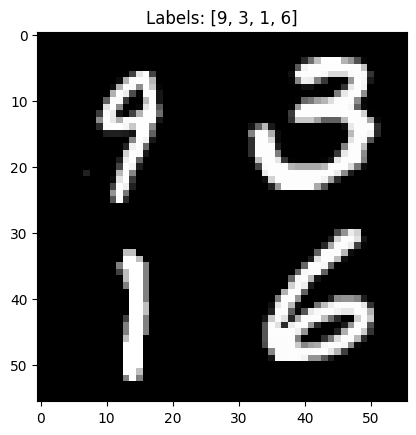

torch.Size([1, 1024]) x.shape
torch.Size([1, 1024]) flatten.shape
tensor([9]) prediction should equal 9


In [86]:
def do_test(model):
    image, label = generate_random_image(train_dataset)
    plt.imshow(image, cmap='gray')
    plt.title(f"Labels: {label}")
    plt.show()

    patches_array = split_image_to_patches(image)
    patches_tensor = [torch.tensor(patch.flatten(), dtype=torch.float32) for patch in patches_array]
    image_tensor = torch.stack(patches_tensor) # tensor [16,196]
    # print(image_tensor.shape, 'imagetensor.shape')

    model.eval()
    output = model.forward(image_tensor)
    single_number = model.predict_single_integer(output)
    prediction = torch.argmax(single_number, dim=1)
    print(prediction, 'prediction', "should equal", label[0])
do_test(model)

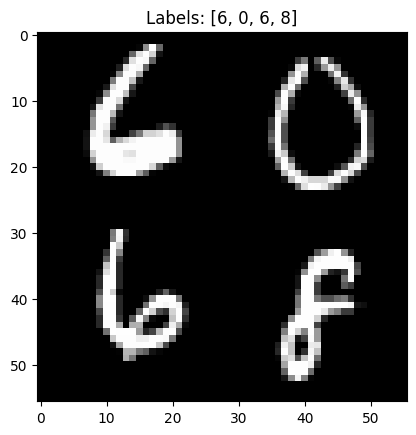

torch.Size([1, 1024]) x.shape
torch.Size([1, 1024]) flatten.shape
tensor([6]) prediction should equal 6


In [87]:
do_test(model)

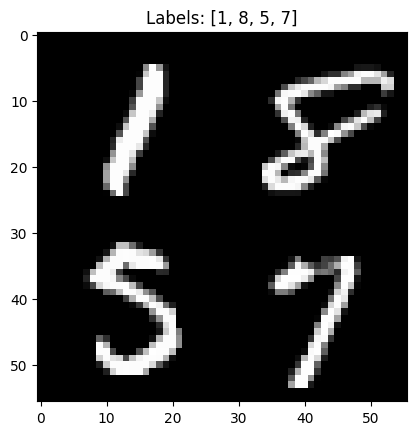

torch.Size([1, 1024]) x.shape
torch.Size([1, 1024]) flatten.shape
tensor([1]) prediction should equal 1


In [88]:
do_test(model)